# 08 베이지안 최적화 기반의 HyperOpt를 이용한 하이퍼 파라미터 튜닝

* XGBoost나 LightGBM에 Grid SearchCV를 적용할 경우, 기하급수적으로 늘어나는 하이퍼 파라미터 최적화 시간 때문에 하이퍼 파라미터 개수를 줄이거나 개별 하이퍼 파라미터의 범위를 줄여야 함 → 베이지안 최적화 기법과 같은 다른 방식을 적용할 수 있음

## 베이지안 최적화 개요

- 베이지안 최적화 : 블랙 박스 형태의 함수에서 최대 또는 최소 함수 반환 값을 만드는 최적 입력값을 가능한 적은 시도를 통해 빠르고 효과적으로 찾아주는 방식
- 베이지안 최적화를 구성하는 두 가지 요소 : 대체모델(Surrogate Model), 획득 함수(Acquisition Function)

## HyperOpt 사용하기

In [2]:
from hyperopt import hp

# -10 ~ 10까지 1간격을 가지는 입력 변수 x와 -15 ~ 15까지 1간격으로 입력 변수 y설정
search_space = {'x':hp.quniform('x',-10,10,1), 'y':hp.quniform('y',-15,15,1)}

In [3]:
from hyperopt import STATUS_OK

# 목적 함수를 생성, 변숫값과 변수 검색 공간을 가지는 딕셔너리를 인자로 받고, 특정값을 반환
def objective_func(search_space):
    x = search_space['x']
    y = search_space['y']
    retval = x**2 - 20*y
    
    return retval

In [4]:
import numpy as np
from hyperopt import fmin, tpe, Trials

# 입력 결괏값을 저장한 Trials 객체값 생성
trial_val = Trials()

# 목적 함수의 최솟값을 반환하는 최적 입력 변숫값을 5번의 입력값 시도(max_evals=5)로 찾아냄
best_01 = fmin(fn=objective_func, space=search_space, algo=tpe.suggest, max_evals=5,
              trials=trial_val, rstate=np.random.default_rng(seed=0))
print('best:',best_01)

100%|█████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 222.12trial/s, best loss: -224.0]
best: {'x': -4.0, 'y': 12.0}


In [5]:
trial_val = Trials()

# max_evals를 20회로 늘려서 재테스트
best_02 = fmin(fn=objective_func, space=search_space, algo=tpe.suggest, max_evals=20,
              trials=trial_val, rstate=np.random.default_rng(seed=0))
print('best:',best_02)

100%|███████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 261.08trial/s, best loss: -296.0]
best: {'x': 2.0, 'y': 15.0}


In [6]:
# fmin()에 인자로 들어가는 Trials 객체의 result 속성에 파이썬 리스트로 목적 함수 반환값들이 저장됨
# 리스트 내부의 개별 원소는 {'loss':함수 반환값, 'status':반환 상태값}와 같은 딕셔너리임.
print(trial_val.results)

[{'loss': -64.0, 'status': 'ok'}, {'loss': -184.0, 'status': 'ok'}, {'loss': 56.0, 'status': 'ok'}, {'loss': -224.0, 'status': 'ok'}, {'loss': 61.0, 'status': 'ok'}, {'loss': -296.0, 'status': 'ok'}, {'loss': -40.0, 'status': 'ok'}, {'loss': 281.0, 'status': 'ok'}, {'loss': 64.0, 'status': 'ok'}, {'loss': 100.0, 'status': 'ok'}, {'loss': 60.0, 'status': 'ok'}, {'loss': -39.0, 'status': 'ok'}, {'loss': 1.0, 'status': 'ok'}, {'loss': -164.0, 'status': 'ok'}, {'loss': 21.0, 'status': 'ok'}, {'loss': -56.0, 'status': 'ok'}, {'loss': 284.0, 'status': 'ok'}, {'loss': 176.0, 'status': 'ok'}, {'loss': -171.0, 'status': 'ok'}, {'loss': 0.0, 'status': 'ok'}]


In [7]:
# Trial 객체의 vals 속성에 {'입력변수명': 개별 수행시마다 입력된 값 리스트} 형태로 저장됨
print(trial_val.vals)

{'x': [-6.0, -4.0, 4.0, -4.0, 9.0, 2.0, 10.0, -9.0, -8.0, -0.0, -0.0, 1.0, 9.0, 6.0, 9.0, 2.0, -2.0, -4.0, 7.0, -0.0], 'y': [5.0, 10.0, -2.0, 12.0, 1.0, 15.0, 7.0, -10.0, 0.0, -5.0, -3.0, 2.0, 4.0, 10.0, 3.0, 3.0, -14.0, -8.0, 11.0, -0.0]}


In [8]:
import pandas as pd

# results에서 loss 키값에 해당하는 밸류들을 추출하여 list로 생성
losses = [loss_dict['loss'] for loss_dict in trial_val.results]

# DataFrame으로 생성
result_df = pd.DataFrame({'x': trial_val.vals['x'], 'y': trial_val.vals['y'], 'losses':losses})
result_df

,x,y,losses
0,-6.0,5.0,-64.0
1,-4.0,10.0,-184.0
2,4.0,-2.0,56.0
3,-4.0,12.0,-224.0
4,9.0,1.0,61.0
5,2.0,15.0,-296.0
6,10.0,7.0,-40.0
7,-9.0,-10.0,281.0
8,-8.0,0.0,64.0
9,-0.0,-5.0,100.0


## HyperOpt를 이용한 XGBoost 하이퍼 파라미터 최적화

In [9]:
import pandas as pd

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer = load_breast_cancer()

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, test_size=0.2, random_state=156)
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=156)

In [10]:
from hyperopt import hp

# max_depth는 5에서 20까지 1간격으로, min_child_weight는 1에서 2까지 1간격으로
# colsample_bytree는 0.5에서 1 사이, learning_rate는 0.01에서 0.2 사이 정규 분포된 값으로 검색

xgb_search_space = {'max_depth' : hp.quniform('max_depth',5,20,1),
                   'min_child_weight' : hp.quniform('min_child_weight',1,2,1),
                   'learning_rate' : hp.uniform('learning_rate',0.01,0.2),
                   'colsample_bytree' : hp.uniform('colsample_bytree',0.5,1)}

In [11]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from hyperopt import STATUS_OK

# fmin()에서 입력된 search_space 값으로 입력된 모든 값은 실수형임
# XGBClassifier의 정수형 하이퍼 파라미터는 정수형 변환을 해줘야 함
# 정확도는 높을수록 더 좋은 수치임 # -1 * 정확도를 통해 큰 정확도 값일수록 최소가 되도록 변환

def objective_func(search_space):
    
    # 수행시간 절약을 위해 nestimators는 100으로 축소
    xgb_clf = XGBClassifier(n_estimators=100, max_depth=int(search_space['max_depth']),
                           min_child_weight=int(search_space['min_child_weight']),
                           learning_rate = search_space['learning_rate'],
                           colsample_bytree = search_space['colsample_bytree'],
                           eval_metric='logloss')
    
    accuracy = cross_val_score(xgb_clf, X_train, y_train, scoring='accuracy', cv=3)
    
    # accurcy는 cv=3 개수 만큼 roc-auc 결과를 리스트로 가짐. 이를 평균해서 반환하되 -1을 곱합
    return {'loss':-1*np.mean(accuracy), 'status':STATUS_OK}

In [12]:
from hyperopt import fmin, tpe, Trials

trial_val = Trials()
best = fmin(fn=objective_func,
           space=xgb_search_space,
           algo=tpe.suggest,
           max_evals=50,
           trials=trial_val, rstate=np.random.default_rng(seed=9))

print('best:',best)

100%|███████████████████████████████████████████████| 50/50 [00:37<00:00,  1.32trial/s, best loss: -0.9670616939700244]
best: {'colsample_bytree': 0.5424149213362504, 'learning_rate': 0.12601372924444681, 'max_depth': 17.0, 'min_child_weight': 2.0}


In [13]:
print('colsample_bytree :{0}, learning_rate:{1}, max_depth:{2}, min_child_weight:{3}'.format(round(best['colsample_bytree'],5),
                                                                                             round(best['learning_rate'],5),
                                                                                             int(best['max_depth']),
                                                                                             int(best['min_child_weight'])))

colsample_bytree :0.54241, learning_rate:0.12601, max_depth:17, min_child_weight:2


In [14]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test , pred):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    roc_auc = roc_auc_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [15]:
xgb_wrapper = XGBClassifier(n_estimator=400,
                          learning_rate=round(best['learning_rate'],5),
                          max_depth=round(best['max_depth']),
                          min_child_weight=int(best['min_child_weight']),
                          colsample_bytree=round(best['colsample_bytree'],5)
                          )

evals = [(X_tr, y_tr), (X_val, y_val)]
xgb_wrapper.fit(X_tr, y_tr, early_stopping_rounds=50, eval_metric='logloss',
               eval_set=evals, verbose=True)

preds=xgb_wrapper.predict(X_test)
pred_proba=xgb_wrapper.predict_proba(X_test)[:,1]

get_clf_eval(y_test,preds)

[11:32:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimator" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.58942	validation_1-logloss:0.62048
[1]	validation_0-logloss:0.50801	validation_1-logloss:0.55913
[2]	validation_0-logloss:0.44160	validation_1-logloss:0.50928
[3]	validation_0-logloss:0.38734	validation_1-logloss:0.46815
[4]	validation_0-logloss:0.34224	validation_1-logloss:0.43913
[5]	validation_0-logloss:0.30425	validation_1-logloss:0.41570
[6]	validation_0-logloss:0.27178	validation_1-logloss:0.38953
[7]	validation_0-logloss:0.24503	validation_1-logloss:0.37317
[8]	validation_0-logloss:0.22050	validation_1-logloss:0.35628
[9]	validation_0-loglo

C:\Users\jy\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\jy\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[25]	validation_0-logloss:0.06220	validation_1-logloss:0.26484
[26]	validation_0-logloss:0.05946	validation_1-logloss:0.26604
[27]	validation_0-logloss:0.05688	validation_1-logloss:0.26836
[28]	validation_0-logloss:0.05457	validation_1-logloss:0.26746
[29]	validation_0-logloss:0.05161	validation_1-logloss:0.26410
[30]	validation_0-logloss:0.04900	validation_1-logloss:0.26314
[31]	validation_0-logloss:0.04658	validation_1-logloss:0.26210
[32]	validation_0-logloss:0.04442	validation_1-logloss:0.25918
[33]	validation_0-logloss:0.04293	validation_1-logloss:0.25575
[34]	validation_0-logloss:0.04149	validation_1-logloss:0.25681
[35]	validation_0-logloss:0.03991	validation_1-logloss:0.25727
[36]	validation_0-logloss:0.03849	validation_1-logloss:0.25710
[37]	validation_0-logloss:0.03702	validation_1-logloss:0.25274
[38]	validation_0-logloss:0.03552	validation_1-logloss:0.25427
[39]	validation_0-logloss:0.03441	validation_1-logloss:0.25366
[40]	validation_0-logloss:0.03335	validation_1-logloss:

# 09 분류 실습 - 캐글 산탄데르 고객 만족 예측

## 데이터 전처리

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings('ignore')

cust_df = pd.read_csv('./train_santander.csv',encoding='latin-1')
print('dataset shape:', cust_df.shape)
cust_df.head(3)

dataset shape: (76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.17,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.03,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.77,0


In [17]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


In [18]:
print(cust_df['TARGET'].value_counts())
unsatisfied_cnt = cust_df[cust_df['TARGET']==1].TARGET.count()
total_cnt = cust_df.TARGET.count()
print('unsatisfied 비율은 {0:.2f}'.format(unsatisfied_cnt / total_cnt))

0    73012
1     3008
Name: TARGET, dtype: int64
unsatisfied 비율은 0.04


In [19]:
cust_df.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


In [20]:
cust_df['var3'].replace(-999999,2,inplace=True)
cust_df.drop('ID',axis=1, inplace=True)

# 피처 세트와 레이블 세트 분리, 레이블 칼럼은 DataFrame의 맨 마지막에 위치해 칼럼 위치 -1로 분리
X_features=cust_df.iloc[:,:-1]
y_labels=cust_df.iloc[:,-1]
print('피처 데이터 shape:{0}'.format(X_features.shape))

피처 데이터 shape:(76020, 369)


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size=0.2, random_state=0)

train_cnt = y_train.count()
test_cnt = y_test.count()

print('학습 세트 shape:{0}, 테스트 세트 shape:{1}'.format(X_train.shape, X_test.shape))

print('학습 세트 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt)

print('테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)

학습 세트 shape:(60816, 369), 테스트 세트 shape:(15204, 369)
학습 세트 레이블 값 분포 비율
0    0.960964
1    0.039036
Name: TARGET, dtype: float64
테스트 세트 레이블 값 분포 비율
0    0.9583
1    0.0417
Name: TARGET, dtype: float64


In [22]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=0)

## XGBoost 모델 학습과 하이퍼 파라미터 튜닝

In [23]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# n_estimators는 500으로, random state는 예제 수행 시마다 동일 예측 결과를 위해 설정. 
xgb_clf = XGBClassifier(n_estimators=500, random_state=156)

# 성능 평가 지표를 auc로, 조기 중단 파라미터는 100으로 설정하고 학습 수행. 
xgb_clf.fit(X_train, y_train, early_stopping_rounds=100,
            eval_metric="auc", eval_set=[(X_train, y_train), (X_test, y_test)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1])
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.82005	validation_1-auc:0.81157
[1]	validation_0-auc:0.83400	validation_1-auc:0.82452
[2]	validation_0-auc:0.83870	validation_1-auc:0.82745
[3]	validation_0-auc:0.84419	validation_1-auc:0.82922
[4]	validation_0-auc:0.84783	validation_1-auc:0.83298
[5]	validation_0-auc:0.85125	validation_1-auc:0.83500
[6]	validation_0-auc:0.85501	validation_1-auc:0.83653
[7]	validation_0-auc:0.85831	validation_1-auc:0.83782
[8]	validation_0-auc:0.86143	validation_1-auc:0.83802
[9]	validation_0-auc:0.86452	validation_1-auc:0.83914
[10]	validation_0-auc:0.86717	validation_1-auc:0.83954
[11]	validation_0-auc:0.87013	validation_1-auc:0.83983
[12]	validation_0-auc:0.87369	validation_1-auc:0.84033
[13]	validation_0-auc:0.87620	validation_1-auc:0.84055
[14]	validation_0-auc:0.87799	validation_1-auc:0.84135
[15]	validation_0-auc:0.88071	validation_1-auc:0.84117
[16]	validation_0-auc:0.88237	validation_1-auc:0.84101
[17]	validation_0-auc:0.88352	validation_1-auc:0.84071
[18]	validation_0-au

In [24]:
from hyperopt import hp

# max_depth는 5에서 15까지 1간격으로, min_child_weight는 1에서 6까지 1간격으로
# colsample_bytree는 0.5에서 0.95 사이, learning_rate는 0.01에서 0.2 사이 정규 분포된 값으로 검색

xgb_search_space = {'max_depth' : hp.quniform('max_depth',5,16,1),
                   'min_child_weight' : hp.quniform('min_child_weight',1,6,1),
                   'colsample_bytree':hp.uniform('colsample_bytree',0.5,0.95),
                   'learning_rate' : hp.uniform('learning_rate',0.01,0.2)}

In [25]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

# fmin()에서 호출 시 search_space 값으로 XGBClassifier 교차 검증 후 -1 * roc_auc 평균값을 반환

def objective_func(search_space):
    xgb_clf = XGBClassifier(n_estimators=100, max_depth=int(search_space['max_depth']),
                           min_child_weight=int(search_space['min_child_weight']),
                           colsample_bytree=search_space['colsample_bytree'],
                           learning_rate=search_space['learning_rate'])
    
    # 3개 k-fold 방식으로 평가된 roc_auc 지표를 담는 list
    roc_auc_list = []
    
    # 3개 k-fold 방식 적용
    kf = KFold(n_splits=3)
    # X_train을 다시 학습과 검증용 데이터로 분리
    for tr_index, val_index in kf.split(X_train):
        # kf.split(X_train)으로 추출된 학습과 검증 index 값으로 학습과 검증 데이터 세트 분리
        X_tr, y_tr = X_train.iloc[tr_index], y_train.iloc[tr_index]
        X_val, y_val = X_train.iloc[val_index], y_train.iloc[val_index]
        
        # early stopping은 30회로 설정하고 추출된 학습과 검증 데이터로 XGBClassifier 학습 수행
        xgb_clf.fit(X_tr, y_tr, early_stopping_rounds=30, eval_metric='auc',
                   eval_set=[(X_tr,y_tr),(X_val,y_val)])
        
        # 1로 예측한 확률값 추출 후 roc auc 계산하고 평균 roc auc 계산을 위해 list에 결과값 담음
        score = roc_auc_score(y_val, xgb_clf.predict_proba(X_val)[:,1])
    
    # 3개 k-fold로 계산된 roc_auc 값의 평균값을 반환하되,
    # HyperOpt는 목적 함수의 최소값을 위한 입력값을 찾으므로 -1을 곱한뒤 반환.
    
    return -1*np.mean(roc_auc_list) 

In [27]:
from hyperopt import fmin, tpe, Trials

trials = Trials()

# fmin() 함수를 호출. max_evals 지정된 횟수만큼 반복 후 목적함수의 최솟값을 가지는 최적 입력값 추출.
best = fmin(fn=objective_func,
           space=xgb_search_space,
           algo=tpe.suggest,
           max_evals=50, 
           trials=trials, rstate=np.random.default_rng(seed=30))

print('best:',best)

[0]	validation_0-auc:0.81678	validation_1-auc:0.79160                                                                  
[1]	validation_0-auc:0.82454	validation_1-auc:0.79688                                                                  
[2]	validation_0-auc:0.83323	validation_1-auc:0.80572                                                                  
[3]	validation_0-auc:0.83854	validation_1-auc:0.81095                                                                  
[4]	validation_0-auc:0.83847	validation_1-auc:0.80989                                                                  
[5]	validation_0-auc:0.83879	validation_1-auc:0.80978                                                                  
[6]	validation_0-auc:0.84053	validation_1-auc:0.81042                                                                  
[7]	validation_0-auc:0.84129	validation_1-auc:0.81116                                                                  
[8]	validation_0-auc:0.84224	validation_

[68]	validation_0-auc:0.89250	validation_1-auc:0.83282                                                                 
[69]	validation_0-auc:0.89269	validation_1-auc:0.83292                                                                 
[70]	validation_0-auc:0.89308	validation_1-auc:0.83292                                                                 
[71]	validation_0-auc:0.89361	validation_1-auc:0.83264                                                                 
[72]	validation_0-auc:0.89406	validation_1-auc:0.83256                                                                 
[73]	validation_0-auc:0.89430	validation_1-auc:0.83239                                                                 
[74]	validation_0-auc:0.89457	validation_1-auc:0.83261                                                                 
[75]	validation_0-auc:0.89482	validation_1-auc:0.83233                                                                 
[76]	validation_0-auc:0.89494	validation

[46]	validation_0-auc:0.88228	validation_1-auc:0.83625                                                                 
[47]	validation_0-auc:0.88318	validation_1-auc:0.83603                                                                 
[48]	validation_0-auc:0.88406	validation_1-auc:0.83587                                                                 
[49]	validation_0-auc:0.88499	validation_1-auc:0.83567                                                                 
[50]	validation_0-auc:0.88567	validation_1-auc:0.83621                                                                 
[51]	validation_0-auc:0.88617	validation_1-auc:0.83640                                                                 
[52]	validation_0-auc:0.88688	validation_1-auc:0.83592                                                                 
[53]	validation_0-auc:0.88747	validation_1-auc:0.83641                                                                 
[54]	validation_0-auc:0.88846	validation

[14]	validation_0-auc:0.85451	validation_1-auc:0.82647                                                                 
[15]	validation_0-auc:0.85543	validation_1-auc:0.82596                                                                 
[16]	validation_0-auc:0.85660	validation_1-auc:0.82658                                                                 
[17]	validation_0-auc:0.85740	validation_1-auc:0.82710                                                                 
[18]	validation_0-auc:0.85886	validation_1-auc:0.82679                                                                 
[19]	validation_0-auc:0.85976	validation_1-auc:0.82722                                                                 
[20]	validation_0-auc:0.86042	validation_1-auc:0.82733                                                                 
[21]	validation_0-auc:0.86157	validation_1-auc:0.82861                                                                 
[22]	validation_0-auc:0.86180	validation

[82]	validation_0-auc:0.90020	validation_1-auc:0.83718                                                                 
[83]	validation_0-auc:0.90074	validation_1-auc:0.83709                                                                 
[84]	validation_0-auc:0.90102	validation_1-auc:0.83728                                                                 
[85]	validation_0-auc:0.90138	validation_1-auc:0.83751                                                                 
[86]	validation_0-auc:0.90155	validation_1-auc:0.83765                                                                 
[87]	validation_0-auc:0.90164	validation_1-auc:0.83763                                                                 
[88]	validation_0-auc:0.90170	validation_1-auc:0.83761                                                                 
[89]	validation_0-auc:0.90205	validation_1-auc:0.83762                                                                 
[90]	validation_0-auc:0.90245	validation

[50]	validation_0-auc:0.90609	validation_1-auc:0.82910                                                                 
[51]	validation_0-auc:0.90734	validation_1-auc:0.82942                                                                 
[52]	validation_0-auc:0.90791	validation_1-auc:0.82970                                                                 
[53]	validation_0-auc:0.90883	validation_1-auc:0.82942                                                                 
[54]	validation_0-auc:0.90929	validation_1-auc:0.82898                                                                 
[55]	validation_0-auc:0.90988	validation_1-auc:0.82946                                                                 
[56]	validation_0-auc:0.91027	validation_1-auc:0.82897                                                                 
[57]	validation_0-auc:0.91072	validation_1-auc:0.82858                                                                 
[58]	validation_0-auc:0.91147	validation

[36]	validation_0-auc:0.89348	validation_1-auc:0.82800                                                                 
[37]	validation_0-auc:0.89428	validation_1-auc:0.82742                                                                 
[38]	validation_0-auc:0.89482	validation_1-auc:0.82717                                                                 
[39]	validation_0-auc:0.89558	validation_1-auc:0.82761                                                                 
[40]	validation_0-auc:0.89716	validation_1-auc:0.82865                                                                 
[41]	validation_0-auc:0.89731	validation_1-auc:0.82804                                                                 
[42]	validation_0-auc:0.89963	validation_1-auc:0.82864                                                                 
[43]	validation_0-auc:0.90070	validation_1-auc:0.82905                                                                 
[44]	validation_0-auc:0.90212	validation

[4]	validation_0-auc:0.84842	validation_1-auc:0.81948                                                                  
[5]	validation_0-auc:0.85504	validation_1-auc:0.82117                                                                  
[6]	validation_0-auc:0.85606	validation_1-auc:0.82256                                                                  
[7]	validation_0-auc:0.85843	validation_1-auc:0.82195                                                                  
[8]	validation_0-auc:0.86012	validation_1-auc:0.82216                                                                  
[9]	validation_0-auc:0.86361	validation_1-auc:0.82226                                                                  
[10]	validation_0-auc:0.86372	validation_1-auc:0.82070                                                                 
[11]	validation_0-auc:0.86335	validation_1-auc:0.82014                                                                 
[12]	validation_0-auc:0.86571	validation

[72]	validation_0-auc:0.92295	validation_1-auc:0.83001                                                                 
[73]	validation_0-auc:0.92328	validation_1-auc:0.82957                                                                 
[74]	validation_0-auc:0.92384	validation_1-auc:0.82951                                                                 
[75]	validation_0-auc:0.92432	validation_1-auc:0.82995                                                                 
[76]	validation_0-auc:0.92477	validation_1-auc:0.83050                                                                 
[77]	validation_0-auc:0.92502	validation_1-auc:0.83032                                                                 
[78]	validation_0-auc:0.92523	validation_1-auc:0.83084                                                                 
[79]	validation_0-auc:0.92549	validation_1-auc:0.83114                                                                 
[80]	validation_0-auc:0.92608	validation

[40]	validation_0-auc:0.93490	validation_1-auc:0.82603                                                                 
[41]	validation_0-auc:0.93518	validation_1-auc:0.82577                                                                 
[42]	validation_0-auc:0.93575	validation_1-auc:0.82560                                                                 
[43]	validation_0-auc:0.93603	validation_1-auc:0.82574                                                                 
[44]	validation_0-auc:0.93697	validation_1-auc:0.82628                                                                 
[45]	validation_0-auc:0.93714	validation_1-auc:0.82631                                                                 
[46]	validation_0-auc:0.93740	validation_1-auc:0.82635                                                                 
[47]	validation_0-auc:0.93805	validation_1-auc:0.82599                                                                 
[48]	validation_0-auc:0.93842	validation

[50]	validation_0-auc:0.94068	validation_1-auc:0.83113                                                                 
[51]	validation_0-auc:0.94156	validation_1-auc:0.83151                                                                 
[52]	validation_0-auc:0.94219	validation_1-auc:0.83151                                                                 
[53]	validation_0-auc:0.94260	validation_1-auc:0.83139                                                                 
[54]	validation_0-auc:0.94326	validation_1-auc:0.83146                                                                 
[0]	validation_0-auc:0.83493	validation_1-auc:0.81063                                                                  
[1]	validation_0-auc:0.84197	validation_1-auc:0.81316                                                                  
[2]	validation_0-auc:0.85026	validation_1-auc:0.81739                                                                  
[3]	validation_0-auc:0.85484	validation_

[63]	validation_0-auc:0.94587	validation_1-auc:0.83211                                                                 
[64]	validation_0-auc:0.94588	validation_1-auc:0.83213                                                                 
[65]	validation_0-auc:0.94617	validation_1-auc:0.83215                                                                 
[66]	validation_0-auc:0.94637	validation_1-auc:0.83167                                                                 
[67]	validation_0-auc:0.94649	validation_1-auc:0.83147                                                                 
[68]	validation_0-auc:0.94655	validation_1-auc:0.83137                                                                 
[69]	validation_0-auc:0.94663	validation_1-auc:0.83122                                                                 
[70]	validation_0-auc:0.94733	validation_1-auc:0.83109                                                                 
[71]	validation_0-auc:0.94744	validation

[44]	validation_0-auc:0.89512	validation_1-auc:0.82856                                                                 
[45]	validation_0-auc:0.89581	validation_1-auc:0.82883                                                                 
[46]	validation_0-auc:0.89648	validation_1-auc:0.82928                                                                 
[47]	validation_0-auc:0.89771	validation_1-auc:0.82954                                                                 
[48]	validation_0-auc:0.89857	validation_1-auc:0.82976                                                                 
[49]	validation_0-auc:0.89945	validation_1-auc:0.83009                                                                 
[50]	validation_0-auc:0.89986	validation_1-auc:0.82978                                                                 
[51]	validation_0-auc:0.90055	validation_1-auc:0.82992                                                                 
[52]	validation_0-auc:0.90174	validation

[12]	validation_0-auc:0.85733	validation_1-auc:0.82293                                                                 
[13]	validation_0-auc:0.86099	validation_1-auc:0.82427                                                                 
[14]	validation_0-auc:0.86191	validation_1-auc:0.82485                                                                 
[15]	validation_0-auc:0.86433	validation_1-auc:0.82600                                                                 
[16]	validation_0-auc:0.86600	validation_1-auc:0.82674                                                                 
[17]	validation_0-auc:0.86719	validation_1-auc:0.82710                                                                 
[18]	validation_0-auc:0.86678	validation_1-auc:0.82530                                                                 
[19]	validation_0-auc:0.86936	validation_1-auc:0.82625                                                                 
[20]	validation_0-auc:0.87093	validation

[80]	validation_0-auc:0.92221	validation_1-auc:0.82966                                                                 
[81]	validation_0-auc:0.92264	validation_1-auc:0.82930                                                                 
[0]	validation_0-auc:0.83151	validation_1-auc:0.81161                                                                  
[1]	validation_0-auc:0.83691	validation_1-auc:0.81288                                                                  
[2]	validation_0-auc:0.84067	validation_1-auc:0.81631                                                                  
[3]	validation_0-auc:0.84238	validation_1-auc:0.81676                                                                  
[4]	validation_0-auc:0.84565	validation_1-auc:0.81748                                                                  
[5]	validation_0-auc:0.85390	validation_1-auc:0.82067                                                                  
[6]	validation_0-auc:0.85488	validation_

[66]	validation_0-auc:0.91424	validation_1-auc:0.82680                                                                 
[67]	validation_0-auc:0.91463	validation_1-auc:0.82745                                                                 
[68]	validation_0-auc:0.91529	validation_1-auc:0.82769                                                                 
[69]	validation_0-auc:0.91590	validation_1-auc:0.82789                                                                 
[70]	validation_0-auc:0.91669	validation_1-auc:0.82822                                                                 
[71]	validation_0-auc:0.91709	validation_1-auc:0.82801                                                                 
[72]	validation_0-auc:0.91775	validation_1-auc:0.82842                                                                 
[73]	validation_0-auc:0.91822	validation_1-auc:0.82818                                                                 
[74]	validation_0-auc:0.91891	validation

[12]	validation_0-auc:0.90589	validation_1-auc:0.82400                                                                 
[13]	validation_0-auc:0.91054	validation_1-auc:0.82606                                                                 
[14]	validation_0-auc:0.91366	validation_1-auc:0.82785                                                                 
[15]	validation_0-auc:0.91899	validation_1-auc:0.82734                                                                 
[16]	validation_0-auc:0.92293	validation_1-auc:0.82725                                                                 
[17]	validation_0-auc:0.92550	validation_1-auc:0.82802                                                                 
[18]	validation_0-auc:0.92686	validation_1-auc:0.82727                                                                 
[19]	validation_0-auc:0.92992	validation_1-auc:0.82778                                                                 
[20]	validation_0-auc:0.93276	validation

[16]	validation_0-auc:0.92386	validation_1-auc:0.82863                                                                 
[17]	validation_0-auc:0.92568	validation_1-auc:0.82991                                                                 
[18]	validation_0-auc:0.92713	validation_1-auc:0.82783                                                                 
[19]	validation_0-auc:0.93034	validation_1-auc:0.82834                                                                 
[20]	validation_0-auc:0.93373	validation_1-auc:0.82739                                                                 
[21]	validation_0-auc:0.93533	validation_1-auc:0.82765                                                                 
[22]	validation_0-auc:0.93788	validation_1-auc:0.82901                                                                 
[23]	validation_0-auc:0.93973	validation_1-auc:0.82968                                                                 
[24]	validation_0-auc:0.94144	validation

[29]	validation_0-auc:0.87606	validation_1-auc:0.83111                                                                 
[30]	validation_0-auc:0.87686	validation_1-auc:0.83101                                                                 
[31]	validation_0-auc:0.87847	validation_1-auc:0.83154                                                                 
[32]	validation_0-auc:0.87949	validation_1-auc:0.83186                                                                 
[33]	validation_0-auc:0.87998	validation_1-auc:0.83204                                                                 
[34]	validation_0-auc:0.88086	validation_1-auc:0.83263                                                                 
[35]	validation_0-auc:0.88141	validation_1-auc:0.83258                                                                 
[36]	validation_0-auc:0.88228	validation_1-auc:0.83286                                                                 
[37]	validation_0-auc:0.88323	validation

[17]	validation_0-auc:0.86623	validation_1-auc:0.83104                                                                 
[18]	validation_0-auc:0.86596	validation_1-auc:0.83003                                                                 
[19]	validation_0-auc:0.86728	validation_1-auc:0.82987                                                                 
[20]	validation_0-auc:0.86858	validation_1-auc:0.82962                                                                 
[21]	validation_0-auc:0.86843	validation_1-auc:0.82914                                                                 
[22]	validation_0-auc:0.87012	validation_1-auc:0.83008                                                                 
[23]	validation_0-auc:0.87126	validation_1-auc:0.83055                                                                 
[24]	validation_0-auc:0.87246	validation_1-auc:0.83198                                                                 
[25]	validation_0-auc:0.87304	validation

[85]	validation_0-auc:0.90531	validation_1-auc:0.83624                                                                 
[86]	validation_0-auc:0.90546	validation_1-auc:0.83618                                                                 
[87]	validation_0-auc:0.90557	validation_1-auc:0.83614                                                                 
[88]	validation_0-auc:0.90571	validation_1-auc:0.83625                                                                 
[89]	validation_0-auc:0.90592	validation_1-auc:0.83604                                                                 
[0]	validation_0-auc:0.82782	validation_1-auc:0.81080                                                                  
[1]	validation_0-auc:0.83279	validation_1-auc:0.81373                                                                  
[2]	validation_0-auc:0.83821	validation_1-auc:0.81878                                                                  
[3]	validation_0-auc:0.83904	validation_

[63]	validation_0-auc:0.90018	validation_1-auc:0.83634                                                                 
[64]	validation_0-auc:0.90055	validation_1-auc:0.83657                                                                 
[65]	validation_0-auc:0.90091	validation_1-auc:0.83660                                                                 
[66]	validation_0-auc:0.90148	validation_1-auc:0.83640                                                                 
[67]	validation_0-auc:0.90176	validation_1-auc:0.83679                                                                 
[68]	validation_0-auc:0.90216	validation_1-auc:0.83684                                                                 
[69]	validation_0-auc:0.90245	validation_1-auc:0.83715                                                                 
[70]	validation_0-auc:0.90292	validation_1-auc:0.83724                                                                 
[71]	validation_0-auc:0.90313	validation

[31]	validation_0-auc:0.88573	validation_1-auc:0.82975                                                                 
[32]	validation_0-auc:0.88640	validation_1-auc:0.83004                                                                 
[33]	validation_0-auc:0.88722	validation_1-auc:0.83040                                                                 
[34]	validation_0-auc:0.88814	validation_1-auc:0.83066                                                                 
[35]	validation_0-auc:0.88888	validation_1-auc:0.83071                                                                 
[36]	validation_0-auc:0.88977	validation_1-auc:0.83041                                                                 
[37]	validation_0-auc:0.89058	validation_1-auc:0.83060                                                                 
[38]	validation_0-auc:0.89177	validation_1-auc:0.82986                                                                 
[39]	validation_0-auc:0.89214	validation

[18]	validation_0-auc:0.86915	validation_1-auc:0.82995                                                                 
[19]	validation_0-auc:0.87146	validation_1-auc:0.82972                                                                 
[20]	validation_0-auc:0.87266	validation_1-auc:0.83069                                                                 
[21]	validation_0-auc:0.87312	validation_1-auc:0.83042                                                                 
[22]	validation_0-auc:0.87468	validation_1-auc:0.83075                                                                 
[23]	validation_0-auc:0.87650	validation_1-auc:0.83167                                                                 
[24]	validation_0-auc:0.87752	validation_1-auc:0.83236                                                                 
[25]	validation_0-auc:0.87808	validation_1-auc:0.83337                                                                 
[26]	validation_0-auc:0.87979	validation

[0]	validation_0-auc:0.82845	validation_1-auc:0.81010                                                                  
[1]	validation_0-auc:0.83454	validation_1-auc:0.81359                                                                  
[2]	validation_0-auc:0.83987	validation_1-auc:0.81785                                                                  
[3]	validation_0-auc:0.84295	validation_1-auc:0.81776                                                                  
[4]	validation_0-auc:0.84591	validation_1-auc:0.81835                                                                  
[5]	validation_0-auc:0.85215	validation_1-auc:0.82004                                                                  
[6]	validation_0-auc:0.85504	validation_1-auc:0.82272                                                                  
[7]	validation_0-auc:0.85599	validation_1-auc:0.82258                                                                  
[8]	validation_0-auc:0.85749	validation_

[68]	validation_0-auc:0.90938	validation_1-auc:0.83554                                                                 
[69]	validation_0-auc:0.90962	validation_1-auc:0.83553                                                                 
[70]	validation_0-auc:0.90994	validation_1-auc:0.83538                                                                 
[71]	validation_0-auc:0.91005	validation_1-auc:0.83521                                                                 
[72]	validation_0-auc:0.91082	validation_1-auc:0.83561                                                                 
[73]	validation_0-auc:0.91105	validation_1-auc:0.83564                                                                 
[74]	validation_0-auc:0.91130	validation_1-auc:0.83572                                                                 
[75]	validation_0-auc:0.91154	validation_1-auc:0.83584                                                                 
[76]	validation_0-auc:0.91226	validation

[47]	validation_0-auc:0.92240	validation_1-auc:0.82824                                                                 
[48]	validation_0-auc:0.92308	validation_1-auc:0.82841                                                                 
[49]	validation_0-auc:0.92395	validation_1-auc:0.82814                                                                 
[50]	validation_0-auc:0.92497	validation_1-auc:0.82803                                                                 
[51]	validation_0-auc:0.92571	validation_1-auc:0.82809                                                                 
[52]	validation_0-auc:0.92636	validation_1-auc:0.82888                                                                 
[53]	validation_0-auc:0.92713	validation_1-auc:0.82850                                                                 
[54]	validation_0-auc:0.92857	validation_1-auc:0.82859                                                                 
[55]	validation_0-auc:0.92917	validation

[33]	validation_0-auc:0.90970	validation_1-auc:0.83092                                                                 
[34]	validation_0-auc:0.91091	validation_1-auc:0.83070                                                                 
[35]	validation_0-auc:0.91198	validation_1-auc:0.83129                                                                 
[36]	validation_0-auc:0.91305	validation_1-auc:0.83136                                                                 
[37]	validation_0-auc:0.91457	validation_1-auc:0.83141                                                                 
[38]	validation_0-auc:0.91578	validation_1-auc:0.83165                                                                 
[39]	validation_0-auc:0.91658	validation_1-auc:0.83258                                                                 
[40]	validation_0-auc:0.91733	validation_1-auc:0.83284                                                                 
[41]	validation_0-auc:0.91825	validation

[28]	validation_0-auc:0.90300	validation_1-auc:0.82731                                                                 
[29]	validation_0-auc:0.90455	validation_1-auc:0.82744                                                                 
[30]	validation_0-auc:0.90653	validation_1-auc:0.82599                                                                 
[31]	validation_0-auc:0.90741	validation_1-auc:0.82681                                                                 
[32]	validation_0-auc:0.90888	validation_1-auc:0.82621                                                                 
[33]	validation_0-auc:0.90917	validation_1-auc:0.82679                                                                 
[34]	validation_0-auc:0.91057	validation_1-auc:0.82682                                                                 
[35]	validation_0-auc:0.91208	validation_1-auc:0.82706                                                                 
[36]	validation_0-auc:0.91369	validation

[29]	validation_0-auc:0.87767	validation_1-auc:0.83100                                                                 
[30]	validation_0-auc:0.87903	validation_1-auc:0.83172                                                                 
[31]	validation_0-auc:0.87987	validation_1-auc:0.83125                                                                 
[32]	validation_0-auc:0.88092	validation_1-auc:0.83092                                                                 
[33]	validation_0-auc:0.88198	validation_1-auc:0.83125                                                                 
[34]	validation_0-auc:0.88252	validation_1-auc:0.83173                                                                 
[35]	validation_0-auc:0.88332	validation_1-auc:0.83195                                                                 
[36]	validation_0-auc:0.88425	validation_1-auc:0.83179                                                                 
[37]	validation_0-auc:0.88462	validation

[23]	validation_0-auc:0.87221	validation_1-auc:0.83518                                                                 
[24]	validation_0-auc:0.87310	validation_1-auc:0.83510                                                                 
[25]	validation_0-auc:0.87411	validation_1-auc:0.83515                                                                 
[26]	validation_0-auc:0.87527	validation_1-auc:0.83576                                                                 
[27]	validation_0-auc:0.87677	validation_1-auc:0.83643                                                                 
[28]	validation_0-auc:0.87802	validation_1-auc:0.83557                                                                 
[29]	validation_0-auc:0.87922	validation_1-auc:0.83607                                                                 
[30]	validation_0-auc:0.88072	validation_1-auc:0.83644                                                                 
[31]	validation_0-auc:0.88160	validation

[7]	validation_0-auc:0.84837	validation_1-auc:0.82370                                                                  
[8]	validation_0-auc:0.85030	validation_1-auc:0.82442                                                                  
[9]	validation_0-auc:0.85567	validation_1-auc:0.82798                                                                  
[10]	validation_0-auc:0.85685	validation_1-auc:0.82843                                                                 
[11]	validation_0-auc:0.85838	validation_1-auc:0.82831                                                                 
[12]	validation_0-auc:0.86120	validation_1-auc:0.83075                                                                 
[13]	validation_0-auc:0.86282	validation_1-auc:0.83091                                                                 
[14]	validation_0-auc:0.86396	validation_1-auc:0.83138                                                                 
[15]	validation_0-auc:0.86577	validation

[75]	validation_0-auc:0.90544	validation_1-auc:0.83597                                                                 
[76]	validation_0-auc:0.90583	validation_1-auc:0.83598                                                                 
[0]	validation_0-auc:0.82870	validation_1-auc:0.80113                                                                  
[1]	validation_0-auc:0.84042	validation_1-auc:0.80454                                                                  
[2]	validation_0-auc:0.84916	validation_1-auc:0.81057                                                                  
[3]	validation_0-auc:0.85325	validation_1-auc:0.81254                                                                  
[4]	validation_0-auc:0.85792	validation_1-auc:0.81275                                                                  
[5]	validation_0-auc:0.86202	validation_1-auc:0.81323                                                                  
[6]	validation_0-auc:0.86395	validation_

[5]	validation_0-auc:0.86360	validation_1-auc:0.82476                                                                  
[6]	validation_0-auc:0.86721	validation_1-auc:0.82451                                                                  
[7]	validation_0-auc:0.86953	validation_1-auc:0.82344                                                                  
[8]	validation_0-auc:0.87521	validation_1-auc:0.82716                                                                  
[9]	validation_0-auc:0.87996	validation_1-auc:0.82876                                                                  
[10]	validation_0-auc:0.88141	validation_1-auc:0.82635                                                                 
[11]	validation_0-auc:0.88923	validation_1-auc:0.82795                                                                 
[12]	validation_0-auc:0.89490	validation_1-auc:0.82902                                                                 
[13]	validation_0-auc:0.89777	validation

[21]	validation_0-auc:0.92556	validation_1-auc:0.82705                                                                 
[22]	validation_0-auc:0.92878	validation_1-auc:0.82656                                                                 
[23]	validation_0-auc:0.93123	validation_1-auc:0.82612                                                                 
[24]	validation_0-auc:0.93370	validation_1-auc:0.82689                                                                 
[25]	validation_0-auc:0.93566	validation_1-auc:0.82747                                                                 
[26]	validation_0-auc:0.93697	validation_1-auc:0.82807                                                                 
[27]	validation_0-auc:0.93841	validation_1-auc:0.82819                                                                 
[28]	validation_0-auc:0.94041	validation_1-auc:0.82768                                                                 
[29]	validation_0-auc:0.94195	validation

[42]	validation_0-auc:0.88608	validation_1-auc:0.82322                                                                 
[43]	validation_0-auc:0.88746	validation_1-auc:0.82373                                                                 
[44]	validation_0-auc:0.88799	validation_1-auc:0.82373                                                                 
[45]	validation_0-auc:0.88842	validation_1-auc:0.82392                                                                 
[46]	validation_0-auc:0.88928	validation_1-auc:0.82430                                                                 
[47]	validation_0-auc:0.88993	validation_1-auc:0.82432                                                                 
[48]	validation_0-auc:0.89122	validation_1-auc:0.82475                                                                 
[49]	validation_0-auc:0.89210	validation_1-auc:0.82472                                                                 
[50]	validation_0-auc:0.89244	validation

[10]	validation_0-auc:0.85606	validation_1-auc:0.82125                                                                 
[11]	validation_0-auc:0.85688	validation_1-auc:0.81966                                                                 
[12]	validation_0-auc:0.85862	validation_1-auc:0.82108                                                                 
[13]	validation_0-auc:0.86046	validation_1-auc:0.82228                                                                 
[14]	validation_0-auc:0.86415	validation_1-auc:0.82445                                                                 
[15]	validation_0-auc:0.86621	validation_1-auc:0.82481                                                                 
[16]	validation_0-auc:0.86714	validation_1-auc:0.82484                                                                 
[17]	validation_0-auc:0.86818	validation_1-auc:0.82537                                                                 
[18]	validation_0-auc:0.86748	validation

[78]	validation_0-auc:0.91710	validation_1-auc:0.82944                                                                 
[79]	validation_0-auc:0.91750	validation_1-auc:0.82963                                                                 
[80]	validation_0-auc:0.91806	validation_1-auc:0.82948                                                                 
[81]	validation_0-auc:0.91835	validation_1-auc:0.82926                                                                 
[82]	validation_0-auc:0.91866	validation_1-auc:0.82967                                                                 
[0]	validation_0-auc:0.83748	validation_1-auc:0.80881                                                                  
[1]	validation_0-auc:0.84085	validation_1-auc:0.81081                                                                  
[2]	validation_0-auc:0.84433	validation_1-auc:0.81251                                                                  
[3]	validation_0-auc:0.84567	validation_

[63]	validation_0-auc:0.90938	validation_1-auc:0.82763                                                                 
[64]	validation_0-auc:0.91016	validation_1-auc:0.82780                                                                 
[65]	validation_0-auc:0.91089	validation_1-auc:0.82752                                                                 
[66]	validation_0-auc:0.91144	validation_1-auc:0.82758                                                                 
[67]	validation_0-auc:0.91188	validation_1-auc:0.82806                                                                 
[68]	validation_0-auc:0.91241	validation_1-auc:0.82800                                                                 
[69]	validation_0-auc:0.91337	validation_1-auc:0.82807                                                                 
[70]	validation_0-auc:0.91453	validation_1-auc:0.82788                                                                 
[71]	validation_0-auc:0.91535	validation

[44]	validation_0-auc:0.96461	validation_1-auc:0.82071                                                                 
[45]	validation_0-auc:0.96498	validation_1-auc:0.82027                                                                 
[46]	validation_0-auc:0.96558	validation_1-auc:0.81996                                                                 
[47]	validation_0-auc:0.96624	validation_1-auc:0.81998                                                                 
[48]	validation_0-auc:0.96683	validation_1-auc:0.81958                                                                 
[49]	validation_0-auc:0.96718	validation_1-auc:0.81956                                                                 
[50]	validation_0-auc:0.96734	validation_1-auc:0.81941                                                                 
[51]	validation_0-auc:0.96793	validation_1-auc:0.81937                                                                 
[52]	validation_0-auc:0.96800	validation

[10]	validation_0-auc:0.89648	validation_1-auc:0.82177                                                                 
[11]	validation_0-auc:0.90467	validation_1-auc:0.82411                                                                 
[12]	validation_0-auc:0.90983	validation_1-auc:0.82372                                                                 
[13]	validation_0-auc:0.91497	validation_1-auc:0.82413                                                                 
[14]	validation_0-auc:0.91824	validation_1-auc:0.82451                                                                 
[15]	validation_0-auc:0.92354	validation_1-auc:0.82419                                                                 
[16]	validation_0-auc:0.92661	validation_1-auc:0.82488                                                                 
[17]	validation_0-auc:0.93145	validation_1-auc:0.82298                                                                 
[18]	validation_0-auc:0.93420	validation

[14]	validation_0-auc:0.84751	validation_1-auc:0.81942                                                                 
[15]	validation_0-auc:0.84837	validation_1-auc:0.81991                                                                 
[16]	validation_0-auc:0.84980	validation_1-auc:0.82053                                                                 
[17]	validation_0-auc:0.85035	validation_1-auc:0.82170                                                                 
[18]	validation_0-auc:0.84924	validation_1-auc:0.81978                                                                 
[19]	validation_0-auc:0.84984	validation_1-auc:0.82054                                                                 
[20]	validation_0-auc:0.85145	validation_1-auc:0.82207                                                                 
[21]	validation_0-auc:0.84974	validation_1-auc:0.81921                                                                 
[22]	validation_0-auc:0.85104	validation

[82]	validation_0-auc:0.88510	validation_1-auc:0.82993                                                                 
[83]	validation_0-auc:0.88527	validation_1-auc:0.82960                                                                 
[84]	validation_0-auc:0.88545	validation_1-auc:0.82943                                                                 
[85]	validation_0-auc:0.88620	validation_1-auc:0.82989                                                                 
[86]	validation_0-auc:0.88695	validation_1-auc:0.83029                                                                 
[87]	validation_0-auc:0.88756	validation_1-auc:0.83023                                                                 
[88]	validation_0-auc:0.88785	validation_1-auc:0.83006                                                                 
[89]	validation_0-auc:0.88844	validation_1-auc:0.83006                                                                 
[90]	validation_0-auc:0.88895	validation

[50]	validation_0-auc:0.87421	validation_1-auc:0.83199                                                                 
[51]	validation_0-auc:0.87470	validation_1-auc:0.83230                                                                 
[52]	validation_0-auc:0.87530	validation_1-auc:0.83219                                                                 
[53]	validation_0-auc:0.87577	validation_1-auc:0.83225                                                                 
[54]	validation_0-auc:0.87595	validation_1-auc:0.83224                                                                 
[55]	validation_0-auc:0.87639	validation_1-auc:0.83185                                                                 
[56]	validation_0-auc:0.87666	validation_1-auc:0.83206                                                                 
[57]	validation_0-auc:0.87747	validation_1-auc:0.83174                                                                 
[58]	validation_0-auc:0.87779	validation

[36]	validation_0-auc:0.86843	validation_1-auc:0.82811                                                                 
[37]	validation_0-auc:0.86867	validation_1-auc:0.82800                                                                 
[38]	validation_0-auc:0.86938	validation_1-auc:0.82776                                                                 
[39]	validation_0-auc:0.86968	validation_1-auc:0.82781                                                                 
[40]	validation_0-auc:0.86981	validation_1-auc:0.82798                                                                 
[41]	validation_0-auc:0.87004	validation_1-auc:0.82792                                                                 
[42]	validation_0-auc:0.87062	validation_1-auc:0.82796                                                                 
[43]	validation_0-auc:0.87112	validation_1-auc:0.82794                                                                 
[44]	validation_0-auc:0.87144	validation

[4]	validation_0-auc:0.84471	validation_1-auc:0.80639                                                                  
[5]	validation_0-auc:0.84798	validation_1-auc:0.80964                                                                  
[6]	validation_0-auc:0.85008	validation_1-auc:0.80963                                                                  
[7]	validation_0-auc:0.85147	validation_1-auc:0.80936                                                                  
[8]	validation_0-auc:0.85337	validation_1-auc:0.80951                                                                  
[9]	validation_0-auc:0.85741	validation_1-auc:0.81411                                                                  
[10]	validation_0-auc:0.85573	validation_1-auc:0.81061                                                                 
[11]	validation_0-auc:0.85785	validation_1-auc:0.81284                                                                 
[12]	validation_0-auc:0.85980	validation

[72]	validation_0-auc:0.92782	validation_1-auc:0.82793                                                                 
[73]	validation_0-auc:0.92830	validation_1-auc:0.82803                                                                 
[74]	validation_0-auc:0.92923	validation_1-auc:0.82810                                                                 
[75]	validation_0-auc:0.93010	validation_1-auc:0.82819                                                                 
[76]	validation_0-auc:0.93037	validation_1-auc:0.82848                                                                 
[77]	validation_0-auc:0.93085	validation_1-auc:0.82851                                                                 
[78]	validation_0-auc:0.93169	validation_1-auc:0.82830                                                                 
[79]	validation_0-auc:0.93240	validation_1-auc:0.82817                                                                 
[80]	validation_0-auc:0.93311	validation

[51]	validation_0-auc:0.91172	validation_1-auc:0.83288                                                                 
[52]	validation_0-auc:0.91285	validation_1-auc:0.83286                                                                 
[53]	validation_0-auc:0.91362	validation_1-auc:0.83246                                                                 
[54]	validation_0-auc:0.91446	validation_1-auc:0.83201                                                                 
[55]	validation_0-auc:0.91531	validation_1-auc:0.83167                                                                 
[56]	validation_0-auc:0.91636	validation_1-auc:0.83230                                                                 
[57]	validation_0-auc:0.91743	validation_1-auc:0.83235                                                                 
[58]	validation_0-auc:0.91828	validation_1-auc:0.83261                                                                 
[59]	validation_0-auc:0.91911	validation

[47]	validation_0-auc:0.90890	validation_1-auc:0.83040                                                                 
[48]	validation_0-auc:0.90950	validation_1-auc:0.83021                                                                 
[49]	validation_0-auc:0.91026	validation_1-auc:0.83026                                                                 
[50]	validation_0-auc:0.91165	validation_1-auc:0.83090                                                                 
[51]	validation_0-auc:0.91243	validation_1-auc:0.83038                                                                 
[52]	validation_0-auc:0.91348	validation_1-auc:0.83049                                                                 
[53]	validation_0-auc:0.91449	validation_1-auc:0.83043                                                                 
[54]	validation_0-auc:0.91610	validation_1-auc:0.83066                                                                 
[55]	validation_0-auc:0.91709	validation

[34]	validation_0-auc:0.86680	validation_1-auc:0.82890                                                                 
[35]	validation_0-auc:0.86758	validation_1-auc:0.82920                                                                 
[36]	validation_0-auc:0.86819	validation_1-auc:0.82920                                                                 
[37]	validation_0-auc:0.86835	validation_1-auc:0.82955                                                                 
[38]	validation_0-auc:0.86891	validation_1-auc:0.83011                                                                 
[39]	validation_0-auc:0.86928	validation_1-auc:0.83063                                                                 
[40]	validation_0-auc:0.86985	validation_1-auc:0.83067                                                                 
[41]	validation_0-auc:0.86994	validation_1-auc:0.83071                                                                 
[42]	validation_0-auc:0.87071	validation

[6]	validation_0-auc:0.83830	validation_1-auc:0.82075                                                                  
[7]	validation_0-auc:0.83944	validation_1-auc:0.82322                                                                  
[8]	validation_0-auc:0.83999	validation_1-auc:0.82182                                                                  
[9]	validation_0-auc:0.84429	validation_1-auc:0.82526                                                                  
[10]	validation_0-auc:0.84432	validation_1-auc:0.82328                                                                 
[11]	validation_0-auc:0.84427	validation_1-auc:0.82135                                                                 
[12]	validation_0-auc:0.84855	validation_1-auc:0.82418                                                                 
[13]	validation_0-auc:0.85104	validation_1-auc:0.82614                                                                 
[14]	validation_0-auc:0.85283	validation

[74]	validation_0-auc:0.88468	validation_1-auc:0.83799                                                                 
[75]	validation_0-auc:0.88478	validation_1-auc:0.83796                                                                 
[76]	validation_0-auc:0.88504	validation_1-auc:0.83804                                                                 
[77]	validation_0-auc:0.88521	validation_1-auc:0.83800                                                                 
[78]	validation_0-auc:0.88529	validation_1-auc:0.83821                                                                 
[79]	validation_0-auc:0.88569	validation_1-auc:0.83808                                                                 
[80]	validation_0-auc:0.88578	validation_1-auc:0.83807                                                                 
[81]	validation_0-auc:0.88606	validation_1-auc:0.83793                                                                 
[82]	validation_0-auc:0.88617	validation

[42]	validation_0-auc:0.87081	validation_1-auc:0.83476                                                                 
[43]	validation_0-auc:0.87120	validation_1-auc:0.83497                                                                 
[44]	validation_0-auc:0.87176	validation_1-auc:0.83505                                                                 
[45]	validation_0-auc:0.87234	validation_1-auc:0.83576                                                                 
[46]	validation_0-auc:0.87289	validation_1-auc:0.83579                                                                 
[47]	validation_0-auc:0.87372	validation_1-auc:0.83585                                                                 
[48]	validation_0-auc:0.87445	validation_1-auc:0.83603                                                                 
[49]	validation_0-auc:0.87494	validation_1-auc:0.83662                                                                 
[50]	validation_0-auc:0.87553	validation

[26]	validation_0-auc:0.93279	validation_1-auc:0.82583                                                                 
[27]	validation_0-auc:0.93503	validation_1-auc:0.82653                                                                 
[28]	validation_0-auc:0.93550	validation_1-auc:0.82561                                                                 
[29]	validation_0-auc:0.93644	validation_1-auc:0.82617                                                                 
[30]	validation_0-auc:0.93783	validation_1-auc:0.82489                                                                 
[31]	validation_0-auc:0.93986	validation_1-auc:0.82592                                                                 
[32]	validation_0-auc:0.94125	validation_1-auc:0.82654                                                                 
[33]	validation_0-auc:0.94229	validation_1-auc:0.82620                                                                 
[34]	validation_0-auc:0.94318	validation

[32]	validation_0-auc:0.94306	validation_1-auc:0.82497                                                                 
[33]	validation_0-auc:0.94378	validation_1-auc:0.82608                                                                 
[34]	validation_0-auc:0.94524	validation_1-auc:0.82665                                                                 
[35]	validation_0-auc:0.94672	validation_1-auc:0.82673                                                                 
[36]	validation_0-auc:0.94789	validation_1-auc:0.82603                                                                 
[37]	validation_0-auc:0.94923	validation_1-auc:0.82480                                                                 
[38]	validation_0-auc:0.95006	validation_1-auc:0.82438                                                                 
[39]	validation_0-auc:0.95069	validation_1-auc:0.82490                                                                 
[0]	validation_0-auc:0.83236	validation_

[60]	validation_0-auc:0.95934	validation_1-auc:0.82485                                                                 
[61]	validation_0-auc:0.95970	validation_1-auc:0.82438                                                                 
[62]	validation_0-auc:0.96007	validation_1-auc:0.82404                                                                 
[63]	validation_0-auc:0.96029	validation_1-auc:0.82338                                                                 
[64]	validation_0-auc:0.96088	validation_1-auc:0.82306                                                                 
[0]	validation_0-auc:0.82369	validation_1-auc:0.80051                                                                  
[1]	validation_0-auc:0.83012	validation_1-auc:0.80430                                                                  
[2]	validation_0-auc:0.83515	validation_1-auc:0.80736                                                                  
[3]	validation_0-auc:0.83743	validation_

[63]	validation_0-auc:0.89509	validation_1-auc:0.83279                                                                 
[64]	validation_0-auc:0.89525	validation_1-auc:0.83266                                                                 
[65]	validation_0-auc:0.89529	validation_1-auc:0.83257                                                                 
[66]	validation_0-auc:0.89560	validation_1-auc:0.83282                                                                 
[67]	validation_0-auc:0.89578	validation_1-auc:0.83301                                                                 
[68]	validation_0-auc:0.89631	validation_1-auc:0.83271                                                                 
[69]	validation_0-auc:0.89664	validation_1-auc:0.83281                                                                 
[70]	validation_0-auc:0.89670	validation_1-auc:0.83285                                                                 
[71]	validation_0-auc:0.89716	validation

[45]	validation_0-auc:0.88411	validation_1-auc:0.83553                                                                 
[46]	validation_0-auc:0.88495	validation_1-auc:0.83577                                                                 
[47]	validation_0-auc:0.88620	validation_1-auc:0.83512                                                                 
[48]	validation_0-auc:0.88715	validation_1-auc:0.83518                                                                 
[49]	validation_0-auc:0.88778	validation_1-auc:0.83511                                                                 
[50]	validation_0-auc:0.88845	validation_1-auc:0.83531                                                                 
[51]	validation_0-auc:0.88909	validation_1-auc:0.83548                                                                 
[52]	validation_0-auc:0.88969	validation_1-auc:0.83539                                                                 
[53]	validation_0-auc:0.89042	validation

[13]	validation_0-auc:0.85798	validation_1-auc:0.82533                                                                 
[14]	validation_0-auc:0.85977	validation_1-auc:0.82788                                                                 
[15]	validation_0-auc:0.86087	validation_1-auc:0.82787                                                                 
[16]	validation_0-auc:0.86206	validation_1-auc:0.82820                                                                 
[17]	validation_0-auc:0.86235	validation_1-auc:0.82776                                                                 
[18]	validation_0-auc:0.86345	validation_1-auc:0.82715                                                                 
[19]	validation_0-auc:0.86463	validation_1-auc:0.82744                                                                 
[20]	validation_0-auc:0.86520	validation_1-auc:0.82708                                                                 
[21]	validation_0-auc:0.86693	validation

[81]	validation_0-auc:0.90276	validation_1-auc:0.83698                                                                 
[82]	validation_0-auc:0.90290	validation_1-auc:0.83704                                                                 
[83]	validation_0-auc:0.90338	validation_1-auc:0.83707                                                                 
[84]	validation_0-auc:0.90364	validation_1-auc:0.83726                                                                 
[85]	validation_0-auc:0.90380	validation_1-auc:0.83738                                                                 
[86]	validation_0-auc:0.90402	validation_1-auc:0.83737                                                                 
[87]	validation_0-auc:0.90468	validation_1-auc:0.83742                                                                 
[88]	validation_0-auc:0.90484	validation_1-auc:0.83745                                                                 
[89]	validation_0-auc:0.90516	validation

[49]	validation_0-auc:0.96408	validation_1-auc:0.82207                                                                 
[50]	validation_0-auc:0.96473	validation_1-auc:0.82203                                                                 
[51]	validation_0-auc:0.96538	validation_1-auc:0.82186                                                                 
[52]	validation_0-auc:0.96620	validation_1-auc:0.82150                                                                 
[53]	validation_0-auc:0.96655	validation_1-auc:0.82164                                                                 
[54]	validation_0-auc:0.96712	validation_1-auc:0.82135                                                                 
[55]	validation_0-auc:0.96742	validation_1-auc:0.82095                                                                 
[56]	validation_0-auc:0.96767	validation_1-auc:0.82048                                                                 
[57]	validation_0-auc:0.96798	validation

[15]	validation_0-auc:0.90094	validation_1-auc:0.82340                                                                 
[16]	validation_0-auc:0.90366	validation_1-auc:0.82355                                                                 
[17]	validation_0-auc:0.90863	validation_1-auc:0.82351                                                                 
[18]	validation_0-auc:0.91177	validation_1-auc:0.82273                                                                 
[19]	validation_0-auc:0.91528	validation_1-auc:0.82406                                                                 
[20]	validation_0-auc:0.91766	validation_1-auc:0.82435                                                                 
[21]	validation_0-auc:0.92006	validation_1-auc:0.82465                                                                 
[22]	validation_0-auc:0.92290	validation_1-auc:0.82535                                                                 
[23]	validation_0-auc:0.92625	validation

[9]	validation_0-auc:0.85946	validation_1-auc:0.81832                                                                  
[10]	validation_0-auc:0.85813	validation_1-auc:0.81452                                                                 
[11]	validation_0-auc:0.85979	validation_1-auc:0.81629                                                                 
[12]	validation_0-auc:0.86188	validation_1-auc:0.81691                                                                 
[13]	validation_0-auc:0.86463	validation_1-auc:0.81877                                                                 
[14]	validation_0-auc:0.86628	validation_1-auc:0.81990                                                                 
[15]	validation_0-auc:0.86810	validation_1-auc:0.82103                                                                 
[16]	validation_0-auc:0.86886	validation_1-auc:0.82088                                                                 
[17]	validation_0-auc:0.87101	validation

[77]	validation_0-auc:0.93632	validation_1-auc:0.82695                                                                 
[78]	validation_0-auc:0.93657	validation_1-auc:0.82709                                                                 
[79]	validation_0-auc:0.93676	validation_1-auc:0.82714                                                                 
[80]	validation_0-auc:0.93714	validation_1-auc:0.82711                                                                 
[81]	validation_0-auc:0.93753	validation_1-auc:0.82684                                                                 
[82]	validation_0-auc:0.93780	validation_1-auc:0.82663                                                                 
[83]	validation_0-auc:0.93798	validation_1-auc:0.82676                                                                 
[84]	validation_0-auc:0.93817	validation_1-auc:0.82671                                                                 
[85]	validation_0-auc:0.93850	validation

[55]	validation_0-auc:0.92574	validation_1-auc:0.82908                                                                 
[56]	validation_0-auc:0.92663	validation_1-auc:0.82924                                                                 
[57]	validation_0-auc:0.92748	validation_1-auc:0.82928                                                                 
[58]	validation_0-auc:0.92844	validation_1-auc:0.82913                                                                 
[59]	validation_0-auc:0.92962	validation_1-auc:0.82915                                                                 
[60]	validation_0-auc:0.93030	validation_1-auc:0.82893                                                                 
[61]	validation_0-auc:0.93111	validation_1-auc:0.82911                                                                 
[62]	validation_0-auc:0.93209	validation_1-auc:0.82887                                                                 
[63]	validation_0-auc:0.93272	validation

[51]	validation_0-auc:0.92472	validation_1-auc:0.83052                                                                 
[52]	validation_0-auc:0.92585	validation_1-auc:0.83076                                                                 
[53]	validation_0-auc:0.92673	validation_1-auc:0.83186                                                                 
[54]	validation_0-auc:0.92793	validation_1-auc:0.83168                                                                 
[55]	validation_0-auc:0.92892	validation_1-auc:0.83179                                                                 
[56]	validation_0-auc:0.92975	validation_1-auc:0.83185                                                                 
[57]	validation_0-auc:0.93083	validation_1-auc:0.83198                                                                 
[58]	validation_0-auc:0.93163	validation_1-auc:0.83199                                                                 
[59]	validation_0-auc:0.93235	validation

[52]	validation_0-auc:0.89877	validation_1-auc:0.83334                                                                 
[53]	validation_0-auc:0.89918	validation_1-auc:0.83318                                                                 
[54]	validation_0-auc:0.89997	validation_1-auc:0.83345                                                                 
[55]	validation_0-auc:0.90039	validation_1-auc:0.83331                                                                 
[56]	validation_0-auc:0.90076	validation_1-auc:0.83325                                                                 
[57]	validation_0-auc:0.90146	validation_1-auc:0.83282                                                                 
[58]	validation_0-auc:0.90155	validation_1-auc:0.83297                                                                 
[59]	validation_0-auc:0.90189	validation_1-auc:0.83292                                                                 
[60]	validation_0-auc:0.90245	validation

[35]	validation_0-auc:0.88707	validation_1-auc:0.83492                                                                 
[36]	validation_0-auc:0.88785	validation_1-auc:0.83540                                                                 
[37]	validation_0-auc:0.88878	validation_1-auc:0.83559                                                                 
[38]	validation_0-auc:0.88978	validation_1-auc:0.83547                                                                 
[39]	validation_0-auc:0.89070	validation_1-auc:0.83605                                                                 
[40]	validation_0-auc:0.89112	validation_1-auc:0.83612                                                                 
[41]	validation_0-auc:0.89180	validation_1-auc:0.83605                                                                 
[42]	validation_0-auc:0.89301	validation_1-auc:0.83622                                                                 
[43]	validation_0-auc:0.89357	validation

[17]	validation_0-auc:0.86954	validation_1-auc:0.82792                                                                 
[18]	validation_0-auc:0.86998	validation_1-auc:0.82652                                                                 
[19]	validation_0-auc:0.87126	validation_1-auc:0.82667                                                                 
[20]	validation_0-auc:0.87204	validation_1-auc:0.82752                                                                 
[21]	validation_0-auc:0.87364	validation_1-auc:0.82799                                                                 
[22]	validation_0-auc:0.87535	validation_1-auc:0.82974                                                                 
[23]	validation_0-auc:0.87635	validation_1-auc:0.82982                                                                 
[24]	validation_0-auc:0.87729	validation_1-auc:0.83093                                                                 
[25]	validation_0-auc:0.87802	validation

[10]	validation_0-auc:0.86141	validation_1-auc:0.81500                                                                 
[11]	validation_0-auc:0.86436	validation_1-auc:0.81520                                                                 
[12]	validation_0-auc:0.86548	validation_1-auc:0.81623                                                                 
[13]	validation_0-auc:0.86893	validation_1-auc:0.81759                                                                 
[14]	validation_0-auc:0.87096	validation_1-auc:0.81900                                                                 
[15]	validation_0-auc:0.87360	validation_1-auc:0.82073                                                                 
[16]	validation_0-auc:0.87489	validation_1-auc:0.82067                                                                 
[17]	validation_0-auc:0.87699	validation_1-auc:0.82077                                                                 
[18]	validation_0-auc:0.87953	validation

[12]	validation_0-auc:0.87032	validation_1-auc:0.82724                                                                 
[13]	validation_0-auc:0.87342	validation_1-auc:0.82808                                                                 
[14]	validation_0-auc:0.87630	validation_1-auc:0.82866                                                                 
[15]	validation_0-auc:0.87802	validation_1-auc:0.82933                                                                 
[16]	validation_0-auc:0.87935	validation_1-auc:0.83004                                                                 
[17]	validation_0-auc:0.88244	validation_1-auc:0.82986                                                                 
[18]	validation_0-auc:0.88562	validation_1-auc:0.83019                                                                 
[19]	validation_0-auc:0.88823	validation_1-auc:0.83077                                                                 
[20]	validation_0-auc:0.89000	validation

[21]	validation_0-auc:0.89218	validation_1-auc:0.82948                                                                 
[22]	validation_0-auc:0.89387	validation_1-auc:0.82945                                                                 
[23]	validation_0-auc:0.89548	validation_1-auc:0.82916                                                                 
[24]	validation_0-auc:0.89719	validation_1-auc:0.82948                                                                 
[25]	validation_0-auc:0.89996	validation_1-auc:0.82944                                                                 
[26]	validation_0-auc:0.90194	validation_1-auc:0.82970                                                                 
[27]	validation_0-auc:0.90301	validation_1-auc:0.83015                                                                 
[28]	validation_0-auc:0.90416	validation_1-auc:0.82998                                                                 
[29]	validation_0-auc:0.90528	validation

[89]	validation_0-auc:0.94865	validation_1-auc:0.83267                                                                 
[90]	validation_0-auc:0.94904	validation_1-auc:0.83272                                                                 
[91]	validation_0-auc:0.94911	validation_1-auc:0.83250                                                                 
[92]	validation_0-auc:0.94931	validation_1-auc:0.83233                                                                 
[93]	validation_0-auc:0.94937	validation_1-auc:0.83216                                                                 
[94]	validation_0-auc:0.94942	validation_1-auc:0.83221                                                                 
[95]	validation_0-auc:0.94948	validation_1-auc:0.83197                                                                 
[96]	validation_0-auc:0.94960	validation_1-auc:0.83173                                                                 
[97]	validation_0-auc:0.94980	validation

[9]	validation_0-auc:0.88921	validation_1-auc:0.82840                                                                  
[10]	validation_0-auc:0.88977	validation_1-auc:0.82534                                                                 
[11]	validation_0-auc:0.89405	validation_1-auc:0.82290                                                                 
[12]	validation_0-auc:0.89897	validation_1-auc:0.82514                                                                 
[13]	validation_0-auc:0.90334	validation_1-auc:0.82695                                                                 
[14]	validation_0-auc:0.90545	validation_1-auc:0.82932                                                                 
[15]	validation_0-auc:0.90891	validation_1-auc:0.82808                                                                 
[16]	validation_0-auc:0.91109	validation_1-auc:0.83027                                                                 
[17]	validation_0-auc:0.91453	validation

[12]	validation_0-auc:0.89965	validation_1-auc:0.82285                                                                 
[13]	validation_0-auc:0.90509	validation_1-auc:0.82488                                                                 
[14]	validation_0-auc:0.90602	validation_1-auc:0.82496                                                                 
[15]	validation_0-auc:0.90880	validation_1-auc:0.82277                                                                 
[16]	validation_0-auc:0.91064	validation_1-auc:0.82545                                                                 
[17]	validation_0-auc:0.91404	validation_1-auc:0.82674                                                                 
[18]	validation_0-auc:0.91471	validation_1-auc:0.82569                                                                 
[19]	validation_0-auc:0.91939	validation_1-auc:0.82638                                                                 
[20]	validation_0-auc:0.92080	validation

[24]	validation_0-auc:0.91510	validation_1-auc:0.82897                                                                 
[25]	validation_0-auc:0.91699	validation_1-auc:0.82816                                                                 
[26]	validation_0-auc:0.91838	validation_1-auc:0.82792                                                                 
[27]	validation_0-auc:0.91925	validation_1-auc:0.82797                                                                 
[28]	validation_0-auc:0.92002	validation_1-auc:0.82763                                                                 
[29]	validation_0-auc:0.92135	validation_1-auc:0.82727                                                                 
[30]	validation_0-auc:0.92216	validation_1-auc:0.82721                                                                 
[31]	validation_0-auc:0.92263	validation_1-auc:0.82701                                                                 
[32]	validation_0-auc:0.92346	validation

[49]	validation_0-auc:0.93563	validation_1-auc:0.83056                                                                 
[50]	validation_0-auc:0.93600	validation_1-auc:0.83058                                                                 
[51]	validation_0-auc:0.93666	validation_1-auc:0.83045                                                                 
[52]	validation_0-auc:0.93756	validation_1-auc:0.82963                                                                 
[53]	validation_0-auc:0.93794	validation_1-auc:0.82958                                                                 
[54]	validation_0-auc:0.93808	validation_1-auc:0.82972                                                                 
[55]	validation_0-auc:0.93841	validation_1-auc:0.82968                                                                 
[56]	validation_0-auc:0.93905	validation_1-auc:0.82953                                                                 
[57]	validation_0-auc:0.93950	validation

[59]	validation_0-auc:0.93776	validation_1-auc:0.83157                                                                 
[60]	validation_0-auc:0.93806	validation_1-auc:0.83149                                                                 
[61]	validation_0-auc:0.93818	validation_1-auc:0.83112                                                                 
[62]	validation_0-auc:0.93877	validation_1-auc:0.83082                                                                 
[63]	validation_0-auc:0.93901	validation_1-auc:0.83057                                                                 
[64]	validation_0-auc:0.93922	validation_1-auc:0.83016                                                                 
[65]	validation_0-auc:0.93933	validation_1-auc:0.82998                                                                 
[0]	validation_0-auc:0.82778	validation_1-auc:0.80109                                                                  
[1]	validation_0-auc:0.83554	validation_

[5]	validation_0-auc:0.85543	validation_1-auc:0.82385                                                                  
[6]	validation_0-auc:0.86062	validation_1-auc:0.82494                                                                  
[7]	validation_0-auc:0.86327	validation_1-auc:0.82544                                                                  
[8]	validation_0-auc:0.86756	validation_1-auc:0.82849                                                                  
[9]	validation_0-auc:0.87427	validation_1-auc:0.82862                                                                  
[10]	validation_0-auc:0.87577	validation_1-auc:0.82486                                                                 
[11]	validation_0-auc:0.87610	validation_1-auc:0.82297                                                                 
[12]	validation_0-auc:0.88286	validation_1-auc:0.82448                                                                 
[13]	validation_0-auc:0.88660	validation

[73]	validation_0-auc:0.94387	validation_1-auc:0.83108                                                                 
[74]	validation_0-auc:0.94420	validation_1-auc:0.83110                                                                 
[75]	validation_0-auc:0.94448	validation_1-auc:0.83127                                                                 
[76]	validation_0-auc:0.94456	validation_1-auc:0.83103                                                                 
[77]	validation_0-auc:0.94478	validation_1-auc:0.83091                                                                 
[78]	validation_0-auc:0.94532	validation_1-auc:0.83089                                                                 
[0]	validation_0-auc:0.83195	validation_1-auc:0.80952                                                                  
[1]	validation_0-auc:0.84071	validation_1-auc:0.81027                                                                  
[2]	validation_0-auc:0.84777	validation_

[62]	validation_0-auc:0.94065	validation_1-auc:0.83008                                                                 
[63]	validation_0-auc:0.94076	validation_1-auc:0.82990                                                                 
[64]	validation_0-auc:0.94118	validation_1-auc:0.82956                                                                 
[65]	validation_0-auc:0.94146	validation_1-auc:0.82979                                                                 
[66]	validation_0-auc:0.94155	validation_1-auc:0.82960                                                                 
[67]	validation_0-auc:0.94239	validation_1-auc:0.82957                                                                 
[68]	validation_0-auc:0.94252	validation_1-auc:0.82956                                                                 
[69]	validation_0-auc:0.94262	validation_1-auc:0.82949                                                                 
[70]	validation_0-auc:0.94267	validation

[49]	validation_0-auc:0.93816	validation_1-auc:0.82755                                                                 
[50]	validation_0-auc:0.93827	validation_1-auc:0.82742                                                                 
[51]	validation_0-auc:0.93883	validation_1-auc:0.82736                                                                 
[52]	validation_0-auc:0.93899	validation_1-auc:0.82720                                                                 
[53]	validation_0-auc:0.93991	validation_1-auc:0.82706                                                                 
[54]	validation_0-auc:0.94003	validation_1-auc:0.82660                                                                 
[55]	validation_0-auc:0.94058	validation_1-auc:0.82637                                                                 
[56]	validation_0-auc:0.94114	validation_1-auc:0.82618                                                                 
[57]	validation_0-auc:0.94144	validation

[57]	validation_0-auc:0.94365	validation_1-auc:0.83194                                                                 
[58]	validation_0-auc:0.94442	validation_1-auc:0.83118                                                                 
[59]	validation_0-auc:0.94461	validation_1-auc:0.83110                                                                 
[60]	validation_0-auc:0.94472	validation_1-auc:0.83114                                                                 
[61]	validation_0-auc:0.94485	validation_1-auc:0.83096                                                                 
[62]	validation_0-auc:0.94532	validation_1-auc:0.83090                                                                 
[63]	validation_0-auc:0.94540	validation_1-auc:0.83067                                                                 
[64]	validation_0-auc:0.94571	validation_1-auc:0.83053                                                                 
[65]	validation_0-auc:0.94595	validation

[42]	validation_0-auc:0.93534	validation_1-auc:0.82876                                                                 
[43]	validation_0-auc:0.93596	validation_1-auc:0.82848                                                                 
[44]	validation_0-auc:0.93698	validation_1-auc:0.82837                                                                 
[45]	validation_0-auc:0.93728	validation_1-auc:0.82824                                                                 
[46]	validation_0-auc:0.93777	validation_1-auc:0.82860                                                                 
[0]	validation_0-auc:0.82955	validation_1-auc:0.79982                                                                  
[1]	validation_0-auc:0.83577	validation_1-auc:0.80261                                                                  
[2]	validation_0-auc:0.83658	validation_1-auc:0.80353                                                                  
[3]	validation_0-auc:0.84090	validation_

[63]	validation_0-auc:0.89128	validation_1-auc:0.82676                                                                 
[64]	validation_0-auc:0.89203	validation_1-auc:0.82689                                                                 
[65]	validation_0-auc:0.89272	validation_1-auc:0.82716                                                                 
[66]	validation_0-auc:0.89347	validation_1-auc:0.82727                                                                 
[67]	validation_0-auc:0.89398	validation_1-auc:0.82746                                                                 
[68]	validation_0-auc:0.89471	validation_1-auc:0.82757                                                                 
[69]	validation_0-auc:0.89539	validation_1-auc:0.82759                                                                 
[70]	validation_0-auc:0.89603	validation_1-auc:0.82788                                                                 
[71]	validation_0-auc:0.89662	validation

[31]	validation_0-auc:0.87113	validation_1-auc:0.82924                                                                 
[32]	validation_0-auc:0.87160	validation_1-auc:0.83004                                                                 
[33]	validation_0-auc:0.87218	validation_1-auc:0.83040                                                                 
[34]	validation_0-auc:0.87259	validation_1-auc:0.83062                                                                 
[35]	validation_0-auc:0.87369	validation_1-auc:0.83086                                                                 
[36]	validation_0-auc:0.87411	validation_1-auc:0.83104                                                                 
[37]	validation_0-auc:0.87458	validation_1-auc:0.83103                                                                 
[38]	validation_0-auc:0.87535	validation_1-auc:0.83097                                                                 
[39]	validation_0-auc:0.87574	validation

[22]	validation_0-auc:0.86648	validation_1-auc:0.82578                                                                 
[23]	validation_0-auc:0.86747	validation_1-auc:0.82576                                                                 
[24]	validation_0-auc:0.86835	validation_1-auc:0.82619                                                                 
[25]	validation_0-auc:0.86976	validation_1-auc:0.82640                                                                 
[26]	validation_0-auc:0.87107	validation_1-auc:0.82657                                                                 
[27]	validation_0-auc:0.87203	validation_1-auc:0.82690                                                                 
[28]	validation_0-auc:0.87208	validation_1-auc:0.82685                                                                 
[29]	validation_0-auc:0.87193	validation_1-auc:0.82697                                                                 
[30]	validation_0-auc:0.87345	validation

[3]	validation_0-auc:0.84658	validation_1-auc:0.81178                                                                  
[4]	validation_0-auc:0.85047	validation_1-auc:0.81498                                                                  
[5]	validation_0-auc:0.85317	validation_1-auc:0.81686                                                                  
[6]	validation_0-auc:0.85455	validation_1-auc:0.81748                                                                  
[7]	validation_0-auc:0.85630	validation_1-auc:0.81657                                                                  
[8]	validation_0-auc:0.86074	validation_1-auc:0.82069                                                                  
[9]	validation_0-auc:0.86743	validation_1-auc:0.82484                                                                  
[10]	validation_0-auc:0.86826	validation_1-auc:0.82338                                                                 
[11]	validation_0-auc:0.86745	validation

[18]	validation_0-auc:0.88841	validation_1-auc:0.83210                                                                 
[19]	validation_0-auc:0.89095	validation_1-auc:0.83241                                                                 
[20]	validation_0-auc:0.89291	validation_1-auc:0.83306                                                                 
[21]	validation_0-auc:0.89450	validation_1-auc:0.83290                                                                 
[22]	validation_0-auc:0.89714	validation_1-auc:0.83408                                                                 
[23]	validation_0-auc:0.89847	validation_1-auc:0.83400                                                                 
[24]	validation_0-auc:0.89951	validation_1-auc:0.83429                                                                 
[25]	validation_0-auc:0.89999	validation_1-auc:0.83446                                                                 
[26]	validation_0-auc:0.90168	validation

[11]	validation_0-auc:0.86955	validation_1-auc:0.82479                                                                 
[12]	validation_0-auc:0.87494	validation_1-auc:0.82572                                                                 
[13]	validation_0-auc:0.87863	validation_1-auc:0.82804                                                                 
[14]	validation_0-auc:0.88049	validation_1-auc:0.82796                                                                 
[15]	validation_0-auc:0.88287	validation_1-auc:0.82914                                                                 
[16]	validation_0-auc:0.88587	validation_1-auc:0.83102                                                                 
[17]	validation_0-auc:0.88826	validation_1-auc:0.83359                                                                 
[18]	validation_0-auc:0.88903	validation_1-auc:0.83249                                                                 
[19]	validation_0-auc:0.89174	validation

[9]	validation_0-auc:0.88307	validation_1-auc:0.82218                                                                  
[10]	validation_0-auc:0.88463	validation_1-auc:0.82007                                                                 
[11]	validation_0-auc:0.88572	validation_1-auc:0.81905                                                                 
[12]	validation_0-auc:0.89155	validation_1-auc:0.82372                                                                 
[13]	validation_0-auc:0.89615	validation_1-auc:0.82319                                                                 
[14]	validation_0-auc:0.89896	validation_1-auc:0.82629                                                                 
[15]	validation_0-auc:0.90473	validation_1-auc:0.82619                                                                 
[16]	validation_0-auc:0.90875	validation_1-auc:0.82669                                                                 
[17]	validation_0-auc:0.91147	validation

[20]	validation_0-auc:0.91881	validation_1-auc:0.83105                                                                 
[21]	validation_0-auc:0.92084	validation_1-auc:0.83169                                                                 
[22]	validation_0-auc:0.92326	validation_1-auc:0.83176                                                                 
[23]	validation_0-auc:0.92449	validation_1-auc:0.83239                                                                 
[24]	validation_0-auc:0.92629	validation_1-auc:0.83191                                                                 
[25]	validation_0-auc:0.92681	validation_1-auc:0.83234                                                                 
[26]	validation_0-auc:0.92809	validation_1-auc:0.83254                                                                 
[27]	validation_0-auc:0.92876	validation_1-auc:0.83248                                                                 
[28]	validation_0-auc:0.92919	validation

[48]	validation_0-auc:0.94010	validation_1-auc:0.82792                                                                 
[49]	validation_0-auc:0.94026	validation_1-auc:0.82752                                                                 
[50]	validation_0-auc:0.94052	validation_1-auc:0.82718                                                                 
[51]	validation_0-auc:0.94079	validation_1-auc:0.82696                                                                 
[52]	validation_0-auc:0.94147	validation_1-auc:0.82694                                                                 
[53]	validation_0-auc:0.94170	validation_1-auc:0.82649                                                                 
[54]	validation_0-auc:0.94221	validation_1-auc:0.82597                                                                 
[55]	validation_0-auc:0.94233	validation_1-auc:0.82563                                                                 
[56]	validation_0-auc:0.94255	validation

[56]	validation_0-auc:0.85761	validation_1-auc:0.81793                                                                 
[57]	validation_0-auc:0.85775	validation_1-auc:0.81766                                                                 
[58]	validation_0-auc:0.85784	validation_1-auc:0.81756                                                                 
[59]	validation_0-auc:0.85794	validation_1-auc:0.81776                                                                 
[60]	validation_0-auc:0.85833	validation_1-auc:0.81855                                                                 
[61]	validation_0-auc:0.85880	validation_1-auc:0.81863                                                                 
[62]	validation_0-auc:0.85902	validation_1-auc:0.81872                                                                 
[63]	validation_0-auc:0.85942	validation_1-auc:0.81873                                                                 
[64]	validation_0-auc:0.85997	validation

[24]	validation_0-auc:0.84899	validation_1-auc:0.82276                                                                 
[25]	validation_0-auc:0.85100	validation_1-auc:0.82300                                                                 
[26]	validation_0-auc:0.85081	validation_1-auc:0.82295                                                                 
[27]	validation_0-auc:0.85104	validation_1-auc:0.82286                                                                 
[28]	validation_0-auc:0.85122	validation_1-auc:0.82275                                                                 
[29]	validation_0-auc:0.85171	validation_1-auc:0.82270                                                                 
[30]	validation_0-auc:0.85204	validation_1-auc:0.82273                                                                 
[31]	validation_0-auc:0.85255	validation_1-auc:0.82246                                                                 
[32]	validation_0-auc:0.85268	validation

[92]	validation_0-auc:0.87448	validation_1-auc:0.83042                                                                 
[93]	validation_0-auc:0.87448	validation_1-auc:0.83045                                                                 
[94]	validation_0-auc:0.87458	validation_1-auc:0.83061                                                                 
[95]	validation_0-auc:0.87501	validation_1-auc:0.83071                                                                 
[96]	validation_0-auc:0.87513	validation_1-auc:0.83048                                                                 
[97]	validation_0-auc:0.87527	validation_1-auc:0.83056                                                                 
[98]	validation_0-auc:0.87529	validation_1-auc:0.83063                                                                 
[99]	validation_0-auc:0.87540	validation_1-auc:0.83062                                                                 
[0]	validation_0-auc:0.83691	validation_

[60]	validation_0-auc:0.86476	validation_1-auc:0.82335                                                                 
[61]	validation_0-auc:0.86495	validation_1-auc:0.82327                                                                 
[62]	validation_0-auc:0.86618	validation_1-auc:0.82357                                                                 
[63]	validation_0-auc:0.86629	validation_1-auc:0.82365                                                                 
[64]	validation_0-auc:0.86641	validation_1-auc:0.82358                                                                 
[65]	validation_0-auc:0.86636	validation_1-auc:0.82358                                                                 
[66]	validation_0-auc:0.86648	validation_1-auc:0.82342                                                                 
[67]	validation_0-auc:0.86655	validation_1-auc:0.82338                                                                 
[68]	validation_0-auc:0.86659	validation

[28]	validation_0-auc:0.84578	validation_1-auc:0.81781                                                                 
[29]	validation_0-auc:0.84583	validation_1-auc:0.81792                                                                 
[30]	validation_0-auc:0.84520	validation_1-auc:0.81709                                                                 
[31]	validation_0-auc:0.84556	validation_1-auc:0.81712                                                                 
[32]	validation_0-auc:0.84620	validation_1-auc:0.81786                                                                 
[33]	validation_0-auc:0.84632	validation_1-auc:0.81783                                                                 
[34]	validation_0-auc:0.84653	validation_1-auc:0.81850                                                                 
[35]	validation_0-auc:0.84673	validation_1-auc:0.81863                                                                 
[36]	validation_0-auc:0.84683	validation

[96]	validation_0-auc:0.85971	validation_1-auc:0.82521                                                                 
[97]	validation_0-auc:0.85992	validation_1-auc:0.82554                                                                 
[98]	validation_0-auc:0.86009	validation_1-auc:0.82566                                                                 
[99]	validation_0-auc:0.86025	validation_1-auc:0.82561                                                                 
[0]	validation_0-auc:0.81994	validation_1-auc:0.80616                                                                  
[1]	validation_0-auc:0.82172	validation_1-auc:0.80840                                                                  
[2]	validation_0-auc:0.82764	validation_1-auc:0.81095                                                                  
[3]	validation_0-auc:0.82561	validation_1-auc:0.81032                                                                  
[4]	validation_0-auc:0.83045	validation_

[64]	validation_0-auc:0.85716	validation_1-auc:0.83037                                                                 
[65]	validation_0-auc:0.85732	validation_1-auc:0.83036                                                                 
[66]	validation_0-auc:0.85743	validation_1-auc:0.83046                                                                 
[67]	validation_0-auc:0.85734	validation_1-auc:0.83046                                                                 
[68]	validation_0-auc:0.85743	validation_1-auc:0.83058                                                                 
[69]	validation_0-auc:0.85766	validation_1-auc:0.83085                                                                 
[70]	validation_0-auc:0.85763	validation_1-auc:0.83086                                                                 
[71]	validation_0-auc:0.85794	validation_1-auc:0.83054                                                                 
[72]	validation_0-auc:0.85822	validation

[32]	validation_0-auc:0.85000	validation_1-auc:0.82390                                                                 
[33]	validation_0-auc:0.84980	validation_1-auc:0.82367                                                                 
[34]	validation_0-auc:0.85035	validation_1-auc:0.82401                                                                 
[35]	validation_0-auc:0.85067	validation_1-auc:0.82309                                                                 
[36]	validation_0-auc:0.85074	validation_1-auc:0.82299                                                                 
[37]	validation_0-auc:0.85086	validation_1-auc:0.82298                                                                 
[38]	validation_0-auc:0.85081	validation_1-auc:0.82312                                                                 
[39]	validation_0-auc:0.85151	validation_1-auc:0.82457                                                                 
[40]	validation_0-auc:0.85182	validation

[0]	validation_0-auc:0.83066	validation_1-auc:0.80105                                                                  
[1]	validation_0-auc:0.84183	validation_1-auc:0.80624                                                                  
[2]	validation_0-auc:0.85300	validation_1-auc:0.81148                                                                  
[3]	validation_0-auc:0.85877	validation_1-auc:0.81184                                                                  
[4]	validation_0-auc:0.86605	validation_1-auc:0.81185                                                                  
[5]	validation_0-auc:0.87255	validation_1-auc:0.81132                                                                  
[6]	validation_0-auc:0.87614	validation_1-auc:0.81056                                                                  
[7]	validation_0-auc:0.88033	validation_1-auc:0.81145                                                                  
[8]	validation_0-auc:0.88622	validation_

[14]	validation_0-auc:0.91808	validation_1-auc:0.82700                                                                 
[15]	validation_0-auc:0.92226	validation_1-auc:0.82689                                                                 
[16]	validation_0-auc:0.92560	validation_1-auc:0.82725                                                                 
[17]	validation_0-auc:0.92821	validation_1-auc:0.82847                                                                 
[18]	validation_0-auc:0.93147	validation_1-auc:0.82758                                                                 
[19]	validation_0-auc:0.93431	validation_1-auc:0.82668                                                                 
[20]	validation_0-auc:0.93694	validation_1-auc:0.82602                                                                 
[21]	validation_0-auc:0.93933	validation_1-auc:0.82602                                                                 
[22]	validation_0-auc:0.94117	validation

[40]	validation_0-auc:0.95747	validation_1-auc:0.82654                                                                 
[41]	validation_0-auc:0.95774	validation_1-auc:0.82615                                                                 
[0]	validation_0-auc:0.82714	validation_1-auc:0.80076                                                                  
[1]	validation_0-auc:0.83512	validation_1-auc:0.80383                                                                  
[2]	validation_0-auc:0.84212	validation_1-auc:0.80985                                                                  
[3]	validation_0-auc:0.84491	validation_1-auc:0.81261                                                                  
[4]	validation_0-auc:0.84705	validation_1-auc:0.81591                                                                  
[5]	validation_0-auc:0.84968	validation_1-auc:0.81723                                                                  
[6]	validation_0-auc:0.85144	validation_

[66]	validation_0-auc:0.91939	validation_1-auc:0.83035                                                                 
[67]	validation_0-auc:0.91973	validation_1-auc:0.83041                                                                 
[68]	validation_0-auc:0.91984	validation_1-auc:0.83021                                                                 
[69]	validation_0-auc:0.91993	validation_1-auc:0.83009                                                                 
[0]	validation_0-auc:0.81934	validation_1-auc:0.80314                                                                  
[1]	validation_0-auc:0.82663	validation_1-auc:0.80897                                                                  
[2]	validation_0-auc:0.83834	validation_1-auc:0.82113                                                                  
[3]	validation_0-auc:0.84427	validation_1-auc:0.82319                                                                  
[4]	validation_0-auc:0.84631	validation_

[64]	validation_0-auc:0.91896	validation_1-auc:0.83588                                                                 
[65]	validation_0-auc:0.91909	validation_1-auc:0.83589                                                                 
[66]	validation_0-auc:0.91917	validation_1-auc:0.83573                                                                 
[67]	validation_0-auc:0.91936	validation_1-auc:0.83577                                                                 
[68]	validation_0-auc:0.91967	validation_1-auc:0.83580                                                                 
[69]	validation_0-auc:0.92012	validation_1-auc:0.83586                                                                 
[70]	validation_0-auc:0.92034	validation_1-auc:0.83574                                                                 
[71]	validation_0-auc:0.92048	validation_1-auc:0.83553                                                                 
[72]	validation_0-auc:0.92065	validation

[46]	validation_0-auc:0.91551	validation_1-auc:0.83300                                                                 
[47]	validation_0-auc:0.91602	validation_1-auc:0.83316                                                                 
[48]	validation_0-auc:0.91641	validation_1-auc:0.83332                                                                 
[49]	validation_0-auc:0.91661	validation_1-auc:0.83343                                                                 
[50]	validation_0-auc:0.91719	validation_1-auc:0.83338                                                                 
[51]	validation_0-auc:0.91749	validation_1-auc:0.83360                                                                 
[52]	validation_0-auc:0.91775	validation_1-auc:0.83381                                                                 
[53]	validation_0-auc:0.91810	validation_1-auc:0.83382                                                                 
[54]	validation_0-auc:0.91832	validation

[30]	validation_0-auc:0.91165	validation_1-auc:0.82737                                                                 
[31]	validation_0-auc:0.91392	validation_1-auc:0.82797                                                                 
[32]	validation_0-auc:0.91526	validation_1-auc:0.82804                                                                 
[33]	validation_0-auc:0.91584	validation_1-auc:0.82833                                                                 
[34]	validation_0-auc:0.91765	validation_1-auc:0.82803                                                                 
[35]	validation_0-auc:0.91866	validation_1-auc:0.82752                                                                 
[36]	validation_0-auc:0.92034	validation_1-auc:0.82748                                                                 
[37]	validation_0-auc:0.92221	validation_1-auc:0.82735                                                                 
[38]	validation_0-auc:0.92381	validation

[39]	validation_0-auc:0.92737	validation_1-auc:0.83122                                                                 
[40]	validation_0-auc:0.92863	validation_1-auc:0.83175                                                                 
[41]	validation_0-auc:0.92983	validation_1-auc:0.83179                                                                 
[42]	validation_0-auc:0.93104	validation_1-auc:0.83155                                                                 
[43]	validation_0-auc:0.93239	validation_1-auc:0.83156                                                                 
[44]	validation_0-auc:0.93342	validation_1-auc:0.83144                                                                 
[45]	validation_0-auc:0.93484	validation_1-auc:0.83165                                                                 
[46]	validation_0-auc:0.93597	validation_1-auc:0.83108                                                                 
[47]	validation_0-auc:0.93707	validation

[39]	validation_0-auc:0.92970	validation_1-auc:0.82728                                                                 
[40]	validation_0-auc:0.93027	validation_1-auc:0.82707                                                                 
[41]	validation_0-auc:0.93149	validation_1-auc:0.82636                                                                 
[42]	validation_0-auc:0.93253	validation_1-auc:0.82622                                                                 
[43]	validation_0-auc:0.93369	validation_1-auc:0.82590                                                                 
[44]	validation_0-auc:0.93449	validation_1-auc:0.82557                                                                 
[45]	validation_0-auc:0.93585	validation_1-auc:0.82562                                                                 
[46]	validation_0-auc:0.93702	validation_1-auc:0.82549                                                                 
[47]	validation_0-auc:0.93798	validation

[50]	validation_0-auc:0.90585	validation_1-auc:0.83140                                                                 
[51]	validation_0-auc:0.90599	validation_1-auc:0.83122                                                                 
[52]	validation_0-auc:0.90667	validation_1-auc:0.83151                                                                 
[53]	validation_0-auc:0.90717	validation_1-auc:0.83126                                                                 
[54]	validation_0-auc:0.90728	validation_1-auc:0.83144                                                                 
[55]	validation_0-auc:0.90826	validation_1-auc:0.83140                                                                 
[56]	validation_0-auc:0.90840	validation_1-auc:0.83130                                                                 
[57]	validation_0-auc:0.90859	validation_1-auc:0.83107                                                                 
[58]	validation_0-auc:0.90882	validation

[51]	validation_0-auc:0.90833	validation_1-auc:0.83492                                                                 
[52]	validation_0-auc:0.90866	validation_1-auc:0.83504                                                                 
[53]	validation_0-auc:0.90948	validation_1-auc:0.83491                                                                 
[54]	validation_0-auc:0.90954	validation_1-auc:0.83523                                                                 
[55]	validation_0-auc:0.91076	validation_1-auc:0.83515                                                                 
[56]	validation_0-auc:0.91087	validation_1-auc:0.83503                                                                 
[57]	validation_0-auc:0.91116	validation_1-auc:0.83523                                                                 
[58]	validation_0-auc:0.91152	validation_1-auc:0.83494                                                                 
[59]	validation_0-auc:0.91184	validation

[57]	validation_0-auc:0.91193	validation_1-auc:0.83467                                                                 
[58]	validation_0-auc:0.91209	validation_1-auc:0.83473                                                                 
[59]	validation_0-auc:0.91228	validation_1-auc:0.83451                                                                 
[60]	validation_0-auc:0.91241	validation_1-auc:0.83444                                                                 
[61]	validation_0-auc:0.91268	validation_1-auc:0.83439                                                                 
[62]	validation_0-auc:0.91364	validation_1-auc:0.83446                                                                 
[63]	validation_0-auc:0.91375	validation_1-auc:0.83438                                                                 
[64]	validation_0-auc:0.91391	validation_1-auc:0.83427                                                                 
[65]	validation_0-auc:0.91470	validation

[47]	validation_0-auc:0.95407	validation_1-auc:0.81993                                                                 
[48]	validation_0-auc:0.95470	validation_1-auc:0.81965                                                                 
[49]	validation_0-auc:0.95503	validation_1-auc:0.81923                                                                 
[50]	validation_0-auc:0.95513	validation_1-auc:0.81914                                                                 
[51]	validation_0-auc:0.95622	validation_1-auc:0.81882                                                                 
[52]	validation_0-auc:0.95652	validation_1-auc:0.81846                                                                 
[53]	validation_0-auc:0.95697	validation_1-auc:0.81864                                                                 
[0]	validation_0-auc:0.82446	validation_1-auc:0.80306                                                                  
[1]	validation_0-auc:0.83927	validation_

[14]	validation_0-auc:0.91308	validation_1-auc:0.82321                                                                 
[15]	validation_0-auc:0.91674	validation_1-auc:0.82272                                                                 
[16]	validation_0-auc:0.91921	validation_1-auc:0.82464                                                                 
[17]	validation_0-auc:0.92332	validation_1-auc:0.82537                                                                 
[18]	validation_0-auc:0.92553	validation_1-auc:0.82516                                                                 
[19]	validation_0-auc:0.92994	validation_1-auc:0.82534                                                                 
[20]	validation_0-auc:0.93032	validation_1-auc:0.82598                                                                 
[21]	validation_0-auc:0.93200	validation_1-auc:0.82505                                                                 
[22]	validation_0-auc:0.93525	validation

[22]	validation_0-auc:0.88653	validation_1-auc:0.82978                                                                 
[23]	validation_0-auc:0.88886	validation_1-auc:0.82958                                                                 
[24]	validation_0-auc:0.89016	validation_1-auc:0.82980                                                                 
[25]	validation_0-auc:0.89149	validation_1-auc:0.82956                                                                 
[26]	validation_0-auc:0.89275	validation_1-auc:0.83011                                                                 
[27]	validation_0-auc:0.89403	validation_1-auc:0.83037                                                                 
[28]	validation_0-auc:0.89478	validation_1-auc:0.83108                                                                 
[29]	validation_0-auc:0.89621	validation_1-auc:0.83080                                                                 
[30]	validation_0-auc:0.89702	validation

[19]	validation_0-auc:0.88475	validation_1-auc:0.83253                                                                 
[20]	validation_0-auc:0.88603	validation_1-auc:0.83266                                                                 
[21]	validation_0-auc:0.88761	validation_1-auc:0.83248                                                                 
[22]	validation_0-auc:0.88886	validation_1-auc:0.83249                                                                 
[23]	validation_0-auc:0.89066	validation_1-auc:0.83357                                                                 
[24]	validation_0-auc:0.89234	validation_1-auc:0.83339                                                                 
[25]	validation_0-auc:0.89335	validation_1-auc:0.83382                                                                 
[26]	validation_0-auc:0.89485	validation_1-auc:0.83398                                                                 
[27]	validation_0-auc:0.89591	validation

[12]	validation_0-auc:0.87193	validation_1-auc:0.83154                                                                 
[13]	validation_0-auc:0.87333	validation_1-auc:0.83127                                                                 
[14]	validation_0-auc:0.87451	validation_1-auc:0.83095                                                                 
[15]	validation_0-auc:0.87846	validation_1-auc:0.83211                                                                 
[16]	validation_0-auc:0.87988	validation_1-auc:0.83242                                                                 
[17]	validation_0-auc:0.88088	validation_1-auc:0.83271                                                                 
[18]	validation_0-auc:0.88301	validation_1-auc:0.83197                                                                 
[19]	validation_0-auc:0.88495	validation_1-auc:0.83312                                                                 
[20]	validation_0-auc:0.88582	validation

[6]	validation_0-auc:0.87174	validation_1-auc:0.81630                                                                  
[7]	validation_0-auc:0.87855	validation_1-auc:0.81831                                                                  
[8]	validation_0-auc:0.88336	validation_1-auc:0.81933                                                                  
[9]	validation_0-auc:0.89168	validation_1-auc:0.82172                                                                  
[10]	validation_0-auc:0.89306	validation_1-auc:0.81989                                                                 
[11]	validation_0-auc:0.89407	validation_1-auc:0.81765                                                                 
[12]	validation_0-auc:0.90206	validation_1-auc:0.81999                                                                 
[13]	validation_0-auc:0.90888	validation_1-auc:0.82223                                                                 
[14]	validation_0-auc:0.91242	validation

[28]	validation_0-auc:0.95126	validation_1-auc:0.82916                                                                 
[29]	validation_0-auc:0.95264	validation_1-auc:0.82901                                                                 
[30]	validation_0-auc:0.95442	validation_1-auc:0.82877                                                                 
[31]	validation_0-auc:0.95542	validation_1-auc:0.82946                                                                 
[32]	validation_0-auc:0.95628	validation_1-auc:0.82958                                                                 
[33]	validation_0-auc:0.95666	validation_1-auc:0.82985                                                                 
[34]	validation_0-auc:0.95702	validation_1-auc:0.82981                                                                 
[35]	validation_0-auc:0.95771	validation_1-auc:0.83039                                                                 
[36]	validation_0-auc:0.95821	validation

[27]	validation_0-auc:0.94762	validation_1-auc:0.82742                                                                 
[28]	validation_0-auc:0.94948	validation_1-auc:0.82755                                                                 
[29]	validation_0-auc:0.95078	validation_1-auc:0.82673                                                                 
[30]	validation_0-auc:0.95206	validation_1-auc:0.82527                                                                 
[31]	validation_0-auc:0.95346	validation_1-auc:0.82512                                                                 
[32]	validation_0-auc:0.95504	validation_1-auc:0.82481                                                                 
[33]	validation_0-auc:0.95529	validation_1-auc:0.82542                                                                 
[34]	validation_0-auc:0.95595	validation_1-auc:0.82529                                                                 
[35]	validation_0-auc:0.95674	validation

[41]	validation_0-auc:0.85805	validation_1-auc:0.82621                                                                 
[42]	validation_0-auc:0.85851	validation_1-auc:0.82674                                                                 
[43]	validation_0-auc:0.85906	validation_1-auc:0.82644                                                                 
[44]	validation_0-auc:0.85959	validation_1-auc:0.82630                                                                 
[45]	validation_0-auc:0.85988	validation_1-auc:0.82626                                                                 
[46]	validation_0-auc:0.86079	validation_1-auc:0.82666                                                                 
[47]	validation_0-auc:0.86133	validation_1-auc:0.82675                                                                 
[48]	validation_0-auc:0.86155	validation_1-auc:0.82639                                                                 
[49]	validation_0-auc:0.86167	validation

[9]	validation_0-auc:0.84436	validation_1-auc:0.82505                                                                  
[10]	validation_0-auc:0.84534	validation_1-auc:0.82317                                                                 
[11]	validation_0-auc:0.84487	validation_1-auc:0.82179                                                                 
[12]	validation_0-auc:0.84583	validation_1-auc:0.82239                                                                 
[13]	validation_0-auc:0.84664	validation_1-auc:0.82344                                                                 
[14]	validation_0-auc:0.84986	validation_1-auc:0.82479                                                                 
[15]	validation_0-auc:0.85105	validation_1-auc:0.82717                                                                 
[16]	validation_0-auc:0.85140	validation_1-auc:0.82752                                                                 
[17]	validation_0-auc:0.85191	validation

[77]	validation_0-auc:0.87849	validation_1-auc:0.83323                                                                 
[78]	validation_0-auc:0.87867	validation_1-auc:0.83339                                                                 
[79]	validation_0-auc:0.87892	validation_1-auc:0.83348                                                                 
[80]	validation_0-auc:0.87917	validation_1-auc:0.83356                                                                 
[81]	validation_0-auc:0.87954	validation_1-auc:0.83366                                                                 
[82]	validation_0-auc:0.87970	validation_1-auc:0.83376                                                                 
[83]	validation_0-auc:0.87976	validation_1-auc:0.83362                                                                 
[84]	validation_0-auc:0.88011	validation_1-auc:0.83366                                                                 
[85]	validation_0-auc:0.88026	validation

[45]	validation_0-auc:0.86638	validation_1-auc:0.82872                                                                 
[46]	validation_0-auc:0.86666	validation_1-auc:0.82879                                                                 
[47]	validation_0-auc:0.86711	validation_1-auc:0.82886                                                                 
[48]	validation_0-auc:0.86759	validation_1-auc:0.82872                                                                 
[49]	validation_0-auc:0.86830	validation_1-auc:0.82911                                                                 
[50]	validation_0-auc:0.86858	validation_1-auc:0.82911                                                                 
[51]	validation_0-auc:0.86875	validation_1-auc:0.82929                                                                 
[52]	validation_0-auc:0.86899	validation_1-auc:0.82946                                                                 
[53]	validation_0-auc:0.86920	validation

[13]	validation_0-auc:0.89957	validation_1-auc:0.82378                                                                 
[14]	validation_0-auc:0.90079	validation_1-auc:0.82465                                                                 
[15]	validation_0-auc:0.90581	validation_1-auc:0.82708                                                                 
[16]	validation_0-auc:0.90894	validation_1-auc:0.82750                                                                 
[17]	validation_0-auc:0.91066	validation_1-auc:0.82820                                                                 
[18]	validation_0-auc:0.91230	validation_1-auc:0.82912                                                                 
[19]	validation_0-auc:0.91402	validation_1-auc:0.82901                                                                 
[20]	validation_0-auc:0.91618	validation_1-auc:0.82850                                                                 
[21]	validation_0-auc:0.91784	validation

[29]	validation_0-auc:0.92777	validation_1-auc:0.83378                                                                 
[30]	validation_0-auc:0.92922	validation_1-auc:0.83415                                                                 
[31]	validation_0-auc:0.92989	validation_1-auc:0.83356                                                                 
[32]	validation_0-auc:0.93033	validation_1-auc:0.83379                                                                 
[33]	validation_0-auc:0.93059	validation_1-auc:0.83341                                                                 
[34]	validation_0-auc:0.93126	validation_1-auc:0.83387                                                                 
[35]	validation_0-auc:0.93152	validation_1-auc:0.83358                                                                 
[36]	validation_0-auc:0.93188	validation_1-auc:0.83356                                                                 
[37]	validation_0-auc:0.93226	validation

[36]	validation_0-auc:0.93128	validation_1-auc:0.83344                                                                 
[37]	validation_0-auc:0.93192	validation_1-auc:0.83281                                                                 
[38]	validation_0-auc:0.93333	validation_1-auc:0.83235                                                                 
[39]	validation_0-auc:0.93429	validation_1-auc:0.83254                                                                 
[40]	validation_0-auc:0.93555	validation_1-auc:0.83239                                                                 
[41]	validation_0-auc:0.93585	validation_1-auc:0.83255                                                                 
[42]	validation_0-auc:0.93610	validation_1-auc:0.83226                                                                 
[43]	validation_0-auc:0.93666	validation_1-auc:0.83171                                                                 
[44]	validation_0-auc:0.93676	validation

[1]	validation_0-auc:0.83525	validation_1-auc:0.81634                                                                  
[2]	validation_0-auc:0.84483	validation_1-auc:0.82281                                                                  
[3]	validation_0-auc:0.84678	validation_1-auc:0.82363                                                                  
[4]	validation_0-auc:0.84982	validation_1-auc:0.82272                                                                  
[5]	validation_0-auc:0.85673	validation_1-auc:0.82558                                                                  
[6]	validation_0-auc:0.86253	validation_1-auc:0.82652                                                                  
[7]	validation_0-auc:0.86755	validation_1-auc:0.82841                                                                  
[8]	validation_0-auc:0.87457	validation_1-auc:0.82910                                                                  
[9]	validation_0-auc:0.87441	validation_

[69]	validation_0-auc:0.93443	validation_1-auc:0.83240                                                                 
[70]	validation_0-auc:0.93550	validation_1-auc:0.83231                                                                 
[71]	validation_0-auc:0.93571	validation_1-auc:0.83232                                                                 
[0]	validation_0-auc:0.83079	validation_1-auc:0.80914                                                                  
[1]	validation_0-auc:0.83918	validation_1-auc:0.81186                                                                  
[2]	validation_0-auc:0.84489	validation_1-auc:0.81743                                                                  
[3]	validation_0-auc:0.84921	validation_1-auc:0.81689                                                                  
[4]	validation_0-auc:0.85588	validation_1-auc:0.81760                                                                  
[5]	validation_0-auc:0.86105	validation_

[65]	validation_0-auc:0.93326	validation_1-auc:0.83323                                                                 
[66]	validation_0-auc:0.93339	validation_1-auc:0.83304                                                                 
[67]	validation_0-auc:0.93356	validation_1-auc:0.83299                                                                 
[68]	validation_0-auc:0.93378	validation_1-auc:0.83286                                                                 
[69]	validation_0-auc:0.93395	validation_1-auc:0.83256                                                                 
[70]	validation_0-auc:0.93476	validation_1-auc:0.83231                                                                 
[71]	validation_0-auc:0.93520	validation_1-auc:0.83180                                                                 
[72]	validation_0-auc:0.93561	validation_1-auc:0.83150                                                                 
[73]	validation_0-auc:0.93571	validation

[51]	validation_0-auc:0.88377	validation_1-auc:0.83148                                                                 
[52]	validation_0-auc:0.88451	validation_1-auc:0.83140                                                                 
[53]	validation_0-auc:0.88493	validation_1-auc:0.83180                                                                 
[54]	validation_0-auc:0.88544	validation_1-auc:0.83130                                                                 
[55]	validation_0-auc:0.88602	validation_1-auc:0.83130                                                                 
[56]	validation_0-auc:0.88650	validation_1-auc:0.83200                                                                 
[57]	validation_0-auc:0.88676	validation_1-auc:0.83185                                                                 
[58]	validation_0-auc:0.88754	validation_1-auc:0.83219                                                                 
[59]	validation_0-auc:0.88784	validation

[19]	validation_0-auc:0.86232	validation_1-auc:0.82920                                                                 
[20]	validation_0-auc:0.86230	validation_1-auc:0.82624                                                                 
[21]	validation_0-auc:0.86141	validation_1-auc:0.82421                                                                 
[22]	validation_0-auc:0.86241	validation_1-auc:0.82590                                                                 
[23]	validation_0-auc:0.86455	validation_1-auc:0.82788                                                                 
[24]	validation_0-auc:0.86598	validation_1-auc:0.82908                                                                 
[25]	validation_0-auc:0.86691	validation_1-auc:0.82949                                                                 
[26]	validation_0-auc:0.86772	validation_1-auc:0.82807                                                                 
[27]	validation_0-auc:0.86960	validation

[87]	validation_0-auc:0.90270	validation_1-auc:0.83506                                                                 
[88]	validation_0-auc:0.90303	validation_1-auc:0.83499                                                                 
[89]	validation_0-auc:0.90324	validation_1-auc:0.83526                                                                 
[90]	validation_0-auc:0.90355	validation_1-auc:0.83513                                                                 
[91]	validation_0-auc:0.90387	validation_1-auc:0.83530                                                                 
[92]	validation_0-auc:0.90413	validation_1-auc:0.83543                                                                 
[93]	validation_0-auc:0.90435	validation_1-auc:0.83560                                                                 
[94]	validation_0-auc:0.90454	validation_1-auc:0.83544                                                                 
[95]	validation_0-auc:0.90474	validation

[55]	validation_0-auc:0.88807	validation_1-auc:0.83290                                                                 
[56]	validation_0-auc:0.88861	validation_1-auc:0.83338                                                                 
[57]	validation_0-auc:0.88875	validation_1-auc:0.83300                                                                 
[58]	validation_0-auc:0.88935	validation_1-auc:0.83342                                                                 
[59]	validation_0-auc:0.88985	validation_1-auc:0.83285                                                                 
[60]	validation_0-auc:0.89033	validation_1-auc:0.83304                                                                 
[61]	validation_0-auc:0.89097	validation_1-auc:0.83257                                                                 
[62]	validation_0-auc:0.89120	validation_1-auc:0.83229                                                                 
[63]	validation_0-auc:0.89148	validation

[23]	validation_0-auc:0.88102	validation_1-auc:0.82446                                                                 
[24]	validation_0-auc:0.88243	validation_1-auc:0.82491                                                                 
[25]	validation_0-auc:0.88327	validation_1-auc:0.82543                                                                 
[26]	validation_0-auc:0.88519	validation_1-auc:0.82615                                                                 
[27]	validation_0-auc:0.88610	validation_1-auc:0.82638                                                                 
[28]	validation_0-auc:0.88674	validation_1-auc:0.82652                                                                 
[29]	validation_0-auc:0.88816	validation_1-auc:0.82614                                                                 
[30]	validation_0-auc:0.89002	validation_1-auc:0.82639                                                                 
[31]	validation_0-auc:0.89283	validation

[91]	validation_0-auc:0.94264	validation_1-auc:0.82716                                                                 
[0]	validation_0-auc:0.82403	validation_1-auc:0.80542                                                                  
[1]	validation_0-auc:0.82957	validation_1-auc:0.80758                                                                  
[2]	validation_0-auc:0.84136	validation_1-auc:0.81915                                                                  
[3]	validation_0-auc:0.84492	validation_1-auc:0.82133                                                                  
[4]	validation_0-auc:0.84848	validation_1-auc:0.81973                                                                  
[5]	validation_0-auc:0.85098	validation_1-auc:0.82321                                                                  
[6]	validation_0-auc:0.85268	validation_1-auc:0.82349                                                                  
[7]	validation_0-auc:0.85420	validation_

[67]	validation_0-auc:0.93316	validation_1-auc:0.83220                                                                 
[68]	validation_0-auc:0.93412	validation_1-auc:0.83182                                                                 
[69]	validation_0-auc:0.93503	validation_1-auc:0.83188                                                                 
[70]	validation_0-auc:0.93592	validation_1-auc:0.83174                                                                 
[71]	validation_0-auc:0.93648	validation_1-auc:0.83172                                                                 
[72]	validation_0-auc:0.93726	validation_1-auc:0.83154                                                                 
[73]	validation_0-auc:0.93804	validation_1-auc:0.83141                                                                 
[74]	validation_0-auc:0.93845	validation_1-auc:0.83114                                                                 
[75]	validation_0-auc:0.93916	validation

[48]	validation_0-auc:0.91621	validation_1-auc:0.83073                                                                 
[49]	validation_0-auc:0.91743	validation_1-auc:0.83084                                                                 
[50]	validation_0-auc:0.91881	validation_1-auc:0.83054                                                                 
[51]	validation_0-auc:0.92031	validation_1-auc:0.83060                                                                 
[52]	validation_0-auc:0.92162	validation_1-auc:0.83074                                                                 
[53]	validation_0-auc:0.92244	validation_1-auc:0.83047                                                                 
[54]	validation_0-auc:0.92360	validation_1-auc:0.82980                                                                 
[55]	validation_0-auc:0.92465	validation_1-auc:0.82952                                                                 
[56]	validation_0-auc:0.92532	validation

[16]	validation_0-auc:0.90102	validation_1-auc:0.83040                                                                 
[17]	validation_0-auc:0.90254	validation_1-auc:0.83145                                                                 
[18]	validation_0-auc:0.90467	validation_1-auc:0.83008                                                                 
[19]	validation_0-auc:0.90640	validation_1-auc:0.82912                                                                 
[20]	validation_0-auc:0.90845	validation_1-auc:0.83014                                                                 
[21]	validation_0-auc:0.91006	validation_1-auc:0.83144                                                                 
[22]	validation_0-auc:0.91140	validation_1-auc:0.83145                                                                 
[23]	validation_0-auc:0.91243	validation_1-auc:0.83111                                                                 
[24]	validation_0-auc:0.91329	validation

[36]	validation_0-auc:0.92345	validation_1-auc:0.82959                                                                 
[37]	validation_0-auc:0.92475	validation_1-auc:0.82957                                                                 
[38]	validation_0-auc:0.92508	validation_1-auc:0.82940                                                                 
[39]	validation_0-auc:0.92572	validation_1-auc:0.82913                                                                 
[40]	validation_0-auc:0.92621	validation_1-auc:0.82948                                                                 
[41]	validation_0-auc:0.92640	validation_1-auc:0.82965                                                                 
[42]	validation_0-auc:0.92669	validation_1-auc:0.82921                                                                 
[43]	validation_0-auc:0.92717	validation_1-auc:0.82902                                                                 
[44]	validation_0-auc:0.92734	validation

[58]	validation_0-auc:0.93451	validation_1-auc:0.82921                                                                 
[59]	validation_0-auc:0.93468	validation_1-auc:0.82935                                                                 
[60]	validation_0-auc:0.93490	validation_1-auc:0.82926                                                                 
[61]	validation_0-auc:0.93609	validation_1-auc:0.82871                                                                 
[62]	validation_0-auc:0.93652	validation_1-auc:0.82886                                                                 
[63]	validation_0-auc:0.93665	validation_1-auc:0.82856                                                                 
[64]	validation_0-auc:0.93757	validation_1-auc:0.82846                                                                 
[65]	validation_0-auc:0.93816	validation_1-auc:0.82811                                                                 
[66]	validation_0-auc:0.93865	validation

[59]	validation_0-auc:0.92016	validation_1-auc:0.83004                                                                 
[60]	validation_0-auc:0.92065	validation_1-auc:0.82997                                                                 
[61]	validation_0-auc:0.92155	validation_1-auc:0.82985                                                                 
[62]	validation_0-auc:0.92234	validation_1-auc:0.82972                                                                 
[63]	validation_0-auc:0.92307	validation_1-auc:0.82950                                                                 
[64]	validation_0-auc:0.92369	validation_1-auc:0.82954                                                                 
[65]	validation_0-auc:0.92420	validation_1-auc:0.82941                                                                 
[66]	validation_0-auc:0.92503	validation_1-auc:0.82945                                                                 
[67]	validation_0-auc:0.92544	validation

[46]	validation_0-auc:0.91133	validation_1-auc:0.83311                                                                 
[47]	validation_0-auc:0.91218	validation_1-auc:0.83316                                                                 
[48]	validation_0-auc:0.91327	validation_1-auc:0.83268                                                                 
[49]	validation_0-auc:0.91439	validation_1-auc:0.83249                                                                 
[50]	validation_0-auc:0.91556	validation_1-auc:0.83239                                                                 
[51]	validation_0-auc:0.91619	validation_1-auc:0.83273                                                                 
[52]	validation_0-auc:0.91711	validation_1-auc:0.83243                                                                 
[53]	validation_0-auc:0.91788	validation_1-auc:0.83277                                                                 
[54]	validation_0-auc:0.91891	validation

[39]	validation_0-auc:0.90461	validation_1-auc:0.83196                                                                 
[40]	validation_0-auc:0.90588	validation_1-auc:0.83138                                                                 
[41]	validation_0-auc:0.90679	validation_1-auc:0.83074                                                                 
[42]	validation_0-auc:0.90888	validation_1-auc:0.83093                                                                 
[43]	validation_0-auc:0.90992	validation_1-auc:0.83097                                                                 
[44]	validation_0-auc:0.91083	validation_1-auc:0.83095                                                                 
[45]	validation_0-auc:0.91248	validation_1-auc:0.83087                                                                 
[46]	validation_0-auc:0.91385	validation_1-auc:0.83096                                                                 
[47]	validation_0-auc:0.91479	validation

[40]	validation_0-auc:0.91638	validation_1-auc:0.82577                                                                 
[41]	validation_0-auc:0.91648	validation_1-auc:0.82543                                                                 
[42]	validation_0-auc:0.91699	validation_1-auc:0.82549                                                                 
[43]	validation_0-auc:0.91738	validation_1-auc:0.82483                                                                 
[44]	validation_0-auc:0.91780	validation_1-auc:0.82457                                                                 
[45]	validation_0-auc:0.91803	validation_1-auc:0.82433                                                                 
[46]	validation_0-auc:0.91818	validation_1-auc:0.82392                                                                 
[47]	validation_0-auc:0.91895	validation_1-auc:0.82346                                                                 
[48]	validation_0-auc:0.91919	validation

[16]	validation_0-auc:0.89718	validation_1-auc:0.83072                                                                 
[17]	validation_0-auc:0.89874	validation_1-auc:0.83078                                                                 
[18]	validation_0-auc:0.90102	validation_1-auc:0.83049                                                                 
[19]	validation_0-auc:0.90218	validation_1-auc:0.83092                                                                 
[20]	validation_0-auc:0.90381	validation_1-auc:0.83229                                                                 
[21]	validation_0-auc:0.90519	validation_1-auc:0.83245                                                                 
[22]	validation_0-auc:0.90651	validation_1-auc:0.83160                                                                 
[23]	validation_0-auc:0.90749	validation_1-auc:0.83223                                                                 
[24]	validation_0-auc:0.90846	validation

[23]	validation_0-auc:0.88040	validation_1-auc:0.82745                                                                 
[24]	validation_0-auc:0.88170	validation_1-auc:0.82832                                                                 
[25]	validation_0-auc:0.88192	validation_1-auc:0.82796                                                                 
[26]	validation_0-auc:0.88400	validation_1-auc:0.82851                                                                 
[27]	validation_0-auc:0.88552	validation_1-auc:0.82842                                                                 
[28]	validation_0-auc:0.88722	validation_1-auc:0.82883                                                                 
[29]	validation_0-auc:0.88842	validation_1-auc:0.82910                                                                 
[30]	validation_0-auc:0.88973	validation_1-auc:0.82824                                                                 
[31]	validation_0-auc:0.89128	validation

[0]	validation_0-auc:0.82319	validation_1-auc:0.80441                                                                  
[1]	validation_0-auc:0.82733	validation_1-auc:0.80806                                                                  
[2]	validation_0-auc:0.83641	validation_1-auc:0.81977                                                                  
[3]	validation_0-auc:0.83828	validation_1-auc:0.81873                                                                  
[4]	validation_0-auc:0.84418	validation_1-auc:0.81915                                                                  
[5]	validation_0-auc:0.84591	validation_1-auc:0.81989                                                                  
[6]	validation_0-auc:0.84985	validation_1-auc:0.82269                                                                  
[7]	validation_0-auc:0.85114	validation_1-auc:0.82359                                                                  
[8]	validation_0-auc:0.85358	validation_

[68]	validation_0-auc:0.91921	validation_1-auc:0.83213                                                                 
[69]	validation_0-auc:0.91956	validation_1-auc:0.83223                                                                 
[70]	validation_0-auc:0.92003	validation_1-auc:0.83234                                                                 
[71]	validation_0-auc:0.92044	validation_1-auc:0.83216                                                                 
[72]	validation_0-auc:0.92097	validation_1-auc:0.83222                                                                 
[73]	validation_0-auc:0.92169	validation_1-auc:0.83215                                                                 
[74]	validation_0-auc:0.92227	validation_1-auc:0.83184                                                                 
[75]	validation_0-auc:0.92262	validation_1-auc:0.83191                                                                 
[76]	validation_0-auc:0.92276	validation

[58]	validation_0-auc:0.91283	validation_1-auc:0.82987                                                                 
[59]	validation_0-auc:0.91352	validation_1-auc:0.83008                                                                 
[60]	validation_0-auc:0.91428	validation_1-auc:0.82975                                                                 
[61]	validation_0-auc:0.91512	validation_1-auc:0.82927                                                                 
[62]	validation_0-auc:0.91562	validation_1-auc:0.82908                                                                 
[63]	validation_0-auc:0.91647	validation_1-auc:0.82870                                                                 
[64]	validation_0-auc:0.91703	validation_1-auc:0.82901                                                                 
[65]	validation_0-auc:0.91758	validation_1-auc:0.82924                                                                 
[66]	validation_0-auc:0.91802	validation

[9]	validation_0-auc:0.88448	validation_1-auc:0.82737                                                                  
[10]	validation_0-auc:0.88551	validation_1-auc:0.82467                                                                 
[11]	validation_0-auc:0.88988	validation_1-auc:0.82260                                                                 
[12]	validation_0-auc:0.89421	validation_1-auc:0.82455                                                                 
[13]	validation_0-auc:0.89963	validation_1-auc:0.82753                                                                 
[14]	validation_0-auc:0.90194	validation_1-auc:0.82942                                                                 
[15]	validation_0-auc:0.90735	validation_1-auc:0.83074                                                                 
[16]	validation_0-auc:0.90929	validation_1-auc:0.83152                                                                 
[17]	validation_0-auc:0.91232	validation

[30]	validation_0-auc:0.93736	validation_1-auc:0.82903                                                                 
[31]	validation_0-auc:0.93849	validation_1-auc:0.83015                                                                 
[32]	validation_0-auc:0.93935	validation_1-auc:0.83029                                                                 
[33]	validation_0-auc:0.93958	validation_1-auc:0.83038                                                                 
[34]	validation_0-auc:0.93998	validation_1-auc:0.83062                                                                 
[35]	validation_0-auc:0.94060	validation_1-auc:0.83114                                                                 
[36]	validation_0-auc:0.94223	validation_1-auc:0.83023                                                                 
[37]	validation_0-auc:0.94327	validation_1-auc:0.82979                                                                 
[38]	validation_0-auc:0.94389	validation

[33]	validation_0-auc:0.95077	validation_1-auc:0.82153                                                                 
[34]	validation_0-auc:0.95138	validation_1-auc:0.82091                                                                 
[35]	validation_0-auc:0.95244	validation_1-auc:0.82045                                                                 
[36]	validation_0-auc:0.95286	validation_1-auc:0.82019                                                                 
[37]	validation_0-auc:0.95353	validation_1-auc:0.81964                                                                 
[38]	validation_0-auc:0.95452	validation_1-auc:0.81927                                                                 
[39]	validation_0-auc:0.95478	validation_1-auc:0.81882                                                                 
[40]	validation_0-auc:0.95531	validation_1-auc:0.81856                                                                 
[41]	validation_0-auc:0.95560	validation

[4]	validation_0-auc:0.86430	validation_1-auc:0.81650                                                                  
[5]	validation_0-auc:0.86962	validation_1-auc:0.82007                                                                  
[6]	validation_0-auc:0.87705	validation_1-auc:0.82204                                                                  
[7]	validation_0-auc:0.88208	validation_1-auc:0.82241                                                                  
[8]	validation_0-auc:0.88929	validation_1-auc:0.82519                                                                  
[9]	validation_0-auc:0.89624	validation_1-auc:0.82527                                                                  
[10]	validation_0-auc:0.89932	validation_1-auc:0.82245                                                                 
[11]	validation_0-auc:0.90152	validation_1-auc:0.82166                                                                 
[12]	validation_0-auc:0.90815	validation

[12]	validation_0-auc:0.85501	validation_1-auc:0.81812                                                                 
[13]	validation_0-auc:0.85660	validation_1-auc:0.81955                                                                 
[14]	validation_0-auc:0.85655	validation_1-auc:0.82008                                                                 
[15]	validation_0-auc:0.85764	validation_1-auc:0.82123                                                                 
[16]	validation_0-auc:0.85890	validation_1-auc:0.82164                                                                 
[17]	validation_0-auc:0.86011	validation_1-auc:0.82319                                                                 
[18]	validation_0-auc:0.85863	validation_1-auc:0.82075                                                                 
[19]	validation_0-auc:0.85969	validation_1-auc:0.82067                                                                 
[20]	validation_0-auc:0.86147	validation

[80]	validation_0-auc:0.90833	validation_1-auc:0.83254                                                                 
[81]	validation_0-auc:0.90873	validation_1-auc:0.83268                                                                 
[82]	validation_0-auc:0.90914	validation_1-auc:0.83267                                                                 
[83]	validation_0-auc:0.90960	validation_1-auc:0.83275                                                                 
[84]	validation_0-auc:0.91014	validation_1-auc:0.83271                                                                 
[85]	validation_0-auc:0.91066	validation_1-auc:0.83287                                                                 
[86]	validation_0-auc:0.91117	validation_1-auc:0.83281                                                                 
[87]	validation_0-auc:0.91171	validation_1-auc:0.83282                                                                 
[88]	validation_0-auc:0.91203	validation

[48]	validation_0-auc:0.89064	validation_1-auc:0.83271                                                                 
[49]	validation_0-auc:0.89162	validation_1-auc:0.83323                                                                 
[50]	validation_0-auc:0.89243	validation_1-auc:0.83328                                                                 
[51]	validation_0-auc:0.89314	validation_1-auc:0.83350                                                                 
[52]	validation_0-auc:0.89408	validation_1-auc:0.83359                                                                 
[53]	validation_0-auc:0.89438	validation_1-auc:0.83368                                                                 
[54]	validation_0-auc:0.89472	validation_1-auc:0.83350                                                                 
[55]	validation_0-auc:0.89512	validation_1-auc:0.83319                                                                 
[56]	validation_0-auc:0.89566	validation

[16]	validation_0-auc:0.86537	validation_1-auc:0.82345                                                                 
[17]	validation_0-auc:0.86640	validation_1-auc:0.82418                                                                 
[18]	validation_0-auc:0.86671	validation_1-auc:0.82388                                                                 
[19]	validation_0-auc:0.86790	validation_1-auc:0.82387                                                                 
[20]	validation_0-auc:0.86915	validation_1-auc:0.82492                                                                 
[21]	validation_0-auc:0.86973	validation_1-auc:0.82550                                                                 
[22]	validation_0-auc:0.87010	validation_1-auc:0.82610                                                                 
[23]	validation_0-auc:0.87057	validation_1-auc:0.82606                                                                 
[24]	validation_0-auc:0.87166	validation

[84]	validation_0-auc:0.91558	validation_1-auc:0.83321                                                                 
[85]	validation_0-auc:0.91609	validation_1-auc:0.83332                                                                 
[86]	validation_0-auc:0.91646	validation_1-auc:0.83359                                                                 
[87]	validation_0-auc:0.91687	validation_1-auc:0.83362                                                                 
[88]	validation_0-auc:0.91711	validation_1-auc:0.83381                                                                 
[89]	validation_0-auc:0.91736	validation_1-auc:0.83389                                                                 
[90]	validation_0-auc:0.91750	validation_1-auc:0.83409                                                                 
[91]	validation_0-auc:0.91794	validation_1-auc:0.83413                                                                 
[92]	validation_0-auc:0.91829	validation

[52]	validation_0-auc:0.89384	validation_1-auc:0.83280                                                                 
[53]	validation_0-auc:0.89442	validation_1-auc:0.83285                                                                 
[54]	validation_0-auc:0.89528	validation_1-auc:0.83294                                                                 
[55]	validation_0-auc:0.89565	validation_1-auc:0.83285                                                                 
[56]	validation_0-auc:0.89612	validation_1-auc:0.83295                                                                 
[57]	validation_0-auc:0.89686	validation_1-auc:0.83296                                                                 
[58]	validation_0-auc:0.89729	validation_1-auc:0.83297                                                                 
[59]	validation_0-auc:0.89783	validation_1-auc:0.83311                                                                 
[60]	validation_0-auc:0.89863	validation

[31]	validation_0-auc:0.87814	validation_1-auc:0.83267                                                                 
[32]	validation_0-auc:0.87877	validation_1-auc:0.83263                                                                 
[33]	validation_0-auc:0.88003	validation_1-auc:0.83297                                                                 
[34]	validation_0-auc:0.88098	validation_1-auc:0.83336                                                                 
[35]	validation_0-auc:0.88174	validation_1-auc:0.83393                                                                 
[36]	validation_0-auc:0.88244	validation_1-auc:0.83368                                                                 
[37]	validation_0-auc:0.88330	validation_1-auc:0.83323                                                                 
[38]	validation_0-auc:0.88416	validation_1-auc:0.83341                                                                 
[39]	validation_0-auc:0.88500	validation

[99]	validation_0-auc:0.91127	validation_1-auc:0.83702                                                                 
[0]	validation_0-auc:0.82844	validation_1-auc:0.81022                                                                  
[1]	validation_0-auc:0.83296	validation_1-auc:0.81325                                                                  
[2]	validation_0-auc:0.83933	validation_1-auc:0.81765                                                                  
[3]	validation_0-auc:0.84115	validation_1-auc:0.81589                                                                  
[4]	validation_0-auc:0.84118	validation_1-auc:0.81690                                                                  
[5]	validation_0-auc:0.84380	validation_1-auc:0.81821                                                                  
[6]	validation_0-auc:0.84601	validation_1-auc:0.81957                                                                  
[7]	validation_0-auc:0.84691	validation_

[67]	validation_0-auc:0.90442	validation_1-auc:0.83573                                                                 
[68]	validation_0-auc:0.90484	validation_1-auc:0.83597                                                                 
[69]	validation_0-auc:0.90508	validation_1-auc:0.83602                                                                 
[70]	validation_0-auc:0.90523	validation_1-auc:0.83626                                                                 
[71]	validation_0-auc:0.90536	validation_1-auc:0.83613                                                                 
[72]	validation_0-auc:0.90562	validation_1-auc:0.83605                                                                 
[73]	validation_0-auc:0.90593	validation_1-auc:0.83578                                                                 
[74]	validation_0-auc:0.90651	validation_1-auc:0.83553                                                                 
[75]	validation_0-auc:0.90676	validation

AllTrialsFailed: 

In [28]:
# n_estimators를 500 증가 후 최적으로 찾은 하이퍼 파라미터를 기반으로 학습과 예측 수행
xgb_clf = XGBClassifier(n_estimator=500,
                        learning_rate=round(best['learning_rate'],5),
                        max_depth=round(best['max_depth']),
                        min_child_weight=int(best['min_child_weight']),
                        colsample_bytree=round(best['colsample_bytree'],5)
                        )

# evaluation mertric을 auc로, early stopping은 100으로 설정하고 학습 수행

xgb_clf.fit(X_tr, y_tr, early_stopping_rounds=100, eval_metric='auc',
               eval_set=[(X_tr, y_tr),(X_val, y_val)])


xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1])
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[12:43:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimator" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.83085	validation_1-auc:0.80869
[1]	validation_0-auc:0.84648	validation_1-auc:0.81221
[2]	validation_0-auc:0.85291	validation_1-auc:0.81391
[3]	validation_0-auc:0.85611	validation_1-auc:0.81267
[4]	validation_0-auc:0.86631	validation_1-auc:0.81534
[5]	validation_0-auc:0.87250	validation_1-auc:0.81584
[6]	validation_0-auc:0.88085	validation_1-auc:0.81903
[7]	validation_0-auc:0.88519	validation_1-auc:0.81867
[8]	validation_0-auc:0.88793	validation_1-auc:0.81876
[9]	validation_0-auc:0.89081	validation_1-auc:0.81892
[10]	validation_0-auc:0.89294	validation

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

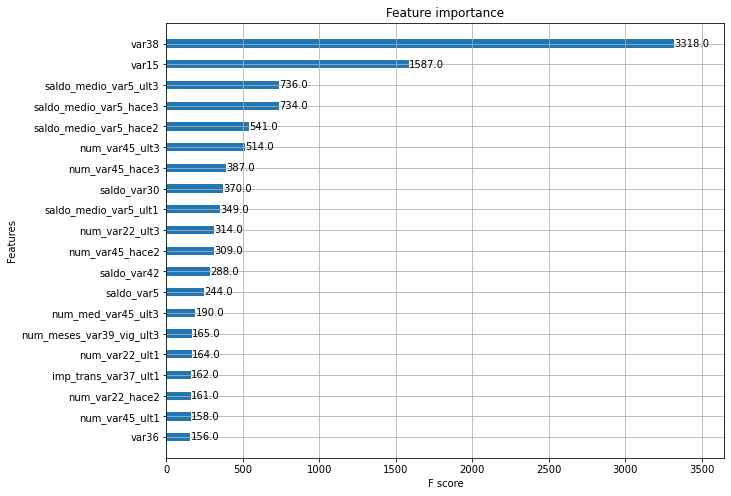

In [30]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1,1,figsize=(10,8))
plot_importance(xgb_clf, ax=ax, max_num_features=20, height=0.4)

## LightGBM 모델 학습과 하이퍼 파라미터 튜닝

In [31]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=500)

eval_set=[(X_tr, y_tr),(X_val, y_val)]
lgbm_clf.fit(X_tr, y_tr, early_stopping_rounds=100, eval_metric='auc',eval_set=eval_set)

lgbm_roc_score = roc_auc_score(y_test,lgbm_dlf.predict_proba(X_test)[:,1])
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[1]	training's auc: 0.82625	training's binary_logloss: 0.15523	valid_1's auc: 0.809814	valid_1's binary_logloss: 0.15774
[2]	training's auc: 0.833899	training's binary_logloss: 0.149581	valid_1's auc: 0.81222	valid_1's binary_logloss: 0.153275
[3]	training's auc: 0.841789	training's binary_logloss: 0.145416	valid_1's auc: 0.814833	valid_1's binary_logloss: 0.149999
[4]	training's auc: 0.847243	training's binary_logloss: 0.14212	valid_1's auc: 0.819406	valid_1's binary_logloss: 0.147524
[5]	training's auc: 0.849589	training's binary_logloss: 0.139438	valid_1's auc: 0.821869	valid_1's binary_logloss: 0.145464
[6]	training's auc: 0.853413	training's binary_logloss: 0.137254	valid_1's auc: 0.820878	valid_1's binary_logloss: 0.143973
[7]	training's auc: 0.85551	training's binary_logloss: 0.1354	valid_1's auc: 0.821815	valid_1's binary_logloss: 0.142746
[8]	training's auc: 0.858698	training's binary_logloss: 0.133561	valid_1's auc: 0.823733	valid_1's binary_logloss: 0.141592
[9]	training's a

[67]	training's auc: 0.923991	training's binary_logloss: 0.105977	valid_1's auc: 0.831669	valid_1's binary_logloss: 0.135537
[68]	training's auc: 0.924656	training's binary_logloss: 0.105802	valid_1's auc: 0.831775	valid_1's binary_logloss: 0.135525
[69]	training's auc: 0.925273	training's binary_logloss: 0.105548	valid_1's auc: 0.831952	valid_1's binary_logloss: 0.135527
[70]	training's auc: 0.925899	training's binary_logloss: 0.105314	valid_1's auc: 0.831659	valid_1's binary_logloss: 0.135611
[71]	training's auc: 0.926827	training's binary_logloss: 0.105054	valid_1's auc: 0.831626	valid_1's binary_logloss: 0.135621
[72]	training's auc: 0.927861	training's binary_logloss: 0.104712	valid_1's auc: 0.831612	valid_1's binary_logloss: 0.135665
[73]	training's auc: 0.928078	training's binary_logloss: 0.104537	valid_1's auc: 0.831395	valid_1's binary_logloss: 0.135709
[74]	training's auc: 0.928329	training's binary_logloss: 0.104353	valid_1's auc: 0.831106	valid_1's binary_logloss: 0.135773


[135]	training's auc: 0.946253	training's binary_logloss: 0.0933204	valid_1's auc: 0.829006	valid_1's binary_logloss: 0.13739
[136]	training's auc: 0.946589	training's binary_logloss: 0.0931143	valid_1's auc: 0.829054	valid_1's binary_logloss: 0.137403
[137]	training's auc: 0.946772	training's binary_logloss: 0.092979	valid_1's auc: 0.828949	valid_1's binary_logloss: 0.137447
[138]	training's auc: 0.946832	training's binary_logloss: 0.0929083	valid_1's auc: 0.828907	valid_1's binary_logloss: 0.137476
[139]	training's auc: 0.947105	training's binary_logloss: 0.0927328	valid_1's auc: 0.829034	valid_1's binary_logloss: 0.137463
[140]	training's auc: 0.94779	training's binary_logloss: 0.0924716	valid_1's auc: 0.829175	valid_1's binary_logloss: 0.137451
[141]	training's auc: 0.948038	training's binary_logloss: 0.0923201	valid_1's auc: 0.829218	valid_1's binary_logloss: 0.137468
[142]	training's auc: 0.948302	training's binary_logloss: 0.0921179	valid_1's auc: 0.829267	valid_1's binary_loglo

NameError: name 'lgbm_dlf' is not defined

In [32]:
lgbm_search_space = {'num_leaves':hp.quniform('num_leaves',32,64,1),
                     'max_depth' : hp.quniform('max_depth',100,160,1),
                     'min_child_samples' : hp.quniform('min_child_samples',60,100,1),
                     'subsample':hp.uniform('subsample',0.7,1),
                     'learning_rate' : hp.uniform('learning_rate',0.01,0.2)}

In [33]:
def objective_func(search_space):
    lgbm_clf = LGBMClassifier(n_estimators=100, num_leaves=int(search_space['num_leaves']),
                             max_depth=int(search_space['max_depth']),
                             min_child_samples=int(search_space['min_child_samples']),
                             subsample=search_space['subsample'],
                             learning_rate=search_space['learning_rate'])
    
    # 3개 k-fold 방식으로 평가된 roc_auc 지표를 담는 list
    roc_auc_list = []
    
    # 3개 k-fold 방식 적용
    kf = KFold(n_splits=3)
    # X_train을 다시 학습과 검증용 데이터로 분리
    for tr_index, val_index in kf.split(X_train):
        # kf.split(X_train)으로 추출된 학습과 검증 index 값으로 학습과 검증 데이터 세트 분리
        X_tr, y_tr = X_train.iloc[tr_index], y_train.iloc[tr_index]
        X_val, y_val = X_train.iloc[val_index], y_train.iloc[val_index]
        
        # early stopping은 30회로 설정하고 추출된 학습과 검증 데이터로 XGBClassifier 학습 수행
        xgb_clf.fit(X_tr, y_tr, early_stopping_rounds=30, eval_metric='auc',
                   eval_set=[(X_tr,y_tr),(X_val,y_val)])
        
        # 1로 예측한 확률값 추출 후 roc auc 계산하고 평균 roc auc 계산을 위해 list에 결과값 담음
        score = roc_auc_score(y_val, xgb_clf.predict_proba(X_val)[:,1])
    
    # 3개 k-fold로 계산된 roc_auc 값의 평균값을 반환하되,
    # HyperOpt는 목적 함수의 최소값을 위한 입력값을 찾으므로 -1을 곱한뒤 반환.
    
    return -1*np.mean(roc_auc_list) 

In [34]:
trials = Trials()

# fmin()함수를 호출. max_evals 지정된 횟수만큼 반복 후 목적 함수의 최솟값을 가지는 최적 입력값 추출
best = fmin(fn=objective_func,
           space=lgbm_search_space,
           algo=tpe.suggest,
           max_evals=50,
           trials=trials, rstate=np.random.default_rng(seed=30))

print('best:', best)

[12:44:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "n_estimator" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.83025	validation_1-auc:0.80096                                                                  
[1]	validation_0-auc:0.84280	validation_1-auc:0.80491                                                                  
[2]	validation_0-auc:0.85453	validation_1-auc:0.80763                                                                  
[3]	validation_0-auc:0.85623	validation_1-auc:0.80952                                                                  
[4]	validation_0-auc:0.86238	validation_1-auc:0.81104                             

[3]	validation_0-auc:0.85508	validation_1-auc:0.82070                                                                  
[4]	validation_0-auc:0.86162	validation_1-auc:0.82195                                                                  
[5]	validation_0-auc:0.86746	validation_1-auc:0.82207                                                                  
[6]	validation_0-auc:0.87761	validation_1-auc:0.82417                                                                  
[7]	validation_0-auc:0.88146	validation_1-auc:0.82378                                                                  
[8]	validation_0-auc:0.88619	validation_1-auc:0.82340                                                                  
[9]	validation_0-auc:0.88932	validation_1-auc:0.82236                                                                  
[10]	validation_0-auc:0.89168	validation_1-auc:0.81943                                                                 
[11]	validation_0-auc:0.89536	validation

[30]	validation_0-auc:0.95187	validation_1-auc:0.82175                                                                 
[31]	validation_0-auc:0.95385	validation_1-auc:0.82224                                                                 
[32]	validation_0-auc:0.95526	validation_1-auc:0.82306                                                                 
[33]	validation_0-auc:0.95585	validation_1-auc:0.82327                                                                 
[34]	validation_0-auc:0.95647	validation_1-auc:0.82474                                                                 
[35]	validation_0-auc:0.95782	validation_1-auc:0.82547                                                                 
[36]	validation_0-auc:0.95928	validation_1-auc:0.82512                                                                 
[37]	validation_0-auc:0.96084	validation_1-auc:0.82390                                                                 
[38]	validation_0-auc:0.96228	validation

[17]	validation_0-auc:0.92101	validation_1-auc:0.82279                                                                 
[18]	validation_0-auc:0.92238	validation_1-auc:0.82156                                                                 
[19]	validation_0-auc:0.92752	validation_1-auc:0.82217                                                                 
[20]	validation_0-auc:0.92866	validation_1-auc:0.82113                                                                 
[21]	validation_0-auc:0.92963	validation_1-auc:0.81854                                                                 
[22]	validation_0-auc:0.93212	validation_1-auc:0.82199                                                                 
[23]	validation_0-auc:0.93721	validation_1-auc:0.82420                                                                 
[24]	validation_0-auc:0.93904	validation_1-auc:0.82476                                                                 
[25]	validation_0-auc:0.94054	validation

[23]	validation_0-auc:0.93703	validation_1-auc:0.82175                                                                 
[24]	validation_0-auc:0.93945	validation_1-auc:0.82223                                                                 
[25]	validation_0-auc:0.94086	validation_1-auc:0.82287                                                                 
[26]	validation_0-auc:0.94398	validation_1-auc:0.82196                                                                 
[27]	validation_0-auc:0.94722	validation_1-auc:0.82327                                                                 
[28]	validation_0-auc:0.94748	validation_1-auc:0.82287                                                                 
[29]	validation_0-auc:0.95022	validation_1-auc:0.82346                                                                 
[30]	validation_0-auc:0.95228	validation_1-auc:0.82206                                                                 
[31]	validation_0-auc:0.95466	validation

[51]	validation_0-auc:0.96759	validation_1-auc:0.82560                                                                 
[52]	validation_0-auc:0.96834	validation_1-auc:0.82528                                                                 
[53]	validation_0-auc:0.96896	validation_1-auc:0.82477                                                                 
[54]	validation_0-auc:0.96908	validation_1-auc:0.82457                                                                 
[55]	validation_0-auc:0.97021	validation_1-auc:0.82453                                                                 
[56]	validation_0-auc:0.97026	validation_1-auc:0.82486                                                                 
[57]	validation_0-auc:0.97056	validation_1-auc:0.82468                                                                 
[58]	validation_0-auc:0.97092	validation_1-auc:0.82530                                                                 
[59]	validation_0-auc:0.97123	validation

[38]	validation_0-auc:0.96014	validation_1-auc:0.81996                                                                 
[39]	validation_0-auc:0.96062	validation_1-auc:0.82020                                                                 
[40]	validation_0-auc:0.96081	validation_1-auc:0.82043                                                                 
[41]	validation_0-auc:0.96155	validation_1-auc:0.81938                                                                 
[42]	validation_0-auc:0.96262	validation_1-auc:0.81957                                                                 
[43]	validation_0-auc:0.96268	validation_1-auc:0.82025                                                                 
[44]	validation_0-auc:0.96333	validation_1-auc:0.82002                                                                 
[45]	validation_0-auc:0.96353	validation_1-auc:0.81989                                                                 
[46]	validation_0-auc:0.96363	validation

[4]	validation_0-auc:0.86627	validation_1-auc:0.81563                                                                  
[5]	validation_0-auc:0.87377	validation_1-auc:0.81742                                                                  
[6]	validation_0-auc:0.87913	validation_1-auc:0.81837                                                                  
[7]	validation_0-auc:0.88708	validation_1-auc:0.82047                                                                  
[8]	validation_0-auc:0.89097	validation_1-auc:0.82347                                                                  
[9]	validation_0-auc:0.89513	validation_1-auc:0.82210                                                                  
[10]	validation_0-auc:0.89635	validation_1-auc:0.81980                                                                 
[11]	validation_0-auc:0.89987	validation_1-auc:0.81622                                                                 
[12]	validation_0-auc:0.90525	validation

[72]	validation_0-auc:0.97431	validation_1-auc:0.82262                                                                 
[73]	validation_0-auc:0.97442	validation_1-auc:0.82262                                                                 
[74]	validation_0-auc:0.97447	validation_1-auc:0.82214                                                                 
[75]	validation_0-auc:0.97506	validation_1-auc:0.82188                                                                 
[76]	validation_0-auc:0.97518	validation_1-auc:0.82178                                                                 
[77]	validation_0-auc:0.97526	validation_1-auc:0.82130                                                                 
[12:46:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "n_estimator" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistake

[0]	validation_0-auc:0.82508	validation_1-auc:0.80332                                                                  
[1]	validation_0-auc:0.84157	validation_1-auc:0.81524                                                                  
[2]	validation_0-auc:0.84889	validation_1-auc:0.82063                                                                  
[3]	validation_0-auc:0.85508	validation_1-auc:0.82070                                                                  
[4]	validation_0-auc:0.86162	validation_1-auc:0.82195                                                                  
[5]	validation_0-auc:0.86746	validation_1-auc:0.82207                                                                  
[6]	validation_0-auc:0.87761	validation_1-auc:0.82417                                                                  
[7]	validation_0-auc:0.88146	validation_1-auc:0.82378                                                                  
[8]	validation_0-auc:0.88619	validation_

[27]	validation_0-auc:0.94622	validation_1-auc:0.82251                                                                 
[28]	validation_0-auc:0.94680	validation_1-auc:0.82202                                                                 
[29]	validation_0-auc:0.94916	validation_1-auc:0.82307                                                                 
[30]	validation_0-auc:0.95187	validation_1-auc:0.82175                                                                 
[31]	validation_0-auc:0.95385	validation_1-auc:0.82224                                                                 
[32]	validation_0-auc:0.95526	validation_1-auc:0.82306                                                                 
[33]	validation_0-auc:0.95585	validation_1-auc:0.82327                                                                 
[34]	validation_0-auc:0.95647	validation_1-auc:0.82474                                                                 
[35]	validation_0-auc:0.95782	validation

[13]	validation_0-auc:0.90590	validation_1-auc:0.82047                                                                 
[14]	validation_0-auc:0.90780	validation_1-auc:0.82103                                                                 
[15]	validation_0-auc:0.91203	validation_1-auc:0.81908                                                                 
[16]	validation_0-auc:0.91536	validation_1-auc:0.82163                                                                 
[17]	validation_0-auc:0.92101	validation_1-auc:0.82279                                                                 
[18]	validation_0-auc:0.92238	validation_1-auc:0.82156                                                                 
[19]	validation_0-auc:0.92752	validation_1-auc:0.82217                                                                 
[20]	validation_0-auc:0.92866	validation_1-auc:0.82113                                                                 
[21]	validation_0-auc:0.92963	validation

[20]	validation_0-auc:0.92936	validation_1-auc:0.82066                                                                 
[21]	validation_0-auc:0.92951	validation_1-auc:0.82037                                                                 
[22]	validation_0-auc:0.93285	validation_1-auc:0.82131                                                                 
[23]	validation_0-auc:0.93703	validation_1-auc:0.82175                                                                 
[24]	validation_0-auc:0.93945	validation_1-auc:0.82223                                                                 
[25]	validation_0-auc:0.94086	validation_1-auc:0.82287                                                                 
[26]	validation_0-auc:0.94398	validation_1-auc:0.82196                                                                 
[27]	validation_0-auc:0.94722	validation_1-auc:0.82327                                                                 
[28]	validation_0-auc:0.94748	validation

[48]	validation_0-auc:0.96602	validation_1-auc:0.82565                                                                 
[49]	validation_0-auc:0.96679	validation_1-auc:0.82565                                                                 
[50]	validation_0-auc:0.96710	validation_1-auc:0.82541                                                                 
[51]	validation_0-auc:0.96759	validation_1-auc:0.82560                                                                 
[52]	validation_0-auc:0.96834	validation_1-auc:0.82528                                                                 
[53]	validation_0-auc:0.96896	validation_1-auc:0.82477                                                                 
[54]	validation_0-auc:0.96908	validation_1-auc:0.82457                                                                 
[55]	validation_0-auc:0.97021	validation_1-auc:0.82453                                                                 
[56]	validation_0-auc:0.97026	validation

[34]	validation_0-auc:0.95624	validation_1-auc:0.82230                                                                 
[35]	validation_0-auc:0.95712	validation_1-auc:0.82200                                                                 
[36]	validation_0-auc:0.95846	validation_1-auc:0.82143                                                                 
[37]	validation_0-auc:0.95975	validation_1-auc:0.82065                                                                 
[38]	validation_0-auc:0.96014	validation_1-auc:0.81996                                                                 
[39]	validation_0-auc:0.96062	validation_1-auc:0.82020                                                                 
[40]	validation_0-auc:0.96081	validation_1-auc:0.82043                                                                 
[41]	validation_0-auc:0.96155	validation_1-auc:0.81938                                                                 
[42]	validation_0-auc:0.96262	validation

[0]	validation_0-auc:0.83757	validation_1-auc:0.80799                                                                  
[1]	validation_0-auc:0.84454	validation_1-auc:0.81213                                                                  
[2]	validation_0-auc:0.85136	validation_1-auc:0.81730                                                                  
[3]	validation_0-auc:0.85657	validation_1-auc:0.81529                                                                  
[4]	validation_0-auc:0.86627	validation_1-auc:0.81563                                                                  
[5]	validation_0-auc:0.87377	validation_1-auc:0.81742                                                                  
[6]	validation_0-auc:0.87913	validation_1-auc:0.81837                                                                  
[7]	validation_0-auc:0.88708	validation_1-auc:0.82047                                                                  
[8]	validation_0-auc:0.89097	validation_

[68]	validation_0-auc:0.97378	validation_1-auc:0.82273                                                                 
[69]	validation_0-auc:0.97391	validation_1-auc:0.82282                                                                 
[70]	validation_0-auc:0.97397	validation_1-auc:0.82254                                                                 
[71]	validation_0-auc:0.97400	validation_1-auc:0.82245                                                                 
[72]	validation_0-auc:0.97431	validation_1-auc:0.82262                                                                 
[73]	validation_0-auc:0.97442	validation_1-auc:0.82262                                                                 
[74]	validation_0-auc:0.97447	validation_1-auc:0.82214                                                                 
[75]	validation_0-auc:0.97506	validation_1-auc:0.82188                                                                 
[76]	validation_0-auc:0.97518	validation

[54]	validation_0-auc:0.96626	validation_1-auc:0.81854                                                                 
[55]	validation_0-auc:0.96693	validation_1-auc:0.81842                                                                 
[56]	validation_0-auc:0.96691	validation_1-auc:0.81800                                                                 
[12:48:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "n_estimator" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.82508	validation_1-auc:0.80332                                                                  
[1]	validation_0-auc:0.84157	validation_1-auc:0.81524                             

[21]	validation_0-auc:0.93271	validation_1-auc:0.81759                                                                 
[22]	validation_0-auc:0.93421	validation_1-auc:0.81983                                                                 
[23]	validation_0-auc:0.93856	validation_1-auc:0.82029                                                                 
[24]	validation_0-auc:0.94059	validation_1-auc:0.82126                                                                 
[25]	validation_0-auc:0.94114	validation_1-auc:0.82294                                                                 
[26]	validation_0-auc:0.94330	validation_1-auc:0.82222                                                                 
[27]	validation_0-auc:0.94622	validation_1-auc:0.82251                                                                 
[28]	validation_0-auc:0.94680	validation_1-auc:0.82202                                                                 
[29]	validation_0-auc:0.94916	validation

[7]	validation_0-auc:0.88018	validation_1-auc:0.82054                                                                  
[8]	validation_0-auc:0.88586	validation_1-auc:0.82100                                                                  
[9]	validation_0-auc:0.88824	validation_1-auc:0.81807                                                                  
[10]	validation_0-auc:0.89083	validation_1-auc:0.81823                                                                 
[11]	validation_0-auc:0.89415	validation_1-auc:0.81571                                                                 
[12]	validation_0-auc:0.90013	validation_1-auc:0.82045                                                                 
[13]	validation_0-auc:0.90590	validation_1-auc:0.82047                                                                 
[14]	validation_0-auc:0.90780	validation_1-auc:0.82103                                                                 
[15]	validation_0-auc:0.91203	validation

[13]	validation_0-auc:0.90706	validation_1-auc:0.82174                                                                 
[14]	validation_0-auc:0.90852	validation_1-auc:0.82176                                                                 
[15]	validation_0-auc:0.91326	validation_1-auc:0.82026                                                                 
[16]	validation_0-auc:0.91753	validation_1-auc:0.82060                                                                 
[17]	validation_0-auc:0.92253	validation_1-auc:0.82189                                                                 
[18]	validation_0-auc:0.92210	validation_1-auc:0.82051                                                                 
[19]	validation_0-auc:0.92836	validation_1-auc:0.82249                                                                 
[20]	validation_0-auc:0.92936	validation_1-auc:0.82066                                                                 
[21]	validation_0-auc:0.92951	validation

[41]	validation_0-auc:0.96370	validation_1-auc:0.82382                                                                 
[42]	validation_0-auc:0.96447	validation_1-auc:0.82367                                                                 
[43]	validation_0-auc:0.96467	validation_1-auc:0.82424                                                                 
[44]	validation_0-auc:0.96525	validation_1-auc:0.82432                                                                 
[45]	validation_0-auc:0.96516	validation_1-auc:0.82527                                                                 
[46]	validation_0-auc:0.96526	validation_1-auc:0.82549                                                                 
[47]	validation_0-auc:0.96571	validation_1-auc:0.82572                                                                 
[48]	validation_0-auc:0.96602	validation_1-auc:0.82565                                                                 
[49]	validation_0-auc:0.96679	validation

[28]	validation_0-auc:0.94725	validation_1-auc:0.82422                                                                 
[29]	validation_0-auc:0.94925	validation_1-auc:0.82481                                                                 
[30]	validation_0-auc:0.95169	validation_1-auc:0.82308                                                                 
[31]	validation_0-auc:0.95354	validation_1-auc:0.82289                                                                 
[32]	validation_0-auc:0.95483	validation_1-auc:0.82262                                                                 
[33]	validation_0-auc:0.95557	validation_1-auc:0.82258                                                                 
[34]	validation_0-auc:0.95624	validation_1-auc:0.82230                                                                 
[35]	validation_0-auc:0.95712	validation_1-auc:0.82200                                                                 
[36]	validation_0-auc:0.95846	validation

[34]	validation_0-auc:0.95782	validation_1-auc:0.82378                                                                 
[35]	validation_0-auc:0.95904	validation_1-auc:0.82357                                                                 
[12:49:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "n_estimator" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.83757	validation_1-auc:0.80799                                                                  
[1]	validation_0-auc:0.84454	validation_1-auc:0.81213                                                                  
[2]	validation_0-auc:0.85136	validation_1-auc:0.81730                             

[62]	validation_0-auc:0.97205	validation_1-auc:0.82353                                                                 
[63]	validation_0-auc:0.97243	validation_1-auc:0.82361                                                                 
[64]	validation_0-auc:0.97323	validation_1-auc:0.82359                                                                 
[65]	validation_0-auc:0.97327	validation_1-auc:0.82343                                                                 
[66]	validation_0-auc:0.97342	validation_1-auc:0.82332                                                                 
[67]	validation_0-auc:0.97371	validation_1-auc:0.82303                                                                 
[68]	validation_0-auc:0.97378	validation_1-auc:0.82273                                                                 
[69]	validation_0-auc:0.97391	validation_1-auc:0.82282                                                                 
[70]	validation_0-auc:0.97397	validation

[48]	validation_0-auc:0.96425	validation_1-auc:0.81940                                                                 
[49]	validation_0-auc:0.96478	validation_1-auc:0.81904                                                                 
[50]	validation_0-auc:0.96520	validation_1-auc:0.81903                                                                 
[51]	validation_0-auc:0.96554	validation_1-auc:0.81866                                                                 
[52]	validation_0-auc:0.96586	validation_1-auc:0.81872                                                                 
[53]	validation_0-auc:0.96616	validation_1-auc:0.81861                                                                 
[54]	validation_0-auc:0.96626	validation_1-auc:0.81854                                                                 
[55]	validation_0-auc:0.96693	validation_1-auc:0.81842                                                                 
[56]	validation_0-auc:0.96691	validation

[14]	validation_0-auc:0.91217	validation_1-auc:0.82175                                                                 
[15]	validation_0-auc:0.91571	validation_1-auc:0.81859                                                                 
[16]	validation_0-auc:0.91845	validation_1-auc:0.81927                                                                 
[17]	validation_0-auc:0.92296	validation_1-auc:0.82076                                                                 
[18]	validation_0-auc:0.92354	validation_1-auc:0.81828                                                                 
[19]	validation_0-auc:0.92968	validation_1-auc:0.81991                                                                 
[20]	validation_0-auc:0.93124	validation_1-auc:0.81923                                                                 
[21]	validation_0-auc:0.93271	validation_1-auc:0.81759                                                                 
[22]	validation_0-auc:0.93421	validation

[1]	validation_0-auc:0.84280	validation_1-auc:0.80491                                                                  
[2]	validation_0-auc:0.85453	validation_1-auc:0.80763                                                                  
[3]	validation_0-auc:0.85623	validation_1-auc:0.80952                                                                  
[4]	validation_0-auc:0.86238	validation_1-auc:0.81104                                                                  
[5]	validation_0-auc:0.86861	validation_1-auc:0.81329                                                                  
[6]	validation_0-auc:0.87603	validation_1-auc:0.81863                                                                  
[7]	validation_0-auc:0.88018	validation_1-auc:0.82054                                                                  
[8]	validation_0-auc:0.88586	validation_1-auc:0.82100                                                                  
[9]	validation_0-auc:0.88824	validation_

[8]	validation_0-auc:0.88619	validation_1-auc:0.82340                                                                  
[9]	validation_0-auc:0.88932	validation_1-auc:0.82236                                                                  
[10]	validation_0-auc:0.89168	validation_1-auc:0.81943                                                                 
[11]	validation_0-auc:0.89536	validation_1-auc:0.81763                                                                 
[12]	validation_0-auc:0.90181	validation_1-auc:0.81990                                                                 
[13]	validation_0-auc:0.90706	validation_1-auc:0.82174                                                                 
[14]	validation_0-auc:0.90852	validation_1-auc:0.82176                                                                 
[15]	validation_0-auc:0.91326	validation_1-auc:0.82026                                                                 
[16]	validation_0-auc:0.91753	validation

[36]	validation_0-auc:0.95928	validation_1-auc:0.82512                                                                 
[37]	validation_0-auc:0.96084	validation_1-auc:0.82390                                                                 
[38]	validation_0-auc:0.96228	validation_1-auc:0.82376                                                                 
[39]	validation_0-auc:0.96250	validation_1-auc:0.82472                                                                 
[40]	validation_0-auc:0.96291	validation_1-auc:0.82454                                                                 
[41]	validation_0-auc:0.96370	validation_1-auc:0.82382                                                                 
[42]	validation_0-auc:0.96447	validation_1-auc:0.82367                                                                 
[43]	validation_0-auc:0.96467	validation_1-auc:0.82424                                                                 
[44]	validation_0-auc:0.96525	validation

[22]	validation_0-auc:0.93212	validation_1-auc:0.82199                                                                 
[23]	validation_0-auc:0.93721	validation_1-auc:0.82420                                                                 
[24]	validation_0-auc:0.93904	validation_1-auc:0.82476                                                                 
[25]	validation_0-auc:0.94054	validation_1-auc:0.82553                                                                 
[26]	validation_0-auc:0.94448	validation_1-auc:0.82494                                                                 
[27]	validation_0-auc:0.94681	validation_1-auc:0.82566                                                                 
[28]	validation_0-auc:0.94725	validation_1-auc:0.82422                                                                 
[29]	validation_0-auc:0.94925	validation_1-auc:0.82481                                                                 
[30]	validation_0-auc:0.95169	validation

[29]	validation_0-auc:0.95022	validation_1-auc:0.82346                                                                 
[30]	validation_0-auc:0.95228	validation_1-auc:0.82206                                                                 
[31]	validation_0-auc:0.95466	validation_1-auc:0.82310                                                                 
[32]	validation_0-auc:0.95613	validation_1-auc:0.82293                                                                 
[33]	validation_0-auc:0.95648	validation_1-auc:0.82386                                                                 
[34]	validation_0-auc:0.95782	validation_1-auc:0.82378                                                                 
[35]	validation_0-auc:0.95904	validation_1-auc:0.82357                                                                 
[12:51:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "n_estimator" } might not 

[57]	validation_0-auc:0.97056	validation_1-auc:0.82468                                                                 
[58]	validation_0-auc:0.97092	validation_1-auc:0.82530                                                                 
[59]	validation_0-auc:0.97123	validation_1-auc:0.82520                                                                 
[60]	validation_0-auc:0.97134	validation_1-auc:0.82453                                                                 
[61]	validation_0-auc:0.97174	validation_1-auc:0.82409                                                                 
[62]	validation_0-auc:0.97205	validation_1-auc:0.82353                                                                 
[63]	validation_0-auc:0.97243	validation_1-auc:0.82361                                                                 
[64]	validation_0-auc:0.97323	validation_1-auc:0.82359                                                                 
[65]	validation_0-auc:0.97327	validation

[44]	validation_0-auc:0.96333	validation_1-auc:0.82002                                                                 
[45]	validation_0-auc:0.96353	validation_1-auc:0.81989                                                                 
[46]	validation_0-auc:0.96363	validation_1-auc:0.81967                                                                 
[47]	validation_0-auc:0.96407	validation_1-auc:0.81914                                                                 
[48]	validation_0-auc:0.96425	validation_1-auc:0.81940                                                                 
[49]	validation_0-auc:0.96478	validation_1-auc:0.81904                                                                 
[50]	validation_0-auc:0.96520	validation_1-auc:0.81903                                                                 
[51]	validation_0-auc:0.96554	validation_1-auc:0.81866                                                                 
[52]	validation_0-auc:0.96586	validation

[10]	validation_0-auc:0.89635	validation_1-auc:0.81980                                                                 
[11]	validation_0-auc:0.89987	validation_1-auc:0.81622                                                                 
[12]	validation_0-auc:0.90525	validation_1-auc:0.81929                                                                 
[13]	validation_0-auc:0.91110	validation_1-auc:0.82027                                                                 
[14]	validation_0-auc:0.91217	validation_1-auc:0.82175                                                                 
[15]	validation_0-auc:0.91571	validation_1-auc:0.81859                                                                 
[16]	validation_0-auc:0.91845	validation_1-auc:0.81927                                                                 
[17]	validation_0-auc:0.92296	validation_1-auc:0.82076                                                                 
[18]	validation_0-auc:0.92354	validation

[12:52:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "n_estimator" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.83025	validation_1-auc:0.80096                                                                  
[1]	validation_0-auc:0.84280	validation_1-auc:0.80491                                                                  
[2]	validation_0-auc:0.85453	validation_1-auc:0.80763                                                                  
[3]	validation_0-auc:0.85623	validation_1-auc:0.80952                                                                  
[4]	validation_0-auc:0.86238	validation_1-auc:0.81104                             

[2]	validation_0-auc:0.84889	validation_1-auc:0.82063                                                                  
[3]	validation_0-auc:0.85508	validation_1-auc:0.82070                                                                  
[4]	validation_0-auc:0.86162	validation_1-auc:0.82195                                                                  
[5]	validation_0-auc:0.86746	validation_1-auc:0.82207                                                                  
[6]	validation_0-auc:0.87761	validation_1-auc:0.82417                                                                  
[7]	validation_0-auc:0.88146	validation_1-auc:0.82378                                                                  
[8]	validation_0-auc:0.88619	validation_1-auc:0.82340                                                                  
[9]	validation_0-auc:0.88932	validation_1-auc:0.82236                                                                  
[10]	validation_0-auc:0.89168	validation

[29]	validation_0-auc:0.94916	validation_1-auc:0.82307                                                                 
[30]	validation_0-auc:0.95187	validation_1-auc:0.82175                                                                 
[31]	validation_0-auc:0.95385	validation_1-auc:0.82224                                                                 
[32]	validation_0-auc:0.95526	validation_1-auc:0.82306                                                                 
[33]	validation_0-auc:0.95585	validation_1-auc:0.82327                                                                 
[34]	validation_0-auc:0.95647	validation_1-auc:0.82474                                                                 
[35]	validation_0-auc:0.95782	validation_1-auc:0.82547                                                                 
[36]	validation_0-auc:0.95928	validation_1-auc:0.82512                                                                 
[37]	validation_0-auc:0.96084	validation

[16]	validation_0-auc:0.91536	validation_1-auc:0.82163                                                                 
[17]	validation_0-auc:0.92101	validation_1-auc:0.82279                                                                 
[18]	validation_0-auc:0.92238	validation_1-auc:0.82156                                                                 
[19]	validation_0-auc:0.92752	validation_1-auc:0.82217                                                                 
[20]	validation_0-auc:0.92866	validation_1-auc:0.82113                                                                 
[21]	validation_0-auc:0.92963	validation_1-auc:0.81854                                                                 
[22]	validation_0-auc:0.93212	validation_1-auc:0.82199                                                                 
[23]	validation_0-auc:0.93721	validation_1-auc:0.82420                                                                 
[24]	validation_0-auc:0.93904	validation

[22]	validation_0-auc:0.93285	validation_1-auc:0.82131                                                                 
[23]	validation_0-auc:0.93703	validation_1-auc:0.82175                                                                 
[24]	validation_0-auc:0.93945	validation_1-auc:0.82223                                                                 
[25]	validation_0-auc:0.94086	validation_1-auc:0.82287                                                                 
[26]	validation_0-auc:0.94398	validation_1-auc:0.82196                                                                 
[27]	validation_0-auc:0.94722	validation_1-auc:0.82327                                                                 
[28]	validation_0-auc:0.94748	validation_1-auc:0.82287                                                                 
[29]	validation_0-auc:0.95022	validation_1-auc:0.82346                                                                 
[30]	validation_0-auc:0.95228	validation

[49]	validation_0-auc:0.96679	validation_1-auc:0.82565                                                                 
[50]	validation_0-auc:0.96710	validation_1-auc:0.82541                                                                 
[51]	validation_0-auc:0.96759	validation_1-auc:0.82560                                                                 
[52]	validation_0-auc:0.96834	validation_1-auc:0.82528                                                                 
[53]	validation_0-auc:0.96896	validation_1-auc:0.82477                                                                 
[54]	validation_0-auc:0.96908	validation_1-auc:0.82457                                                                 
[55]	validation_0-auc:0.97021	validation_1-auc:0.82453                                                                 
[56]	validation_0-auc:0.97026	validation_1-auc:0.82486                                                                 
[57]	validation_0-auc:0.97056	validation

[35]	validation_0-auc:0.95712	validation_1-auc:0.82200                                                                 
[36]	validation_0-auc:0.95846	validation_1-auc:0.82143                                                                 
[37]	validation_0-auc:0.95975	validation_1-auc:0.82065                                                                 
[38]	validation_0-auc:0.96014	validation_1-auc:0.81996                                                                 
[39]	validation_0-auc:0.96062	validation_1-auc:0.82020                                                                 
[40]	validation_0-auc:0.96081	validation_1-auc:0.82043                                                                 
[41]	validation_0-auc:0.96155	validation_1-auc:0.81938                                                                 
[42]	validation_0-auc:0.96262	validation_1-auc:0.81957                                                                 
[43]	validation_0-auc:0.96268	validation

[2]	validation_0-auc:0.85136	validation_1-auc:0.81730                                                                  
[3]	validation_0-auc:0.85657	validation_1-auc:0.81529                                                                  
[4]	validation_0-auc:0.86627	validation_1-auc:0.81563                                                                  
[5]	validation_0-auc:0.87377	validation_1-auc:0.81742                                                                  
[6]	validation_0-auc:0.87913	validation_1-auc:0.81837                                                                  
[7]	validation_0-auc:0.88708	validation_1-auc:0.82047                                                                  
[8]	validation_0-auc:0.89097	validation_1-auc:0.82347                                                                  
[9]	validation_0-auc:0.89513	validation_1-auc:0.82210                                                                  
[10]	validation_0-auc:0.89635	validation

[70]	validation_0-auc:0.97397	validation_1-auc:0.82254                                                                 
[71]	validation_0-auc:0.97400	validation_1-auc:0.82245                                                                 
[72]	validation_0-auc:0.97431	validation_1-auc:0.82262                                                                 
[73]	validation_0-auc:0.97442	validation_1-auc:0.82262                                                                 
[74]	validation_0-auc:0.97447	validation_1-auc:0.82214                                                                 
[75]	validation_0-auc:0.97506	validation_1-auc:0.82188                                                                 
[76]	validation_0-auc:0.97518	validation_1-auc:0.82178                                                                 
[77]	validation_0-auc:0.97526	validation_1-auc:0.82130                                                                 
[12:53:56] WARNING: C:/Users/Administrat

[56]	validation_0-auc:0.96691	validation_1-auc:0.81800                                                                 
[57]	validation_0-auc:0.96711	validation_1-auc:0.81751                                                                 
[12:54:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "n_estimator" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.82508	validation_1-auc:0.80332                                                                  
[1]	validation_0-auc:0.84157	validation_1-auc:0.81524                                                                  
[2]	validation_0-auc:0.84889	validation_1-auc:0.82063                             

[21]	validation_0-auc:0.93271	validation_1-auc:0.81759                                                                 
[22]	validation_0-auc:0.93421	validation_1-auc:0.81983                                                                 
[23]	validation_0-auc:0.93856	validation_1-auc:0.82029                                                                 
[24]	validation_0-auc:0.94059	validation_1-auc:0.82126                                                                 
[25]	validation_0-auc:0.94114	validation_1-auc:0.82294                                                                 
[26]	validation_0-auc:0.94330	validation_1-auc:0.82222                                                                 
[27]	validation_0-auc:0.94622	validation_1-auc:0.82251                                                                 
[28]	validation_0-auc:0.94680	validation_1-auc:0.82202                                                                 
[29]	validation_0-auc:0.94916	validation

[7]	validation_0-auc:0.88018	validation_1-auc:0.82054                                                                  
[8]	validation_0-auc:0.88586	validation_1-auc:0.82100                                                                  
[9]	validation_0-auc:0.88824	validation_1-auc:0.81807                                                                  
[10]	validation_0-auc:0.89083	validation_1-auc:0.81823                                                                 
[11]	validation_0-auc:0.89415	validation_1-auc:0.81571                                                                 
[12]	validation_0-auc:0.90013	validation_1-auc:0.82045                                                                 
[13]	validation_0-auc:0.90590	validation_1-auc:0.82047                                                                 
[14]	validation_0-auc:0.90780	validation_1-auc:0.82103                                                                 
[15]	validation_0-auc:0.91203	validation

[13]	validation_0-auc:0.90706	validation_1-auc:0.82174                                                                 
[14]	validation_0-auc:0.90852	validation_1-auc:0.82176                                                                 
[15]	validation_0-auc:0.91326	validation_1-auc:0.82026                                                                 
[16]	validation_0-auc:0.91753	validation_1-auc:0.82060                                                                 
[17]	validation_0-auc:0.92253	validation_1-auc:0.82189                                                                 
[18]	validation_0-auc:0.92210	validation_1-auc:0.82051                                                                 
[19]	validation_0-auc:0.92836	validation_1-auc:0.82249                                                                 
[20]	validation_0-auc:0.92936	validation_1-auc:0.82066                                                                 
[21]	validation_0-auc:0.92951	validation

[41]	validation_0-auc:0.96370	validation_1-auc:0.82382                                                                 
[42]	validation_0-auc:0.96447	validation_1-auc:0.82367                                                                 
[43]	validation_0-auc:0.96467	validation_1-auc:0.82424                                                                 
[44]	validation_0-auc:0.96525	validation_1-auc:0.82432                                                                 
[45]	validation_0-auc:0.96516	validation_1-auc:0.82527                                                                 
[46]	validation_0-auc:0.96526	validation_1-auc:0.82549                                                                 
[47]	validation_0-auc:0.96571	validation_1-auc:0.82572                                                                 
[48]	validation_0-auc:0.96602	validation_1-auc:0.82565                                                                 
[49]	validation_0-auc:0.96679	validation

[28]	validation_0-auc:0.94725	validation_1-auc:0.82422                                                                 
[29]	validation_0-auc:0.94925	validation_1-auc:0.82481                                                                 
[30]	validation_0-auc:0.95169	validation_1-auc:0.82308                                                                 
[31]	validation_0-auc:0.95354	validation_1-auc:0.82289                                                                 
[32]	validation_0-auc:0.95483	validation_1-auc:0.82262                                                                 
[33]	validation_0-auc:0.95557	validation_1-auc:0.82258                                                                 
[34]	validation_0-auc:0.95624	validation_1-auc:0.82230                                                                 
[35]	validation_0-auc:0.95712	validation_1-auc:0.82200                                                                 
[36]	validation_0-auc:0.95846	validation

[35]	validation_0-auc:0.95904	validation_1-auc:0.82357                                                                 
[36]	validation_0-auc:0.96035	validation_1-auc:0.82277                                                                 
[12:55:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "n_estimator" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.83757	validation_1-auc:0.80799                                                                  
[1]	validation_0-auc:0.84454	validation_1-auc:0.81213                                                                  
[2]	validation_0-auc:0.85136	validation_1-auc:0.81730                             

[62]	validation_0-auc:0.97205	validation_1-auc:0.82353                                                                 
[63]	validation_0-auc:0.97243	validation_1-auc:0.82361                                                                 
[64]	validation_0-auc:0.97323	validation_1-auc:0.82359                                                                 
[65]	validation_0-auc:0.97327	validation_1-auc:0.82343                                                                 
[66]	validation_0-auc:0.97342	validation_1-auc:0.82332                                                                 
[67]	validation_0-auc:0.97371	validation_1-auc:0.82303                                                                 
[68]	validation_0-auc:0.97378	validation_1-auc:0.82273                                                                 
[69]	validation_0-auc:0.97391	validation_1-auc:0.82282                                                                 
[70]	validation_0-auc:0.97397	validation

[48]	validation_0-auc:0.96425	validation_1-auc:0.81940                                                                 
[49]	validation_0-auc:0.96478	validation_1-auc:0.81904                                                                 
[50]	validation_0-auc:0.96520	validation_1-auc:0.81903                                                                 
[51]	validation_0-auc:0.96554	validation_1-auc:0.81866                                                                 
[52]	validation_0-auc:0.96586	validation_1-auc:0.81872                                                                 
[53]	validation_0-auc:0.96616	validation_1-auc:0.81861                                                                 
[54]	validation_0-auc:0.96626	validation_1-auc:0.81854                                                                 
[55]	validation_0-auc:0.96693	validation_1-auc:0.81842                                                                 
[56]	validation_0-auc:0.96691	validation

[14]	validation_0-auc:0.91217	validation_1-auc:0.82175                                                                 
[15]	validation_0-auc:0.91571	validation_1-auc:0.81859                                                                 
[16]	validation_0-auc:0.91845	validation_1-auc:0.81927                                                                 
[17]	validation_0-auc:0.92296	validation_1-auc:0.82076                                                                 
[18]	validation_0-auc:0.92354	validation_1-auc:0.81828                                                                 
[19]	validation_0-auc:0.92968	validation_1-auc:0.81991                                                                 
[20]	validation_0-auc:0.93124	validation_1-auc:0.81923                                                                 
[21]	validation_0-auc:0.93271	validation_1-auc:0.81759                                                                 
[22]	validation_0-auc:0.93421	validation

[0]	validation_0-auc:0.83025	validation_1-auc:0.80096                                                                  
[1]	validation_0-auc:0.84280	validation_1-auc:0.80491                                                                  
[2]	validation_0-auc:0.85453	validation_1-auc:0.80763                                                                  
[3]	validation_0-auc:0.85623	validation_1-auc:0.80952                                                                  
[4]	validation_0-auc:0.86238	validation_1-auc:0.81104                                                                  
[5]	validation_0-auc:0.86861	validation_1-auc:0.81329                                                                  
[6]	validation_0-auc:0.87603	validation_1-auc:0.81863                                                                  
[7]	validation_0-auc:0.88018	validation_1-auc:0.82054                                                                  
[8]	validation_0-auc:0.88586	validation_

[7]	validation_0-auc:0.88146	validation_1-auc:0.82378                                                                  
[8]	validation_0-auc:0.88619	validation_1-auc:0.82340                                                                  
[9]	validation_0-auc:0.88932	validation_1-auc:0.82236                                                                  
[10]	validation_0-auc:0.89168	validation_1-auc:0.81943                                                                 
[11]	validation_0-auc:0.89536	validation_1-auc:0.81763                                                                 
[12]	validation_0-auc:0.90181	validation_1-auc:0.81990                                                                 
[13]	validation_0-auc:0.90706	validation_1-auc:0.82174                                                                 
[14]	validation_0-auc:0.90852	validation_1-auc:0.82176                                                                 
[15]	validation_0-auc:0.91326	validation

[34]	validation_0-auc:0.95647	validation_1-auc:0.82474                                                                 
[35]	validation_0-auc:0.95782	validation_1-auc:0.82547                                                                 
[36]	validation_0-auc:0.95928	validation_1-auc:0.82512                                                                 
[37]	validation_0-auc:0.96084	validation_1-auc:0.82390                                                                 
[38]	validation_0-auc:0.96228	validation_1-auc:0.82376                                                                 
[39]	validation_0-auc:0.96250	validation_1-auc:0.82472                                                                 
[40]	validation_0-auc:0.96291	validation_1-auc:0.82454                                                                 
[41]	validation_0-auc:0.96370	validation_1-auc:0.82382                                                                 
[42]	validation_0-auc:0.96447	validation

[20]	validation_0-auc:0.92866	validation_1-auc:0.82113                                                                 
[21]	validation_0-auc:0.92963	validation_1-auc:0.81854                                                                 
[22]	validation_0-auc:0.93212	validation_1-auc:0.82199                                                                 
[23]	validation_0-auc:0.93721	validation_1-auc:0.82420                                                                 
[24]	validation_0-auc:0.93904	validation_1-auc:0.82476                                                                 
[25]	validation_0-auc:0.94054	validation_1-auc:0.82553                                                                 
[26]	validation_0-auc:0.94448	validation_1-auc:0.82494                                                                 
[27]	validation_0-auc:0.94681	validation_1-auc:0.82566                                                                 
[28]	validation_0-auc:0.94725	validation

[26]	validation_0-auc:0.94398	validation_1-auc:0.82196                                                                 
[27]	validation_0-auc:0.94722	validation_1-auc:0.82327                                                                 
[28]	validation_0-auc:0.94748	validation_1-auc:0.82287                                                                 
[29]	validation_0-auc:0.95022	validation_1-auc:0.82346                                                                 
[30]	validation_0-auc:0.95228	validation_1-auc:0.82206                                                                 
[31]	validation_0-auc:0.95466	validation_1-auc:0.82310                                                                 
[32]	validation_0-auc:0.95613	validation_1-auc:0.82293                                                                 
[33]	validation_0-auc:0.95648	validation_1-auc:0.82386                                                                 
[34]	validation_0-auc:0.95782	validation

[53]	validation_0-auc:0.96896	validation_1-auc:0.82477                                                                 
[54]	validation_0-auc:0.96908	validation_1-auc:0.82457                                                                 
[55]	validation_0-auc:0.97021	validation_1-auc:0.82453                                                                 
[56]	validation_0-auc:0.97026	validation_1-auc:0.82486                                                                 
[57]	validation_0-auc:0.97056	validation_1-auc:0.82468                                                                 
[58]	validation_0-auc:0.97092	validation_1-auc:0.82530                                                                 
[59]	validation_0-auc:0.97123	validation_1-auc:0.82520                                                                 
[60]	validation_0-auc:0.97134	validation_1-auc:0.82453                                                                 
[61]	validation_0-auc:0.97174	validation

[39]	validation_0-auc:0.96062	validation_1-auc:0.82020                                                                 
[40]	validation_0-auc:0.96081	validation_1-auc:0.82043                                                                 
[41]	validation_0-auc:0.96155	validation_1-auc:0.81938                                                                 
[42]	validation_0-auc:0.96262	validation_1-auc:0.81957                                                                 
[43]	validation_0-auc:0.96268	validation_1-auc:0.82025                                                                 
[44]	validation_0-auc:0.96333	validation_1-auc:0.82002                                                                 
[45]	validation_0-auc:0.96353	validation_1-auc:0.81989                                                                 
[46]	validation_0-auc:0.96363	validation_1-auc:0.81967                                                                 
[47]	validation_0-auc:0.96407	validation

[4]	validation_0-auc:0.86627	validation_1-auc:0.81563                                                                  
[5]	validation_0-auc:0.87377	validation_1-auc:0.81742                                                                  
[6]	validation_0-auc:0.87913	validation_1-auc:0.81837                                                                  
[7]	validation_0-auc:0.88708	validation_1-auc:0.82047                                                                  
[8]	validation_0-auc:0.89097	validation_1-auc:0.82347                                                                  
[9]	validation_0-auc:0.89513	validation_1-auc:0.82210                                                                  
[10]	validation_0-auc:0.89635	validation_1-auc:0.81980                                                                 
[11]	validation_0-auc:0.89987	validation_1-auc:0.81622                                                                 
[12]	validation_0-auc:0.90525	validation

[72]	validation_0-auc:0.97431	validation_1-auc:0.82262                                                                 
[73]	validation_0-auc:0.97442	validation_1-auc:0.82262                                                                 
[74]	validation_0-auc:0.97447	validation_1-auc:0.82214                                                                 
[75]	validation_0-auc:0.97506	validation_1-auc:0.82188                                                                 
[76]	validation_0-auc:0.97518	validation_1-auc:0.82178                                                                 
[77]	validation_0-auc:0.97526	validation_1-auc:0.82130                                                                 
[12:57:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "n_estimator" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistake

[12:58:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "n_estimator" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.82508	validation_1-auc:0.80332                                                                  
[1]	validation_0-auc:0.84157	validation_1-auc:0.81524                                                                  
[2]	validation_0-auc:0.84889	validation_1-auc:0.82063                                                                  
[3]	validation_0-auc:0.85508	validation_1-auc:0.82070                                                                  
[4]	validation_0-auc:0.86162	validation_1-auc:0.82195                             

[24]	validation_0-auc:0.94059	validation_1-auc:0.82126                                                                 
[25]	validation_0-auc:0.94114	validation_1-auc:0.82294                                                                 
[26]	validation_0-auc:0.94330	validation_1-auc:0.82222                                                                 
[27]	validation_0-auc:0.94622	validation_1-auc:0.82251                                                                 
[28]	validation_0-auc:0.94680	validation_1-auc:0.82202                                                                 
[29]	validation_0-auc:0.94916	validation_1-auc:0.82307                                                                 
[30]	validation_0-auc:0.95187	validation_1-auc:0.82175                                                                 
[31]	validation_0-auc:0.95385	validation_1-auc:0.82224                                                                 
[32]	validation_0-auc:0.95526	validation

[11]	validation_0-auc:0.89415	validation_1-auc:0.81571                                                                 
[12]	validation_0-auc:0.90013	validation_1-auc:0.82045                                                                 
[13]	validation_0-auc:0.90590	validation_1-auc:0.82047                                                                 
[14]	validation_0-auc:0.90780	validation_1-auc:0.82103                                                                 
[15]	validation_0-auc:0.91203	validation_1-auc:0.81908                                                                 
[16]	validation_0-auc:0.91536	validation_1-auc:0.82163                                                                 
[17]	validation_0-auc:0.92101	validation_1-auc:0.82279                                                                 
[18]	validation_0-auc:0.92238	validation_1-auc:0.82156                                                                 
[19]	validation_0-auc:0.92752	validation

[17]	validation_0-auc:0.92253	validation_1-auc:0.82189                                                                 
[18]	validation_0-auc:0.92210	validation_1-auc:0.82051                                                                 
[19]	validation_0-auc:0.92836	validation_1-auc:0.82249                                                                 
[20]	validation_0-auc:0.92936	validation_1-auc:0.82066                                                                 
[21]	validation_0-auc:0.92951	validation_1-auc:0.82037                                                                 
[22]	validation_0-auc:0.93285	validation_1-auc:0.82131                                                                 
[23]	validation_0-auc:0.93703	validation_1-auc:0.82175                                                                 
[24]	validation_0-auc:0.93945	validation_1-auc:0.82223                                                                 
[25]	validation_0-auc:0.94086	validation

[44]	validation_0-auc:0.96525	validation_1-auc:0.82432                                                                 
[45]	validation_0-auc:0.96516	validation_1-auc:0.82527                                                                 
[46]	validation_0-auc:0.96526	validation_1-auc:0.82549                                                                 
[47]	validation_0-auc:0.96571	validation_1-auc:0.82572                                                                 
[48]	validation_0-auc:0.96602	validation_1-auc:0.82565                                                                 
[49]	validation_0-auc:0.96679	validation_1-auc:0.82565                                                                 
[50]	validation_0-auc:0.96710	validation_1-auc:0.82541                                                                 
[51]	validation_0-auc:0.96759	validation_1-auc:0.82560                                                                 
[52]	validation_0-auc:0.96834	validation

[31]	validation_0-auc:0.95354	validation_1-auc:0.82289                                                                 
[32]	validation_0-auc:0.95483	validation_1-auc:0.82262                                                                 
[33]	validation_0-auc:0.95557	validation_1-auc:0.82258                                                                 
[34]	validation_0-auc:0.95624	validation_1-auc:0.82230                                                                 
[35]	validation_0-auc:0.95712	validation_1-auc:0.82200                                                                 
[36]	validation_0-auc:0.95846	validation_1-auc:0.82143                                                                 
[37]	validation_0-auc:0.95975	validation_1-auc:0.82065                                                                 
[38]	validation_0-auc:0.96014	validation_1-auc:0.81996                                                                 
[39]	validation_0-auc:0.96062	validation

[0]	validation_0-auc:0.83757	validation_1-auc:0.80799                                                                  
[1]	validation_0-auc:0.84454	validation_1-auc:0.81213                                                                  
[2]	validation_0-auc:0.85136	validation_1-auc:0.81730                                                                  
[3]	validation_0-auc:0.85657	validation_1-auc:0.81529                                                                  
[4]	validation_0-auc:0.86627	validation_1-auc:0.81563                                                                  
[5]	validation_0-auc:0.87377	validation_1-auc:0.81742                                                                  
[6]	validation_0-auc:0.87913	validation_1-auc:0.81837                                                                  
[7]	validation_0-auc:0.88708	validation_1-auc:0.82047                                                                  
[8]	validation_0-auc:0.89097	validation_

[68]	validation_0-auc:0.97378	validation_1-auc:0.82273                                                                 
[69]	validation_0-auc:0.97391	validation_1-auc:0.82282                                                                 
[70]	validation_0-auc:0.97397	validation_1-auc:0.82254                                                                 
[71]	validation_0-auc:0.97400	validation_1-auc:0.82245                                                                 
[72]	validation_0-auc:0.97431	validation_1-auc:0.82262                                                                 
[73]	validation_0-auc:0.97442	validation_1-auc:0.82262                                                                 
[74]	validation_0-auc:0.97447	validation_1-auc:0.82214                                                                 
[75]	validation_0-auc:0.97506	validation_1-auc:0.82188                                                                 
[76]	validation_0-auc:0.97518	validation

[55]	validation_0-auc:0.96693	validation_1-auc:0.81842                                                                 
[56]	validation_0-auc:0.96691	validation_1-auc:0.81800                                                                 
[13:00:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "n_estimator" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.82508	validation_1-auc:0.80332                                                                  
[1]	validation_0-auc:0.84157	validation_1-auc:0.81524                                                                  
[2]	validation_0-auc:0.84889	validation_1-auc:0.82063                             

[21]	validation_0-auc:0.93271	validation_1-auc:0.81759                                                                 
[22]	validation_0-auc:0.93421	validation_1-auc:0.81983                                                                 
[23]	validation_0-auc:0.93856	validation_1-auc:0.82029                                                                 
[24]	validation_0-auc:0.94059	validation_1-auc:0.82126                                                                 
[25]	validation_0-auc:0.94114	validation_1-auc:0.82294                                                                 
[26]	validation_0-auc:0.94330	validation_1-auc:0.82222                                                                 
[27]	validation_0-auc:0.94622	validation_1-auc:0.82251                                                                 
[28]	validation_0-auc:0.94680	validation_1-auc:0.82202                                                                 
[29]	validation_0-auc:0.94916	validation

[7]	validation_0-auc:0.88018	validation_1-auc:0.82054                                                                  
[8]	validation_0-auc:0.88586	validation_1-auc:0.82100                                                                  
[9]	validation_0-auc:0.88824	validation_1-auc:0.81807                                                                  
[10]	validation_0-auc:0.89083	validation_1-auc:0.81823                                                                 
[11]	validation_0-auc:0.89415	validation_1-auc:0.81571                                                                 
[12]	validation_0-auc:0.90013	validation_1-auc:0.82045                                                                 
[13]	validation_0-auc:0.90590	validation_1-auc:0.82047                                                                 
[14]	validation_0-auc:0.90780	validation_1-auc:0.82103                                                                 
[15]	validation_0-auc:0.91203	validation

[13]	validation_0-auc:0.90706	validation_1-auc:0.82174                                                                 
[14]	validation_0-auc:0.90852	validation_1-auc:0.82176                                                                 
[15]	validation_0-auc:0.91326	validation_1-auc:0.82026                                                                 
[16]	validation_0-auc:0.91753	validation_1-auc:0.82060                                                                 
[17]	validation_0-auc:0.92253	validation_1-auc:0.82189                                                                 
[18]	validation_0-auc:0.92210	validation_1-auc:0.82051                                                                 
[19]	validation_0-auc:0.92836	validation_1-auc:0.82249                                                                 
[20]	validation_0-auc:0.92936	validation_1-auc:0.82066                                                                 
[21]	validation_0-auc:0.92951	validation

[40]	validation_0-auc:0.96291	validation_1-auc:0.82454                                                                 
[41]	validation_0-auc:0.96370	validation_1-auc:0.82382                                                                 
[42]	validation_0-auc:0.96447	validation_1-auc:0.82367                                                                 
[43]	validation_0-auc:0.96467	validation_1-auc:0.82424                                                                 
[44]	validation_0-auc:0.96525	validation_1-auc:0.82432                                                                 
[45]	validation_0-auc:0.96516	validation_1-auc:0.82527                                                                 
[46]	validation_0-auc:0.96526	validation_1-auc:0.82549                                                                 
[47]	validation_0-auc:0.96571	validation_1-auc:0.82572                                                                 
[48]	validation_0-auc:0.96602	validation

[26]	validation_0-auc:0.94448	validation_1-auc:0.82494                                                                 
[27]	validation_0-auc:0.94681	validation_1-auc:0.82566                                                                 
[28]	validation_0-auc:0.94725	validation_1-auc:0.82422                                                                 
[29]	validation_0-auc:0.94925	validation_1-auc:0.82481                                                                 
[30]	validation_0-auc:0.95169	validation_1-auc:0.82308                                                                 
[31]	validation_0-auc:0.95354	validation_1-auc:0.82289                                                                 
[32]	validation_0-auc:0.95483	validation_1-auc:0.82262                                                                 
[33]	validation_0-auc:0.95557	validation_1-auc:0.82258                                                                 
[34]	validation_0-auc:0.95624	validation

[32]	validation_0-auc:0.95613	validation_1-auc:0.82293                                                                 
[33]	validation_0-auc:0.95648	validation_1-auc:0.82386                                                                 
[34]	validation_0-auc:0.95782	validation_1-auc:0.82378                                                                 
[35]	validation_0-auc:0.95904	validation_1-auc:0.82357                                                                 
[36]	validation_0-auc:0.96035	validation_1-auc:0.82277                                                                 
[13:01:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "n_estimator" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open a

[59]	validation_0-auc:0.97123	validation_1-auc:0.82520                                                                 
[60]	validation_0-auc:0.97134	validation_1-auc:0.82453                                                                 
[61]	validation_0-auc:0.97174	validation_1-auc:0.82409                                                                 
[62]	validation_0-auc:0.97205	validation_1-auc:0.82353                                                                 
[63]	validation_0-auc:0.97243	validation_1-auc:0.82361                                                                 
[64]	validation_0-auc:0.97323	validation_1-auc:0.82359                                                                 
[65]	validation_0-auc:0.97327	validation_1-auc:0.82343                                                                 
[66]	validation_0-auc:0.97342	validation_1-auc:0.82332                                                                 
[67]	validation_0-auc:0.97371	validation

[45]	validation_0-auc:0.96353	validation_1-auc:0.81989                                                                 
[46]	validation_0-auc:0.96363	validation_1-auc:0.81967                                                                 
[47]	validation_0-auc:0.96407	validation_1-auc:0.81914                                                                 
[48]	validation_0-auc:0.96425	validation_1-auc:0.81940                                                                 
[49]	validation_0-auc:0.96478	validation_1-auc:0.81904                                                                 
[50]	validation_0-auc:0.96520	validation_1-auc:0.81903                                                                 
[51]	validation_0-auc:0.96554	validation_1-auc:0.81866                                                                 
[52]	validation_0-auc:0.96586	validation_1-auc:0.81872                                                                 
[53]	validation_0-auc:0.96616	validation

[11]	validation_0-auc:0.89987	validation_1-auc:0.81622                                                                 
[12]	validation_0-auc:0.90525	validation_1-auc:0.81929                                                                 
[13]	validation_0-auc:0.91110	validation_1-auc:0.82027                                                                 
[14]	validation_0-auc:0.91217	validation_1-auc:0.82175                                                                 
[15]	validation_0-auc:0.91571	validation_1-auc:0.81859                                                                 
[16]	validation_0-auc:0.91845	validation_1-auc:0.81927                                                                 
[17]	validation_0-auc:0.92296	validation_1-auc:0.82076                                                                 
[18]	validation_0-auc:0.92354	validation_1-auc:0.81828                                                                 
[19]	validation_0-auc:0.92968	validation

[0]	validation_0-auc:0.83025	validation_1-auc:0.80096                                                                  
[1]	validation_0-auc:0.84280	validation_1-auc:0.80491                                                                  
[2]	validation_0-auc:0.85453	validation_1-auc:0.80763                                                                  
[3]	validation_0-auc:0.85623	validation_1-auc:0.80952                                                                  
[4]	validation_0-auc:0.86238	validation_1-auc:0.81104                                                                  
[5]	validation_0-auc:0.86861	validation_1-auc:0.81329                                                                  
[6]	validation_0-auc:0.87603	validation_1-auc:0.81863                                                                  
[7]	validation_0-auc:0.88018	validation_1-auc:0.82054                                                                  
[8]	validation_0-auc:0.88586	validation_

[6]	validation_0-auc:0.87761	validation_1-auc:0.82417                                                                  
[7]	validation_0-auc:0.88146	validation_1-auc:0.82378                                                                  
[8]	validation_0-auc:0.88619	validation_1-auc:0.82340                                                                  
[9]	validation_0-auc:0.88932	validation_1-auc:0.82236                                                                  
[10]	validation_0-auc:0.89168	validation_1-auc:0.81943                                                                 
[11]	validation_0-auc:0.89536	validation_1-auc:0.81763                                                                 
[12]	validation_0-auc:0.90181	validation_1-auc:0.81990                                                                 
[13]	validation_0-auc:0.90706	validation_1-auc:0.82174                                                                 
[14]	validation_0-auc:0.90852	validation

[33]	validation_0-auc:0.95585	validation_1-auc:0.82327                                                                 
[34]	validation_0-auc:0.95647	validation_1-auc:0.82474                                                                 
[35]	validation_0-auc:0.95782	validation_1-auc:0.82547                                                                 
[36]	validation_0-auc:0.95928	validation_1-auc:0.82512                                                                 
[37]	validation_0-auc:0.96084	validation_1-auc:0.82390                                                                 
[38]	validation_0-auc:0.96228	validation_1-auc:0.82376                                                                 
[39]	validation_0-auc:0.96250	validation_1-auc:0.82472                                                                 
[40]	validation_0-auc:0.96291	validation_1-auc:0.82454                                                                 
[41]	validation_0-auc:0.96370	validation

[20]	validation_0-auc:0.92866	validation_1-auc:0.82113                                                                 
[21]	validation_0-auc:0.92963	validation_1-auc:0.81854                                                                 
[22]	validation_0-auc:0.93212	validation_1-auc:0.82199                                                                 
[23]	validation_0-auc:0.93721	validation_1-auc:0.82420                                                                 
[24]	validation_0-auc:0.93904	validation_1-auc:0.82476                                                                 
[25]	validation_0-auc:0.94054	validation_1-auc:0.82553                                                                 
[26]	validation_0-auc:0.94448	validation_1-auc:0.82494                                                                 
[27]	validation_0-auc:0.94681	validation_1-auc:0.82566                                                                 
[28]	validation_0-auc:0.94725	validation

[27]	validation_0-auc:0.94722	validation_1-auc:0.82327                                                                 
[28]	validation_0-auc:0.94748	validation_1-auc:0.82287                                                                 
[29]	validation_0-auc:0.95022	validation_1-auc:0.82346                                                                 
[30]	validation_0-auc:0.95228	validation_1-auc:0.82206                                                                 
[31]	validation_0-auc:0.95466	validation_1-auc:0.82310                                                                 
[32]	validation_0-auc:0.95613	validation_1-auc:0.82293                                                                 
[33]	validation_0-auc:0.95648	validation_1-auc:0.82386                                                                 
[34]	validation_0-auc:0.95782	validation_1-auc:0.82378                                                                 
[35]	validation_0-auc:0.95904	validation

[55]	validation_0-auc:0.97021	validation_1-auc:0.82453                                                                 
[56]	validation_0-auc:0.97026	validation_1-auc:0.82486                                                                 
[57]	validation_0-auc:0.97056	validation_1-auc:0.82468                                                                 
[58]	validation_0-auc:0.97092	validation_1-auc:0.82530                                                                 
[59]	validation_0-auc:0.97123	validation_1-auc:0.82520                                                                 
[60]	validation_0-auc:0.97134	validation_1-auc:0.82453                                                                 
[61]	validation_0-auc:0.97174	validation_1-auc:0.82409                                                                 
[62]	validation_0-auc:0.97205	validation_1-auc:0.82353                                                                 
[63]	validation_0-auc:0.97243	validation

[42]	validation_0-auc:0.96262	validation_1-auc:0.81957                                                                 
[43]	validation_0-auc:0.96268	validation_1-auc:0.82025                                                                 
[44]	validation_0-auc:0.96333	validation_1-auc:0.82002                                                                 
[45]	validation_0-auc:0.96353	validation_1-auc:0.81989                                                                 
[46]	validation_0-auc:0.96363	validation_1-auc:0.81967                                                                 
[47]	validation_0-auc:0.96407	validation_1-auc:0.81914                                                                 
[48]	validation_0-auc:0.96425	validation_1-auc:0.81940                                                                 
[49]	validation_0-auc:0.96478	validation_1-auc:0.81904                                                                 
[50]	validation_0-auc:0.96520	validation

[8]	validation_0-auc:0.89097	validation_1-auc:0.82347                                                                  
[9]	validation_0-auc:0.89513	validation_1-auc:0.82210                                                                  
[10]	validation_0-auc:0.89635	validation_1-auc:0.81980                                                                 
[11]	validation_0-auc:0.89987	validation_1-auc:0.81622                                                                 
[12]	validation_0-auc:0.90525	validation_1-auc:0.81929                                                                 
[13]	validation_0-auc:0.91110	validation_1-auc:0.82027                                                                 
[14]	validation_0-auc:0.91217	validation_1-auc:0.82175                                                                 
[15]	validation_0-auc:0.91571	validation_1-auc:0.81859                                                                 
[16]	validation_0-auc:0.91845	validation

[76]	validation_0-auc:0.97518	validation_1-auc:0.82178                                                                 
[77]	validation_0-auc:0.97526	validation_1-auc:0.82130                                                                 
[13:04:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "n_estimator" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.83025	validation_1-auc:0.80096                                                                  
[1]	validation_0-auc:0.84280	validation_1-auc:0.80491                                                                  
[2]	validation_0-auc:0.85453	validation_1-auc:0.80763                             

[0]	validation_0-auc:0.82508	validation_1-auc:0.80332                                                                  
[1]	validation_0-auc:0.84157	validation_1-auc:0.81524                                                                  
[2]	validation_0-auc:0.84889	validation_1-auc:0.82063                                                                  
[3]	validation_0-auc:0.85508	validation_1-auc:0.82070                                                                  
[4]	validation_0-auc:0.86162	validation_1-auc:0.82195                                                                  
[5]	validation_0-auc:0.86746	validation_1-auc:0.82207                                                                  
[6]	validation_0-auc:0.87761	validation_1-auc:0.82417                                                                  
[7]	validation_0-auc:0.88146	validation_1-auc:0.82378                                                                  
[8]	validation_0-auc:0.88619	validation_

[28]	validation_0-auc:0.94680	validation_1-auc:0.82202                                                                 
[29]	validation_0-auc:0.94916	validation_1-auc:0.82307                                                                 
[30]	validation_0-auc:0.95187	validation_1-auc:0.82175                                                                 
[31]	validation_0-auc:0.95385	validation_1-auc:0.82224                                                                 
[32]	validation_0-auc:0.95526	validation_1-auc:0.82306                                                                 
[33]	validation_0-auc:0.95585	validation_1-auc:0.82327                                                                 
[34]	validation_0-auc:0.95647	validation_1-auc:0.82474                                                                 
[35]	validation_0-auc:0.95782	validation_1-auc:0.82547                                                                 
[36]	validation_0-auc:0.95928	validation

[14]	validation_0-auc:0.90780	validation_1-auc:0.82103                                                                 
[15]	validation_0-auc:0.91203	validation_1-auc:0.81908                                                                 
[16]	validation_0-auc:0.91536	validation_1-auc:0.82163                                                                 
[17]	validation_0-auc:0.92101	validation_1-auc:0.82279                                                                 
[18]	validation_0-auc:0.92238	validation_1-auc:0.82156                                                                 
[19]	validation_0-auc:0.92752	validation_1-auc:0.82217                                                                 
[20]	validation_0-auc:0.92866	validation_1-auc:0.82113                                                                 
[21]	validation_0-auc:0.92963	validation_1-auc:0.81854                                                                 
[22]	validation_0-auc:0.93212	validation

[20]	validation_0-auc:0.92936	validation_1-auc:0.82066                                                                 
[21]	validation_0-auc:0.92951	validation_1-auc:0.82037                                                                 
[22]	validation_0-auc:0.93285	validation_1-auc:0.82131                                                                 
[23]	validation_0-auc:0.93703	validation_1-auc:0.82175                                                                 
[24]	validation_0-auc:0.93945	validation_1-auc:0.82223                                                                 
[25]	validation_0-auc:0.94086	validation_1-auc:0.82287                                                                 
[26]	validation_0-auc:0.94398	validation_1-auc:0.82196                                                                 
[27]	validation_0-auc:0.94722	validation_1-auc:0.82327                                                                 
[28]	validation_0-auc:0.94748	validation

[47]	validation_0-auc:0.96571	validation_1-auc:0.82572                                                                 
[48]	validation_0-auc:0.96602	validation_1-auc:0.82565                                                                 
[49]	validation_0-auc:0.96679	validation_1-auc:0.82565                                                                 
[50]	validation_0-auc:0.96710	validation_1-auc:0.82541                                                                 
[51]	validation_0-auc:0.96759	validation_1-auc:0.82560                                                                 
[52]	validation_0-auc:0.96834	validation_1-auc:0.82528                                                                 
[53]	validation_0-auc:0.96896	validation_1-auc:0.82477                                                                 
[54]	validation_0-auc:0.96908	validation_1-auc:0.82457                                                                 
[55]	validation_0-auc:0.97021	validation

[34]	validation_0-auc:0.95624	validation_1-auc:0.82230                                                                 
[35]	validation_0-auc:0.95712	validation_1-auc:0.82200                                                                 
[36]	validation_0-auc:0.95846	validation_1-auc:0.82143                                                                 
[37]	validation_0-auc:0.95975	validation_1-auc:0.82065                                                                 
[38]	validation_0-auc:0.96014	validation_1-auc:0.81996                                                                 
[39]	validation_0-auc:0.96062	validation_1-auc:0.82020                                                                 
[40]	validation_0-auc:0.96081	validation_1-auc:0.82043                                                                 
[41]	validation_0-auc:0.96155	validation_1-auc:0.81938                                                                 
[42]	validation_0-auc:0.96262	validation

[0]	validation_0-auc:0.83757	validation_1-auc:0.80799                                                                  
[1]	validation_0-auc:0.84454	validation_1-auc:0.81213                                                                  
[2]	validation_0-auc:0.85136	validation_1-auc:0.81730                                                                  
[3]	validation_0-auc:0.85657	validation_1-auc:0.81529                                                                  
[4]	validation_0-auc:0.86627	validation_1-auc:0.81563                                                                  
[5]	validation_0-auc:0.87377	validation_1-auc:0.81742                                                                  
[6]	validation_0-auc:0.87913	validation_1-auc:0.81837                                                                  
[7]	validation_0-auc:0.88708	validation_1-auc:0.82047                                                                  
[8]	validation_0-auc:0.89097	validation_

[68]	validation_0-auc:0.97378	validation_1-auc:0.82273                                                                 
[69]	validation_0-auc:0.97391	validation_1-auc:0.82282                                                                 
[70]	validation_0-auc:0.97397	validation_1-auc:0.82254                                                                 
[71]	validation_0-auc:0.97400	validation_1-auc:0.82245                                                                 
[72]	validation_0-auc:0.97431	validation_1-auc:0.82262                                                                 
[73]	validation_0-auc:0.97442	validation_1-auc:0.82262                                                                 
[74]	validation_0-auc:0.97447	validation_1-auc:0.82214                                                                 
[75]	validation_0-auc:0.97506	validation_1-auc:0.82188                                                                 
[76]	validation_0-auc:0.97518	validation

[55]	validation_0-auc:0.96693	validation_1-auc:0.81842                                                                 
[56]	validation_0-auc:0.96691	validation_1-auc:0.81800                                                                 
[57]	validation_0-auc:0.96711	validation_1-auc:0.81751                                                                 
[13:05:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "n_estimator" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.82508	validation_1-auc:0.80332                                                                  
[1]	validation_0-auc:0.84157	validation_1-auc:0.81524                             

[21]	validation_0-auc:0.93271	validation_1-auc:0.81759                                                                 
[22]	validation_0-auc:0.93421	validation_1-auc:0.81983                                                                 
[23]	validation_0-auc:0.93856	validation_1-auc:0.82029                                                                 
[24]	validation_0-auc:0.94059	validation_1-auc:0.82126                                                                 
[25]	validation_0-auc:0.94114	validation_1-auc:0.82294                                                                 
[26]	validation_0-auc:0.94330	validation_1-auc:0.82222                                                                 
[27]	validation_0-auc:0.94622	validation_1-auc:0.82251                                                                 
[28]	validation_0-auc:0.94680	validation_1-auc:0.82202                                                                 
[29]	validation_0-auc:0.94916	validation

[8]	validation_0-auc:0.88586	validation_1-auc:0.82100                                                                  
[9]	validation_0-auc:0.88824	validation_1-auc:0.81807                                                                  
[10]	validation_0-auc:0.89083	validation_1-auc:0.81823                                                                 
[11]	validation_0-auc:0.89415	validation_1-auc:0.81571                                                                 
[12]	validation_0-auc:0.90013	validation_1-auc:0.82045                                                                 
[13]	validation_0-auc:0.90590	validation_1-auc:0.82047                                                                 
[14]	validation_0-auc:0.90780	validation_1-auc:0.82103                                                                 
[15]	validation_0-auc:0.91203	validation_1-auc:0.81908                                                                 
[16]	validation_0-auc:0.91536	validation

[14]	validation_0-auc:0.90852	validation_1-auc:0.82176                                                                 
[15]	validation_0-auc:0.91326	validation_1-auc:0.82026                                                                 
[16]	validation_0-auc:0.91753	validation_1-auc:0.82060                                                                 
[17]	validation_0-auc:0.92253	validation_1-auc:0.82189                                                                 
[18]	validation_0-auc:0.92210	validation_1-auc:0.82051                                                                 
[19]	validation_0-auc:0.92836	validation_1-auc:0.82249                                                                 
[20]	validation_0-auc:0.92936	validation_1-auc:0.82066                                                                 
[21]	validation_0-auc:0.92951	validation_1-auc:0.82037                                                                 
[22]	validation_0-auc:0.93285	validation

[42]	validation_0-auc:0.96447	validation_1-auc:0.82367                                                                 
[43]	validation_0-auc:0.96467	validation_1-auc:0.82424                                                                 
[44]	validation_0-auc:0.96525	validation_1-auc:0.82432                                                                 
[45]	validation_0-auc:0.96516	validation_1-auc:0.82527                                                                 
[46]	validation_0-auc:0.96526	validation_1-auc:0.82549                                                                 
[47]	validation_0-auc:0.96571	validation_1-auc:0.82572                                                                 
[48]	validation_0-auc:0.96602	validation_1-auc:0.82565                                                                 
[49]	validation_0-auc:0.96679	validation_1-auc:0.82565                                                                 
[50]	validation_0-auc:0.96710	validation

[29]	validation_0-auc:0.94925	validation_1-auc:0.82481                                                                 
[30]	validation_0-auc:0.95169	validation_1-auc:0.82308                                                                 
[31]	validation_0-auc:0.95354	validation_1-auc:0.82289                                                                 
[32]	validation_0-auc:0.95483	validation_1-auc:0.82262                                                                 
[33]	validation_0-auc:0.95557	validation_1-auc:0.82258                                                                 
[34]	validation_0-auc:0.95624	validation_1-auc:0.82230                                                                 
[35]	validation_0-auc:0.95712	validation_1-auc:0.82200                                                                 
[36]	validation_0-auc:0.95846	validation_1-auc:0.82143                                                                 
[37]	validation_0-auc:0.95975	validation

[35]	validation_0-auc:0.95904	validation_1-auc:0.82357                                                                 
[13:07:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "n_estimator" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.83757	validation_1-auc:0.80799                                                                  
[1]	validation_0-auc:0.84454	validation_1-auc:0.81213                                                                  
[2]	validation_0-auc:0.85136	validation_1-auc:0.81730                                                                  
[3]	validation_0-auc:0.85657	validation_1-auc:0.81529                             

[63]	validation_0-auc:0.97243	validation_1-auc:0.82361                                                                 
[64]	validation_0-auc:0.97323	validation_1-auc:0.82359                                                                 
[65]	validation_0-auc:0.97327	validation_1-auc:0.82343                                                                 
[66]	validation_0-auc:0.97342	validation_1-auc:0.82332                                                                 
[67]	validation_0-auc:0.97371	validation_1-auc:0.82303                                                                 
[68]	validation_0-auc:0.97378	validation_1-auc:0.82273                                                                 
[69]	validation_0-auc:0.97391	validation_1-auc:0.82282                                                                 
[70]	validation_0-auc:0.97397	validation_1-auc:0.82254                                                                 
[71]	validation_0-auc:0.97400	validation

[49]	validation_0-auc:0.96478	validation_1-auc:0.81904                                                                 
[50]	validation_0-auc:0.96520	validation_1-auc:0.81903                                                                 
[51]	validation_0-auc:0.96554	validation_1-auc:0.81866                                                                 
[52]	validation_0-auc:0.96586	validation_1-auc:0.81872                                                                 
[53]	validation_0-auc:0.96616	validation_1-auc:0.81861                                                                 
[54]	validation_0-auc:0.96626	validation_1-auc:0.81854                                                                 
[55]	validation_0-auc:0.96693	validation_1-auc:0.81842                                                                 
[56]	validation_0-auc:0.96691	validation_1-auc:0.81800                                                                 
[57]	validation_0-auc:0.96711	validation

[15]	validation_0-auc:0.91571	validation_1-auc:0.81859                                                                 
[16]	validation_0-auc:0.91845	validation_1-auc:0.81927                                                                 
[17]	validation_0-auc:0.92296	validation_1-auc:0.82076                                                                 
[18]	validation_0-auc:0.92354	validation_1-auc:0.81828                                                                 
[19]	validation_0-auc:0.92968	validation_1-auc:0.81991                                                                 
[20]	validation_0-auc:0.93124	validation_1-auc:0.81923                                                                 
[21]	validation_0-auc:0.93271	validation_1-auc:0.81759                                                                 
[22]	validation_0-auc:0.93421	validation_1-auc:0.81983                                                                 
[23]	validation_0-auc:0.93856	validation

[1]	validation_0-auc:0.84280	validation_1-auc:0.80491                                                                  
[2]	validation_0-auc:0.85453	validation_1-auc:0.80763                                                                  
[3]	validation_0-auc:0.85623	validation_1-auc:0.80952                                                                  
[4]	validation_0-auc:0.86238	validation_1-auc:0.81104                                                                  
[5]	validation_0-auc:0.86861	validation_1-auc:0.81329                                                                  
[6]	validation_0-auc:0.87603	validation_1-auc:0.81863                                                                  
[7]	validation_0-auc:0.88018	validation_1-auc:0.82054                                                                  
[8]	validation_0-auc:0.88586	validation_1-auc:0.82100                                                                  
[9]	validation_0-auc:0.88824	validation_

[8]	validation_0-auc:0.88619	validation_1-auc:0.82340                                                                  
[9]	validation_0-auc:0.88932	validation_1-auc:0.82236                                                                  
[10]	validation_0-auc:0.89168	validation_1-auc:0.81943                                                                 
[11]	validation_0-auc:0.89536	validation_1-auc:0.81763                                                                 
[12]	validation_0-auc:0.90181	validation_1-auc:0.81990                                                                 
[13]	validation_0-auc:0.90706	validation_1-auc:0.82174                                                                 
[14]	validation_0-auc:0.90852	validation_1-auc:0.82176                                                                 
[15]	validation_0-auc:0.91326	validation_1-auc:0.82026                                                                 
[16]	validation_0-auc:0.91753	validation

[36]	validation_0-auc:0.95928	validation_1-auc:0.82512                                                                 
[37]	validation_0-auc:0.96084	validation_1-auc:0.82390                                                                 
[38]	validation_0-auc:0.96228	validation_1-auc:0.82376                                                                 
[39]	validation_0-auc:0.96250	validation_1-auc:0.82472                                                                 
[40]	validation_0-auc:0.96291	validation_1-auc:0.82454                                                                 
[41]	validation_0-auc:0.96370	validation_1-auc:0.82382                                                                 
[42]	validation_0-auc:0.96447	validation_1-auc:0.82367                                                                 
[43]	validation_0-auc:0.96467	validation_1-auc:0.82424                                                                 
[44]	validation_0-auc:0.96525	validation

[23]	validation_0-auc:0.93721	validation_1-auc:0.82420                                                                 
[24]	validation_0-auc:0.93904	validation_1-auc:0.82476                                                                 
[25]	validation_0-auc:0.94054	validation_1-auc:0.82553                                                                 
[26]	validation_0-auc:0.94448	validation_1-auc:0.82494                                                                 
[27]	validation_0-auc:0.94681	validation_1-auc:0.82566                                                                 
[28]	validation_0-auc:0.94725	validation_1-auc:0.82422                                                                 
[29]	validation_0-auc:0.94925	validation_1-auc:0.82481                                                                 
[30]	validation_0-auc:0.95169	validation_1-auc:0.82308                                                                 
[31]	validation_0-auc:0.95354	validation

[30]	validation_0-auc:0.95228	validation_1-auc:0.82206                                                                 
[31]	validation_0-auc:0.95466	validation_1-auc:0.82310                                                                 
[32]	validation_0-auc:0.95613	validation_1-auc:0.82293                                                                 
[33]	validation_0-auc:0.95648	validation_1-auc:0.82386                                                                 
[34]	validation_0-auc:0.95782	validation_1-auc:0.82378                                                                 
[35]	validation_0-auc:0.95904	validation_1-auc:0.82357                                                                 
[13:09:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "n_estimator" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistake

[58]	validation_0-auc:0.97092	validation_1-auc:0.82530                                                                 
[59]	validation_0-auc:0.97123	validation_1-auc:0.82520                                                                 
[60]	validation_0-auc:0.97134	validation_1-auc:0.82453                                                                 
[61]	validation_0-auc:0.97174	validation_1-auc:0.82409                                                                 
[62]	validation_0-auc:0.97205	validation_1-auc:0.82353                                                                 
[63]	validation_0-auc:0.97243	validation_1-auc:0.82361                                                                 
[64]	validation_0-auc:0.97323	validation_1-auc:0.82359                                                                 
[65]	validation_0-auc:0.97327	validation_1-auc:0.82343                                                                 
[66]	validation_0-auc:0.97342	validation

[45]	validation_0-auc:0.96353	validation_1-auc:0.81989                                                                 
[46]	validation_0-auc:0.96363	validation_1-auc:0.81967                                                                 
[47]	validation_0-auc:0.96407	validation_1-auc:0.81914                                                                 
[48]	validation_0-auc:0.96425	validation_1-auc:0.81940                                                                 
[49]	validation_0-auc:0.96478	validation_1-auc:0.81904                                                                 
[50]	validation_0-auc:0.96520	validation_1-auc:0.81903                                                                 
[51]	validation_0-auc:0.96554	validation_1-auc:0.81866                                                                 
[52]	validation_0-auc:0.96586	validation_1-auc:0.81872                                                                 
[53]	validation_0-auc:0.96616	validation

[11]	validation_0-auc:0.89987	validation_1-auc:0.81622                                                                 
[12]	validation_0-auc:0.90525	validation_1-auc:0.81929                                                                 
[13]	validation_0-auc:0.91110	validation_1-auc:0.82027                                                                 
[14]	validation_0-auc:0.91217	validation_1-auc:0.82175                                                                 
[15]	validation_0-auc:0.91571	validation_1-auc:0.81859                                                                 
[16]	validation_0-auc:0.91845	validation_1-auc:0.81927                                                                 
[17]	validation_0-auc:0.92296	validation_1-auc:0.82076                                                                 
[18]	validation_0-auc:0.92354	validation_1-auc:0.81828                                                                 
[19]	validation_0-auc:0.92968	validation

[0]	validation_0-auc:0.83025	validation_1-auc:0.80096                                                                  
[1]	validation_0-auc:0.84280	validation_1-auc:0.80491                                                                  
[2]	validation_0-auc:0.85453	validation_1-auc:0.80763                                                                  
[3]	validation_0-auc:0.85623	validation_1-auc:0.80952                                                                  
[4]	validation_0-auc:0.86238	validation_1-auc:0.81104                                                                  
[5]	validation_0-auc:0.86861	validation_1-auc:0.81329                                                                  
[6]	validation_0-auc:0.87603	validation_1-auc:0.81863                                                                  
[7]	validation_0-auc:0.88018	validation_1-auc:0.82054                                                                  
[8]	validation_0-auc:0.88586	validation_

[6]	validation_0-auc:0.87761	validation_1-auc:0.82417                                                                  
[7]	validation_0-auc:0.88146	validation_1-auc:0.82378                                                                  
[8]	validation_0-auc:0.88619	validation_1-auc:0.82340                                                                  
[9]	validation_0-auc:0.88932	validation_1-auc:0.82236                                                                  
[10]	validation_0-auc:0.89168	validation_1-auc:0.81943                                                                 
[11]	validation_0-auc:0.89536	validation_1-auc:0.81763                                                                 
[12]	validation_0-auc:0.90181	validation_1-auc:0.81990                                                                 
[13]	validation_0-auc:0.90706	validation_1-auc:0.82174                                                                 
[14]	validation_0-auc:0.90852	validation

[34]	validation_0-auc:0.95647	validation_1-auc:0.82474                                                                 
[35]	validation_0-auc:0.95782	validation_1-auc:0.82547                                                                 
[36]	validation_0-auc:0.95928	validation_1-auc:0.82512                                                                 
[37]	validation_0-auc:0.96084	validation_1-auc:0.82390                                                                 
[38]	validation_0-auc:0.96228	validation_1-auc:0.82376                                                                 
[39]	validation_0-auc:0.96250	validation_1-auc:0.82472                                                                 
[40]	validation_0-auc:0.96291	validation_1-auc:0.82454                                                                 
[41]	validation_0-auc:0.96370	validation_1-auc:0.82382                                                                 
[42]	validation_0-auc:0.96447	validation

[21]	validation_0-auc:0.92963	validation_1-auc:0.81854                                                                 
[22]	validation_0-auc:0.93212	validation_1-auc:0.82199                                                                 
[23]	validation_0-auc:0.93721	validation_1-auc:0.82420                                                                 
[24]	validation_0-auc:0.93904	validation_1-auc:0.82476                                                                 
[25]	validation_0-auc:0.94054	validation_1-auc:0.82553                                                                 
[26]	validation_0-auc:0.94448	validation_1-auc:0.82494                                                                 
[27]	validation_0-auc:0.94681	validation_1-auc:0.82566                                                                 
[28]	validation_0-auc:0.94725	validation_1-auc:0.82422                                                                 
[29]	validation_0-auc:0.94925	validation

[28]	validation_0-auc:0.94748	validation_1-auc:0.82287                                                                 
[29]	validation_0-auc:0.95022	validation_1-auc:0.82346                                                                 
[30]	validation_0-auc:0.95228	validation_1-auc:0.82206                                                                 
[31]	validation_0-auc:0.95466	validation_1-auc:0.82310                                                                 
[32]	validation_0-auc:0.95613	validation_1-auc:0.82293                                                                 
[33]	validation_0-auc:0.95648	validation_1-auc:0.82386                                                                 
[34]	validation_0-auc:0.95782	validation_1-auc:0.82378                                                                 
[35]	validation_0-auc:0.95904	validation_1-auc:0.82357                                                                 
[36]	validation_0-auc:0.96035	validation

[55]	validation_0-auc:0.97021	validation_1-auc:0.82453                                                                 
[56]	validation_0-auc:0.97026	validation_1-auc:0.82486                                                                 
[57]	validation_0-auc:0.97056	validation_1-auc:0.82468                                                                 
[58]	validation_0-auc:0.97092	validation_1-auc:0.82530                                                                 
[59]	validation_0-auc:0.97123	validation_1-auc:0.82520                                                                 
[60]	validation_0-auc:0.97134	validation_1-auc:0.82453                                                                 
[61]	validation_0-auc:0.97174	validation_1-auc:0.82409                                                                 
[62]	validation_0-auc:0.97205	validation_1-auc:0.82353                                                                 
[63]	validation_0-auc:0.97243	validation

[42]	validation_0-auc:0.96262	validation_1-auc:0.81957                                                                 
[43]	validation_0-auc:0.96268	validation_1-auc:0.82025                                                                 
[44]	validation_0-auc:0.96333	validation_1-auc:0.82002                                                                 
[45]	validation_0-auc:0.96353	validation_1-auc:0.81989                                                                 
[46]	validation_0-auc:0.96363	validation_1-auc:0.81967                                                                 
[47]	validation_0-auc:0.96407	validation_1-auc:0.81914                                                                 
[48]	validation_0-auc:0.96425	validation_1-auc:0.81940                                                                 
[49]	validation_0-auc:0.96478	validation_1-auc:0.81904                                                                 
[50]	validation_0-auc:0.96520	validation

[8]	validation_0-auc:0.89097	validation_1-auc:0.82347                                                                  
[9]	validation_0-auc:0.89513	validation_1-auc:0.82210                                                                  
[10]	validation_0-auc:0.89635	validation_1-auc:0.81980                                                                 
[11]	validation_0-auc:0.89987	validation_1-auc:0.81622                                                                 
[12]	validation_0-auc:0.90525	validation_1-auc:0.81929                                                                 
[13]	validation_0-auc:0.91110	validation_1-auc:0.82027                                                                 
[14]	validation_0-auc:0.91217	validation_1-auc:0.82175                                                                 
[15]	validation_0-auc:0.91571	validation_1-auc:0.81859                                                                 
[16]	validation_0-auc:0.91845	validation

[76]	validation_0-auc:0.97518	validation_1-auc:0.82178                                                                 
[77]	validation_0-auc:0.97526	validation_1-auc:0.82130                                                                 
[13:11:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "n_estimator" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.83025	validation_1-auc:0.80096                                                                  
[1]	validation_0-auc:0.84280	validation_1-auc:0.80491                                                                  
[2]	validation_0-auc:0.85453	validation_1-auc:0.80763                             

[0]	validation_0-auc:0.82508	validation_1-auc:0.80332                                                                  
[1]	validation_0-auc:0.84157	validation_1-auc:0.81524                                                                  
[2]	validation_0-auc:0.84889	validation_1-auc:0.82063                                                                  
[3]	validation_0-auc:0.85508	validation_1-auc:0.82070                                                                  
[4]	validation_0-auc:0.86162	validation_1-auc:0.82195                                                                  
[5]	validation_0-auc:0.86746	validation_1-auc:0.82207                                                                  
[6]	validation_0-auc:0.87761	validation_1-auc:0.82417                                                                  
[7]	validation_0-auc:0.88146	validation_1-auc:0.82378                                                                  
[8]	validation_0-auc:0.88619	validation_

[27]	validation_0-auc:0.94622	validation_1-auc:0.82251                                                                 
[28]	validation_0-auc:0.94680	validation_1-auc:0.82202                                                                 
[29]	validation_0-auc:0.94916	validation_1-auc:0.82307                                                                 
[30]	validation_0-auc:0.95187	validation_1-auc:0.82175                                                                 
[31]	validation_0-auc:0.95385	validation_1-auc:0.82224                                                                 
[32]	validation_0-auc:0.95526	validation_1-auc:0.82306                                                                 
[33]	validation_0-auc:0.95585	validation_1-auc:0.82327                                                                 
[34]	validation_0-auc:0.95647	validation_1-auc:0.82474                                                                 
[35]	validation_0-auc:0.95782	validation

[14]	validation_0-auc:0.90780	validation_1-auc:0.82103                                                                 
[15]	validation_0-auc:0.91203	validation_1-auc:0.81908                                                                 
[16]	validation_0-auc:0.91536	validation_1-auc:0.82163                                                                 
[17]	validation_0-auc:0.92101	validation_1-auc:0.82279                                                                 
[18]	validation_0-auc:0.92238	validation_1-auc:0.82156                                                                 
[19]	validation_0-auc:0.92752	validation_1-auc:0.82217                                                                 
[20]	validation_0-auc:0.92866	validation_1-auc:0.82113                                                                 
[21]	validation_0-auc:0.92963	validation_1-auc:0.81854                                                                 
[22]	validation_0-auc:0.93212	validation

[21]	validation_0-auc:0.92951	validation_1-auc:0.82037                                                                 
[22]	validation_0-auc:0.93285	validation_1-auc:0.82131                                                                 
[23]	validation_0-auc:0.93703	validation_1-auc:0.82175                                                                 
[24]	validation_0-auc:0.93945	validation_1-auc:0.82223                                                                 
[25]	validation_0-auc:0.94086	validation_1-auc:0.82287                                                                 
[26]	validation_0-auc:0.94398	validation_1-auc:0.82196                                                                 
[27]	validation_0-auc:0.94722	validation_1-auc:0.82327                                                                 
[28]	validation_0-auc:0.94748	validation_1-auc:0.82287                                                                 
[29]	validation_0-auc:0.95022	validation

[48]	validation_0-auc:0.96602	validation_1-auc:0.82565                                                                 
[49]	validation_0-auc:0.96679	validation_1-auc:0.82565                                                                 
[50]	validation_0-auc:0.96710	validation_1-auc:0.82541                                                                 
[51]	validation_0-auc:0.96759	validation_1-auc:0.82560                                                                 
[52]	validation_0-auc:0.96834	validation_1-auc:0.82528                                                                 
[53]	validation_0-auc:0.96896	validation_1-auc:0.82477                                                                 
[54]	validation_0-auc:0.96908	validation_1-auc:0.82457                                                                 
[55]	validation_0-auc:0.97021	validation_1-auc:0.82453                                                                 
[56]	validation_0-auc:0.97026	validation

[34]	validation_0-auc:0.95624	validation_1-auc:0.82230                                                                 
[35]	validation_0-auc:0.95712	validation_1-auc:0.82200                                                                 
[36]	validation_0-auc:0.95846	validation_1-auc:0.82143                                                                 
[37]	validation_0-auc:0.95975	validation_1-auc:0.82065                                                                 
[38]	validation_0-auc:0.96014	validation_1-auc:0.81996                                                                 
[39]	validation_0-auc:0.96062	validation_1-auc:0.82020                                                                 
[40]	validation_0-auc:0.96081	validation_1-auc:0.82043                                                                 
[41]	validation_0-auc:0.96155	validation_1-auc:0.81938                                                                 
[42]	validation_0-auc:0.96262	validation

[0]	validation_0-auc:0.83757	validation_1-auc:0.80799                                                                  
[1]	validation_0-auc:0.84454	validation_1-auc:0.81213                                                                  
[2]	validation_0-auc:0.85136	validation_1-auc:0.81730                                                                  
[3]	validation_0-auc:0.85657	validation_1-auc:0.81529                                                                  
[4]	validation_0-auc:0.86627	validation_1-auc:0.81563                                                                  
[5]	validation_0-auc:0.87377	validation_1-auc:0.81742                                                                  
[6]	validation_0-auc:0.87913	validation_1-auc:0.81837                                                                  
[7]	validation_0-auc:0.88708	validation_1-auc:0.82047                                                                  
[8]	validation_0-auc:0.89097	validation_

[68]	validation_0-auc:0.97378	validation_1-auc:0.82273                                                                 
[69]	validation_0-auc:0.97391	validation_1-auc:0.82282                                                                 
[70]	validation_0-auc:0.97397	validation_1-auc:0.82254                                                                 
[71]	validation_0-auc:0.97400	validation_1-auc:0.82245                                                                 
[72]	validation_0-auc:0.97431	validation_1-auc:0.82262                                                                 
[73]	validation_0-auc:0.97442	validation_1-auc:0.82262                                                                 
[74]	validation_0-auc:0.97447	validation_1-auc:0.82214                                                                 
[75]	validation_0-auc:0.97506	validation_1-auc:0.82188                                                                 
[76]	validation_0-auc:0.97518	validation

[55]	validation_0-auc:0.96693	validation_1-auc:0.81842                                                                 
[56]	validation_0-auc:0.96691	validation_1-auc:0.81800                                                                 
[57]	validation_0-auc:0.96711	validation_1-auc:0.81751                                                                 
[13:13:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "n_estimator" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.82508	validation_1-auc:0.80332                                                                  
[1]	validation_0-auc:0.84157	validation_1-auc:0.81524                             

[21]	validation_0-auc:0.93271	validation_1-auc:0.81759                                                                 
[22]	validation_0-auc:0.93421	validation_1-auc:0.81983                                                                 
[23]	validation_0-auc:0.93856	validation_1-auc:0.82029                                                                 
[24]	validation_0-auc:0.94059	validation_1-auc:0.82126                                                                 
[25]	validation_0-auc:0.94114	validation_1-auc:0.82294                                                                 
[26]	validation_0-auc:0.94330	validation_1-auc:0.82222                                                                 
[27]	validation_0-auc:0.94622	validation_1-auc:0.82251                                                                 
[28]	validation_0-auc:0.94680	validation_1-auc:0.82202                                                                 
[29]	validation_0-auc:0.94916	validation

AllTrialsFailed: 

In [37]:
lgbm_clf = LGBMClassifier(n_estimators=500, num_leaves=int(best['num_leaves']),
                         max_depth=int(best['max_depth']),
                         min_child_samples=int(best['min_child_samples']),
                         subsample=round(best['subsample'],5),
                         learning_rate=round(best['learning_rate'],5)
                         )

KeyError: 'num_leaves'

In [36]:
# evaluation metric을 auc로, early stopping은 100으로 설정하고 학습 수행
lgbm_clf.fit(X_tr, y_tr, early_stopping_rounds=100,
            eval_metric='auc',eval_set=[(X_tr,y_tr),(X_val,y_val)])

lgbm_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:.1])
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[1]	training's auc: 0.82625	training's binary_logloss: 0.15523	valid_1's auc: 0.809814	valid_1's binary_logloss: 0.15774
[2]	training's auc: 0.833899	training's binary_logloss: 0.149581	valid_1's auc: 0.81222	valid_1's binary_logloss: 0.153275
[3]	training's auc: 0.841789	training's binary_logloss: 0.145416	valid_1's auc: 0.814833	valid_1's binary_logloss: 0.149999
[4]	training's auc: 0.847243	training's binary_logloss: 0.14212	valid_1's auc: 0.819406	valid_1's binary_logloss: 0.147524
[5]	training's auc: 0.849589	training's binary_logloss: 0.139438	valid_1's auc: 0.821869	valid_1's binary_logloss: 0.145464
[6]	training's auc: 0.853413	training's binary_logloss: 0.137254	valid_1's auc: 0.820878	valid_1's binary_logloss: 0.143973
[7]	training's auc: 0.85551	training's binary_logloss: 0.1354	valid_1's auc: 0.821815	valid_1's binary_logloss: 0.142746
[8]	training's auc: 0.858698	training's binary_logloss: 0.133561	valid_1's auc: 0.823733	valid_1's binary_logloss: 0.141592
[9]	training's a

[68]	training's auc: 0.924656	training's binary_logloss: 0.105802	valid_1's auc: 0.831775	valid_1's binary_logloss: 0.135525
[69]	training's auc: 0.925273	training's binary_logloss: 0.105548	valid_1's auc: 0.831952	valid_1's binary_logloss: 0.135527
[70]	training's auc: 0.925899	training's binary_logloss: 0.105314	valid_1's auc: 0.831659	valid_1's binary_logloss: 0.135611
[71]	training's auc: 0.926827	training's binary_logloss: 0.105054	valid_1's auc: 0.831626	valid_1's binary_logloss: 0.135621
[72]	training's auc: 0.927861	training's binary_logloss: 0.104712	valid_1's auc: 0.831612	valid_1's binary_logloss: 0.135665
[73]	training's auc: 0.928078	training's binary_logloss: 0.104537	valid_1's auc: 0.831395	valid_1's binary_logloss: 0.135709
[74]	training's auc: 0.928329	training's binary_logloss: 0.104353	valid_1's auc: 0.831106	valid_1's binary_logloss: 0.135773
[75]	training's auc: 0.928639	training's binary_logloss: 0.104167	valid_1's auc: 0.83094	valid_1's binary_logloss: 0.135819
[

TypeError: slice indices must be integers or None or have an __index__ method

## 10 분류 실습 - 캐글 신용카드 사기 검출

### 데이터 일차 가공 및 모델 학습/예측/평가

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

card_df = pd.read_csv('creditcard.csv')
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [51]:
from sklearn.model_selection import train_test_split

# 인자로 받은 DataFrame을 복사한 뒤 Time 컬럼만 삭제하고 복사된 DF 반환
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    df_copy.drop('Time',axis=1,inplace=True)
    return df_copy

In [52]:
# 사전 데이터 가공 후 학습과 테스트 데이터 셋 반환 함수

def get_train_test_dataset(df=None):
    
    # 인자로 입력된 DataFrame의 사전 데이터 가공이 완료된 복사 DataFrame 반환
    df_copy = get_preprocessed_df(df)
    
    # DataFrame의 맨 마지막 컬럼이 레이블, 나머지는 피처들
    X_features = df_copy.iloc[:,:-1]
    y_target = df_copy.iloc[:,-1]
    
    # train_test_split() 으로 학습과 테스트 데이터 분할. stratify=y_target으로 Stratified 기반 분할
    X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0,
                                                       stratify=y_target)
    # 학습과 테스트 데이터 셋 반환
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [53]:
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0]*100)
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0]*100)

학습 데이터 레이블 값 비율
0    99.827451
1     0.172549
Name: Class, dtype: float64
테스트 데이터 레이블 값 비율
0    99.826785
1     0.173215
Name: Class, dtype: float64


In [54]:
from sklearn.linear_model import LogisticRegression
# 로지스틱 회귀를 이용해 신용 카드 사기 여부를 예측

def get_clf_eval(y_test,pred=None, pred_proba=None):
    from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, accuracy_score, precision_score, recall_score

    confusion = confusion_matrix(y_test,pred)
    accuracy = accuracy_score(y_test,pred)
    precision = precision_score(y_test,pred)
    recall = recall_score(y_test,pred)
    f1 = f1_score(y_test,pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    print('정확도:{0:.4f}, 정밀도:{1:.4f}, 재현율:{2:.4f}, F1:{3:.4f}, AUC:{4:.4f}'.format(accuracy,precision,recall,f1, roc_auc))
    
lr_clf = LogisticRegression(max_iter=1000)
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:,1]

get_clf_eval(y_test,lr_pred,lr_pred_proba)

오차 행렬
[[85281    14]
 [   57    91]]
정확도:0.9992, 정밀도:0.8667, 재현율:0.6149, F1:0.7194, AUC:0.9703


In [55]:
# 인자로 사이킷런의 Estimator객체와 학습/테스트 데이터 셋을 입력받아서 학습/예측/평가를 수행

def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:,1]
    get_clf_eval(tgt_test,pred,pred_proba)

In [56]:
# LightGBM으로 모델 학습 및 예측 평가 수행

from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, X_train,X_test,y_train,y_test)

오차 행렬
[[85290     5]
 [   36   112]]
정확도:0.9995, 정밀도:0.9573, 재현율:0.7568, F1:0.8453, AUC:0.9790


### 데이터 분포도 변환 후 모델 학습/예측/평가

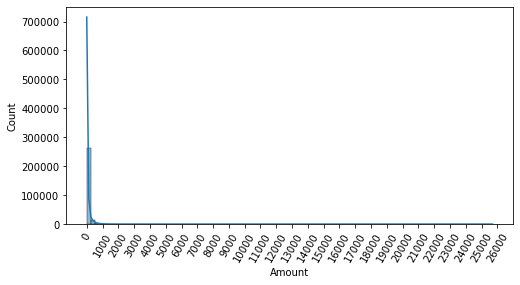

In [57]:
import seaborn as sns

plt.figure(figsize=(8,4))
plt.xticks(range(0,30000,1000), rotation=60)
sns.histplot(card_df['Amount'],bins=100, kde=True)
plt.show()

In [58]:
from sklearn.preprocessing import StandardScaler
# 사이킷런의 StandardScaler를 이용해 정규 분포 형태로 Amount 피처값 변환하는 로직으로 수정

def get_preprocessed_df(df=None):
    df_copy = df.copy()
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1,1))
    
    # 변환된 Amount를 Amount_Scaled로 피처명 변경 후 DataFrame 맨 앞 칼럼으로 입력
    df_copy.insert(0,'Amount_scaled',amount_n)
    
    # 기존 Time, Amount 피처 삭제
    df_copy.drop(['Time','Amount'],axis=1,inplace=True)
    
    return df_copy

In [60]:
# Amount를 정규 분포 형태로 변환 후 로지스틱 회귀 및 LightGBM 수행
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression(max_iter=1000)
get_model_train_eval(lr_clf,ftr_trai=X_train,ftr_test=X_test,tgt_train=y_train,tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators=1000,num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf,ftr_trai=X_train,ftr_test=X_test,tgt_train=y_train,tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###


TypeError: get_model_train_eval() got an unexpected keyword argument 'ftr_trai'

In [ ]:
# 로그 변환 : 데이터 분포도가 심하게 왜곡되어 있을 경우 적용하는 중요 기법 중 하나
def get_preprocessed_df(df=None):
    
    df_copy = df.copy()
    
    # 넘파이의 log1p()를 이용해 Amount를 로그 변환
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0,'Amount_scaled',amount_n)
    
    # 기존 Time, Amount 피처 삭제
    df_copy.drop(['Time','Amount'],axis=1,inplace=True)
    
    return df_copy

In [61]:
# Amount를 로그 변환 후 로지스틱 회귀 및 LightGBM 수행
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression(max_iter=1000)
get_model_train_eval(lr_clf,ftr_train=X_train,ftr_test=X_test,tgt_train=y_train,tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators=1000,num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf,ftr_train=X_train,ftr_test=X_test,tgt_train=y_train,tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   58    90]]
정확도:0.9992, 정밀도:0.8654, 재현율:0.6081, F1:0.7143, AUC:0.9702
### LightGBM 예측 성능 ###
오차 행렬
[[85290     5]
 [   37   111]]
정확도:0.9995, 정밀도:0.9569, 재현율:0.7500, F1:0.8409, AUC:0.9779


### 이상치 데이터 제거 후 모델 학습/예측/평가

<AxesSubplot:>

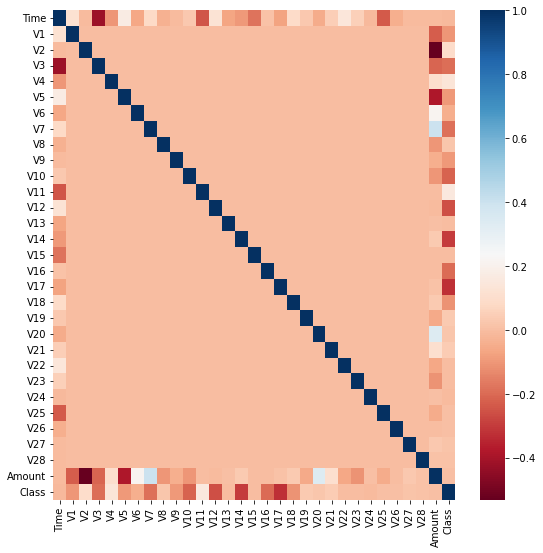

In [62]:
# 피처별 상관도를 구한 뒤 시본 heatmap으로 시각화

import seaborn as sns

plt.figure(figsize=(9,9))
corr = card_df.corr()
sns.heatmap(corr, cmap='RdBu')

In [63]:
import numpy as np

def get_outlier(df=None, column=None, weight=1.5):
    
    # fraud에 해당하는 column 데이터만 추출, 1/4 분위와 3/4 분위 지점을 np.percentile로 구함.
    fraud = df[df['Class']==1][column]
    quantile_25 = np.percentile(fraud.values,25)
    quantile_75 = np.percentile(fraud.values,75)
    
    # IQR을 구하고, IQR에 1.5를 곱해 최댓값과 최솟값 지점 구함.
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    
    # 최댓값보다 크거나, 최솟값보다 작은 값을 이상치 데이터로 설정하고 DataFrame Index 반환
    outlier_index = fraud[(fraud<lowest_val)|(fraud>highest_val)].index
    
    return outlier_index

In [64]:
# get_outlier 함수를 이용해 v14컬럼에서 이상치 데이터 찾기
outlier_index = get_outlier(df=card_df,column='V14',weight=1.5)
print('이상치 데이터 인덱스:',outlier_index)

이상치 데이터 인덱스: Int64Index([8296, 8615, 9035, 9252], dtype='int64')


In [66]:
# get_preprocessed_df()를 로그 변환 후 V14 피처의 이상치 데이터 삭제하는 로직으로 변경

def get_preprocessed_df(df=None):

    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0,'Amount_scaled',amount_n)
    df_copy.drop(['Time','Amount'],axis=1,inplace=True)
    
    # 이상치 데이터 삭제하는 로직 추가
    outlier_index = get_outlier(df=df_copy,column='V14',weight=1.5)
    df_copy.drop(outlier_index,axis=0,inplace=True)
    
    return df_copy

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression(max_iter=1000)
get_model_train_eval(lr_clf,ftr_train=X_train,ftr_test=X_test,tgt_train=y_train,tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators=1000,num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf,ftr_train=X_train,ftr_test=X_test,tgt_train=y_train,tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   48    98]]
정확도:0.9993, 정밀도:0.8750, 재현율:0.6712, F1:0.7597, AUC:0.9743
### LightGBM 예측 성능 ###
오차 행렬
[[85290     5]
 [   25   121]]
정확도:0.9996, 정밀도:0.9603, 재현율:0.8288, F1:0.8897, AUC:0.9780


### SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가

In [67]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ',X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ',X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포:\n',pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (199362, 29) (199362,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포:
 0    199020
1    199020
Name: Class, dtype: int64


In [68]:
lr_clf = LogisticRegression(max_iter=1000)

# ftr_train과 tgt_train 인자값이 SMOTE 증식된 X_train_over와 y_train_over로 변경됨에 유의
get_model_train_eval(lr_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

오차 행렬
[[82937  2358]
 [   11   135]]
정확도:0.9723, 정밀도:0.0542, 재현율:0.9247, F1:0.1023, AUC:0.9737


In [69]:
from sklearn.metrics import precision_recall_curve, roc_curve
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
    
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    # X축 threshold 값으로, Y축은 정밀도, 재현율 값으로 각각 plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label = 'precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label = 'recall')
    
    # threshold값 X축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # X축, Y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()

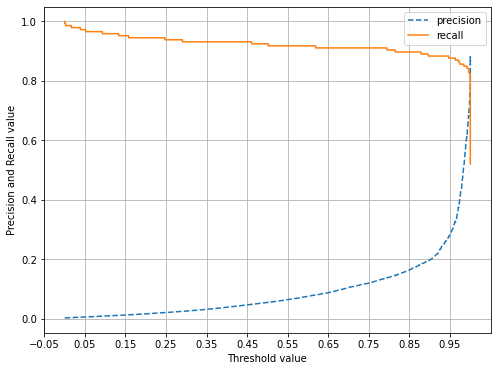

In [70]:
precision_recall_curve_plot(y_test,lr_clf.predict_proba(X_test)[:,1])

In [71]:
lgbm_clf = LGBMClassifier(n_estimators=1000,num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf,ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

오차 행렬
[[85283    12]
 [   22   124]]
정확도:0.9996, 정밀도:0.9118, 재현율:0.8493, F1:0.8794, AUC:0.9814


## 스태킹 앙상블

### 기본 스태킹 모델

In [72]:
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer_data = load_breast_cancer()

X_data = cancer_data.data
y_label = cancer_data.target

X_train, X_test, y_train, y_test = train_test_split(X_data, y_label, test_size=0.2, random_state=0)

In [73]:
# 개별 ML 모델 생성
knn_clf = KNeighborsClassifier(n_neighbors=4)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0)
dt_clf = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(n_estimators=100)

# 스태킹으로 만들어진 데이터 셋을 학습, 예측할 최종 모델
lr_final = LogisticRegression()

In [74]:
# 개별 모델들을 학습
knn_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)
dt_clf.fit(X_train, y_train)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=100)

In [75]:
# 학습된 개별 모델들이 각자 반환하는 예측 데이터 셋을 생성하고 개별 모델의 정확도 측정

knn_pred = knn_clf.predict(X_test)
rf_pred = rf_clf.predict(X_test)
dt_pred = dt_clf.predict(X_test)
ada_pred = ada_clf.predict(X_test)

print('KNN 정확도: {0:.4f}'.format(accuracy_score(y_test, knn_pred)))
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy_score(y_test, rf_pred)))
print('결정 트리 정확도: {0:.4f}'.format(accuracy_score(y_test, dt_pred)))
print('에이다부스트 정확도: {0:.4f}'.format(accuracy_score(y_test, ada_pred)))

KNN 정확도: 0.9211
랜덤 포레스트 정확도: 0.9649
결정 트리 정확도: 0.9035
에이다부스트 정확도: 0.9561


In [76]:
# 개별 알고리즘으로부터 예측된 예측값을 컬럼 레벨로 옆으로 붙여서 피처 값으로 만들어, 최종 메타 모델 로지스틱 회귀에서 학습 데이터로 다시 사용
pred = np.array([knn_pred, rf_pred, dt_pred, ada_pred])
print(pred.shape)

# transpose를 이용해 행과 열의 위치 교환. 컬럼 레벨로 각 알고리즘의 예측 결과를 피처로 만듦.
pred = np.transpose(pred)
print(pred.shape)

(4, 114)
(114, 4)


In [77]:
# 최종 메타 모델인 로지스틱 회귀 학습 및 예측 정확도 측정
lr_final.fit(pred, y_test)
final = lr_final.predict(pred)

print('최종 메탈 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test, final)))

최종 메탈 모델의 예측 정확도: 0.9737


### CV 세트 기반의 스태킹

In [78]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):

    # 지정된 n_folds 값으로 KFold 생성
    kf = KFold(n_splits=n_folds, shuffle=False)
    
    # 추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화
    train_fold_pred = np.zeros((X_train_n.shape[0],1))
    test_pred = np.zeros((X_test_n.shape[0], n_folds))
    print(model.__class__.__name__,'model 시작 ')
    
    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        
        # 입력된 학습 데이터에서 기반 모델이 학습/ 예측할 폴드 데이터 셋 추출
        print('\t 폴드 세트: ', folder_counter, ' 시작 ')
        X_tr = X_train_n[train_index]
        y_tr = y_train_n[train_index]
        X_te = X_train_n[valid_index]
        
        # 폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행
        model.fit(X_tr, y_tr)
        
        # 폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장
        train_fold_pred[valid_index,:] = model.predict(X_te).reshape(-1,1)
        
        # 입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장
        test_pred[:, folder_counter] = model.predict(X_test_n)
        
    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)
    
    # train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred, test_pred_mean

In [79]:
knn_train, knn_test = get_stacking_base_datasets(knn_clf, X_train, y_train, X_test, 7)
rf_train, rf_test = get_stacking_base_datasets(rf_clf, X_train, y_train, X_test, 7)
dt_train, dt_test = get_stacking_base_datasets(dt_clf, X_train, y_train, X_test, 7)
ada_train, ada_test = get_stacking_base_datasets(ada_clf, X_train, y_train, X_test, 7)

KNeighborsClassifier model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
RandomForestClassifier model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
DecisionTreeClassifier model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
AdaBoostClassifier model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 


In [80]:
Stack_final_X_train = np.concatenate((knn_train, rf_train, dt_train, ada_train), axis=1)
Stack_final_X_test = np.concatenate((knn_test, rf_test, dt_test, ada_test), axis=1)

print('원본 학습 피처 데이터 Shape:',X_train.shape, '원본 테스트 피처 Shape:',X_test.shape)
print('스태킹 학습 피처 데이터 Shape:',Stack_final_X_train.shape,
     '스태킹 테스트 피처 데이터 Shape:',Stack_final_X_test.shape)

원본 학습 피처 데이터 Shape: (455, 30) 원본 테스트 피처 Shape: (114, 30)
스태킹 학습 피처 데이터 Shape: (455, 4) 스태킹 테스트 피처 데이터 Shape: (114, 4)


In [81]:
lr_final.fit(Stack_final_X_train,y_train)
stack_final = lr_final.predict(Stack_final_X_test)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test,stack_final)))

최종 메타 모델의 예측 정확도: 0.9825
